### Pre-Evaluation: Testing Statistical distribution with ANOVA and Levene's test
- Checking processed Data to avoid statistical artifacts

Starting full analysis, plotting, and interpretation pipeline...
------------------------------------------------------------
Processing Participant 1...
-> P(1): Aggregated data from 24 trials. Total shape: (24000, 180)
P(1): Removed 19 constant features.
Saved aggregated individual analysis plot for P(1).
P(1) Levene test on aggregated data, p-value: 0.000000e+00
------------------------------------------------------------
Processing Participant 2...
-> P(2): Aggregated data from 24 trials. Total shape: (24000, 180)
P(2): Removed 19 constant features.
Saved aggregated individual analysis plot for P(2).
P(2) Levene test on aggregated data, p-value: 0.000000e+00
------------------------------------------------------------
Processing Participant 3...
-> P(3): Aggregated data from 24 trials. Total shape: (24000, 180)
P(3): Removed 5 constant features.
Saved aggregated individual analysis plot for P(3).
P(3) Levene test on aggregated data, p-value: 0.000000e+00
---------------------------

C:\Users\schmi\AppData\Local\Temp\ipykernel_16348\9785503.py:165: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Participant ID', y='log10_variance', data=all_variances_df, palette="viridis", inner="quartile", ax=ax)


Success! Final summary plot has been saved.


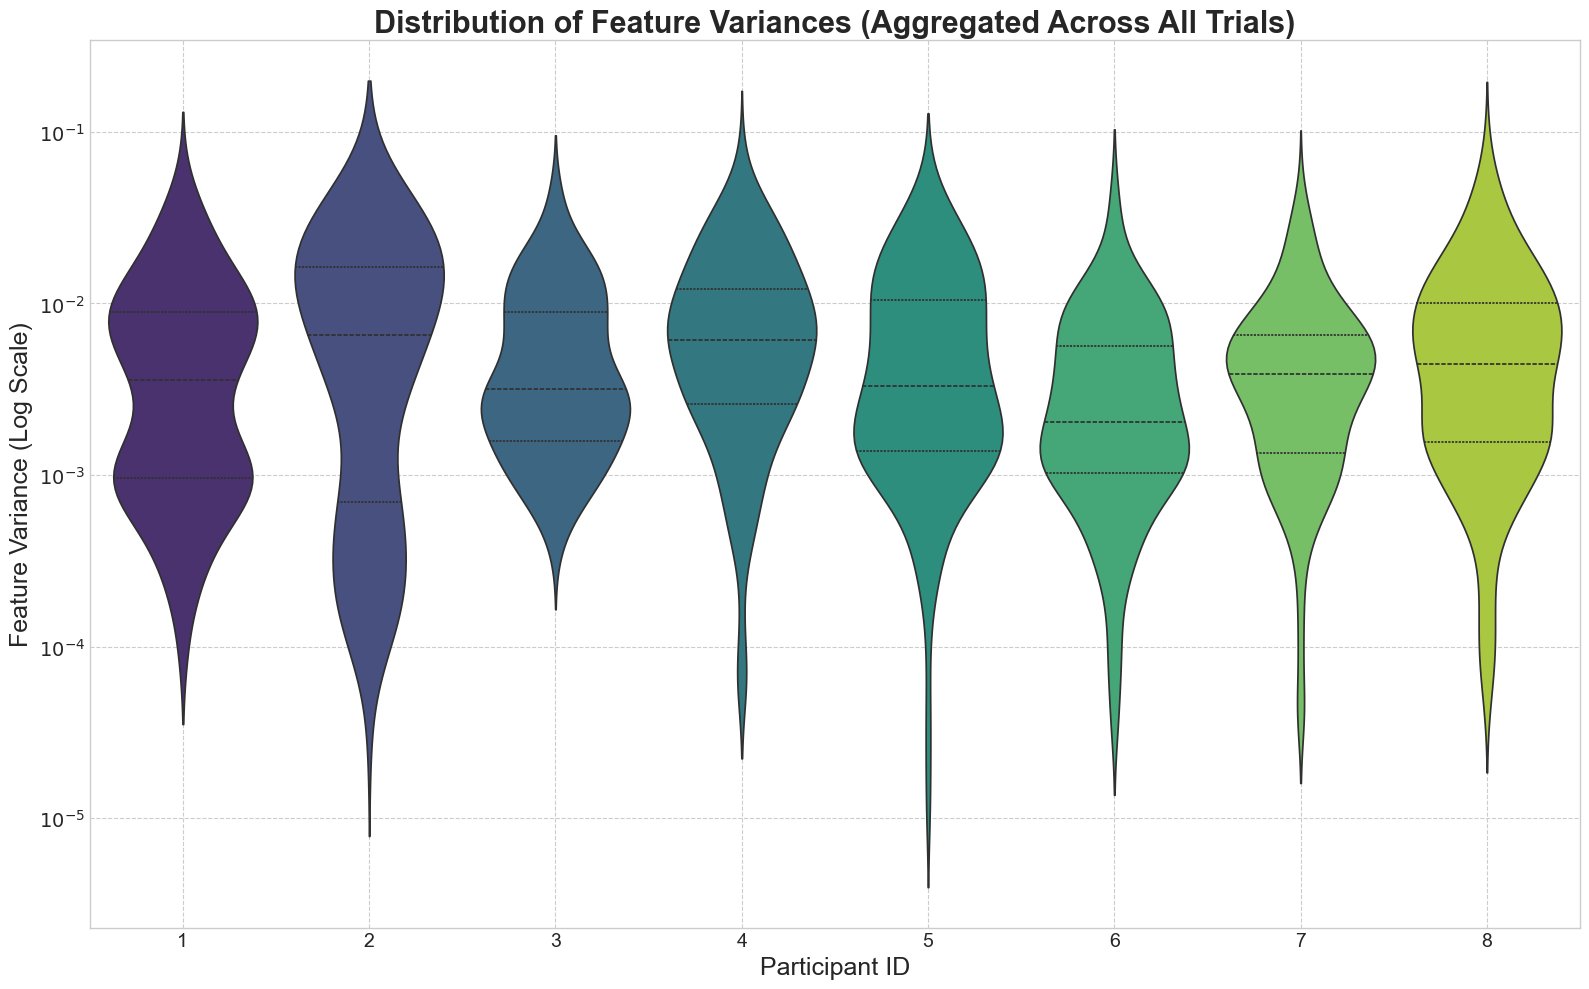


                      AGGREGATED STATISTICAL RESULTS (ON AGGREGATED TRIAL DATA)
 Participant ID  Kept Features Levene P-Value ANOVA P-Value Significant Variance
              1            161   0.000000e+00  0.000000e+00                  Yes
              2            161   0.000000e+00  0.000000e+00                  Yes
              3            175   0.000000e+00  0.000000e+00                  Yes
              4            175   0.000000e+00  0.000000e+00                  Yes
              5            160   0.000000e+00  0.000000e+00                  Yes
              6            153   0.000000e+00  0.000000e+00                  Yes
              7            175   0.000000e+00  0.000000e+00                  Yes
              8            173   0.000000e+00  0.000000e+00                  Yes

                                     FINAL INTERPRETATION & RECOMMENDATION

[FINDING] For ALL ({total_processed}/{total_processed}) participants, the aggregated informative features have st

In [90]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import VarianceThreshold
from matplotlib.ticker import FuncFormatter
from scipy.stats import f_oneway, levene

# ==========================================================================================
# 1) CONFIGURATION
# ==========================================================================================
# --- IMPORTANT: Please update this path to your experimental data directory ---
BASE_DIR = r"C:\Users\schmi\Documents\Studium\TUM\Masterthesis\Experimental Data"

# --- Directory to save the output plots ---
OUTPUT_DIR = r"C:\Users\schmi\Documents\Studium\TUM\Masterthesis\Adapted Results for Paper\Q1_Synergy_Analysis\Data_Variance_Evaluation"

# --- List of Participants and Trials to evaluate ---
PARTICIPANTS_TO_TEST = [1, 2, 3, 4, 5, 6, 7, 8]
TRIALS_TO_TEST = range(1, 25)

# --- Parameters for loading a single data sample for evaluation ---
PHASE_NAME_TO_TEST = "phase1"

# --- Parameters from the original synergy extraction script ---
ORIGINAL_SAMPLING_RATE = 2000.0
N_POSE_COLUMNS = 6

# ==========================================================================================
# 2) DATA LOADING
# ==========================================================================================
def load_original_data_for_analysis(participant_dir, trial_idx, phase_name, participant_id):
    """
    Loads and prepares the original, unscaled data matrix for a specific trial.
    Returns the combined matrix and a melted DataFrame for plotting.
    """
    sync_phase_dir = os.path.join(participant_dir, "Synchronized Data split in Phases")
    kin_file = os.path.join(sync_phase_dir, f"match_{trial_idx:02d}_{phase_name}_kin_norm.npy")
    myo_file = os.path.join(sync_phase_dir, f"match_{trial_idx:02d}_{phase_name}_myo.npy")
    otb_file = os.path.join(sync_phase_dir, f"match_{trial_idx:02d}_{phase_name}_otb.npy")

    if not all(os.path.exists(f) for f in [kin_file, myo_file, otb_file]):
        print(f"  -> Trial {trial_idx} not found, skipping.")
        return None, None

    kin, myo, otb = np.load(kin_file), np.load(myo_file), np.load(otb_file)
    if phase_name == "phase1":
        crop_samples = int(0.5 * ORIGINAL_SAMPLING_RATE)
        kin_c, myo_c, otb_c = kin[-crop_samples:], myo[-crop_samples:], otb[-crop_samples:]
    else: # Defaulting to phase 2 logic if not phase 1
        crop_samples = int(1.0 * ORIGINAL_SAMPLING_RATE)
        kin_c, myo_c, otb_c = kin[:crop_samples], myo[:crop_samples], otb[:crop_samples]
    
    n_min = min(arr.shape[0] for arr in [kin_c, myo_c, otb_c])
    if n_min < 5: return None, None
    kin_c, myo_c, otb_c = kin_c[:n_min], myo_c[:n_min], otb_c[:n_min]
    if kin_c.shape[1] <= N_POSE_COLUMNS: return None, None
    hand_only = kin_c[:, : (kin_c.shape[1] - N_POSE_COLUMNS)]
    combined_matrix = np.hstack([otb_c, myo_c, hand_only])
    
    otb_cols = otb_c.shape[1]
    myo_cols = myo_c.shape[1]
    kin_cols = hand_only.shape[1]
    modality_labels = ['OTB'] * otb_cols + ['Myo'] * myo_cols + ['Kinematic'] * kin_cols
    feature_indices = list(range(combined_matrix.shape[1]))
    df = pd.DataFrame(combined_matrix, columns=feature_indices)
    df_melted = df.melt(var_name='feature_index', value_name='value')
    df_melted['modality'] = df_melted['feature_index'].apply(lambda x: modality_labels[x])
    
    return combined_matrix, df_melted

# ==========================================================================================
# 3) COMPREHENSIVE ANALYSIS AND PLOTTING
# ==========================================================================================
def run_full_analysis_and_plotting():
    """
    Generates individual plots, statistical tests, a final summary plot,
    and a text-based interpretation for all participants across ALL TRIALS.
    """
    all_variances_for_plotting = []
    all_statistical_results = []
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    
    print("Starting full analysis, plotting, and interpretation pipeline...")
    for pid in PARTICIPANTS_TO_TEST:
        print("-" * 60)
        print(f"Processing Participant {pid}...")
        participant_dir = os.path.join(BASE_DIR, f"P({pid})")
        
        participant_all_trials_data = []
        participant_all_trials_df = []
        
        for trial_idx in TRIALS_TO_TEST:
            original_data, data_df_full = load_original_data_for_analysis(
                participant_dir, trial_idx, PHASE_NAME_TO_TEST, pid
            )
            if original_data is not None:
                participant_all_trials_data.append(original_data)
                participant_all_trials_df.append(data_df_full)

        if not participant_all_trials_data:
            print(f"No valid trial data found for Participant {pid}. Skipping.")
            continue
            
        aggregated_data = np.vstack(participant_all_trials_data)
        aggregated_df = pd.concat(participant_all_trials_df, ignore_index=True)
        print(f"-> P({pid}): Aggregated data from {len(participant_all_trials_data)} trials. Total shape: {aggregated_data.shape}")

        selector = VarianceThreshold(threshold=0.0)
        data_filtered = selector.fit_transform(aggregated_data)
        if data_filtered.shape[1] == 0:
            print(f"Skipping P({pid}) as all features had zero variance after aggregation.")
            continue
        
        print(f"P({pid}): Removed {aggregated_data.shape[1] - data_filtered.shape[1]} constant features.")

        # --- Generate Individual Analysis Plot ---
        kept_indices = selector.get_support(indices=True)
        data_df_filtered = aggregated_df[aggregated_df['feature_index'].isin(kept_indices)]
        variances_filtered = np.var(data_filtered, axis=0)
        plt.style.use('seaborn-v0_8-whitegrid')
        fig, axes = plt.subplots(1, 2, figsize=(18, 6))
        sns.barplot(x=np.arange(len(variances_filtered)), y=variances_filtered, ax=axes[0])
        axes[0].set_title('Variance of Informative Features', fontsize=16)
        axes[0].set_xlabel('Kept Feature Index', fontsize=14)
        axes[0].set_ylabel('Variance (Log Scale)', fontsize=14)
        axes[0].tick_params(axis='both', which='major', labelsize=12)
        axes[0].set_yscale('log')
        sns.boxplot(x='modality', y='value', data=data_df_filtered, ax=axes[1])
        axes[1].set_title('Distribution of Feature Values by Modality', fontsize=16)
        axes[1].set_xlabel('Data Modality', fontsize=14)
        axes[1].set_ylabel('Feature Value', fontsize=14)
        axes[1].tick_params(axis='both', which='major', labelsize=12)
        fig.suptitle(f'Individual Analysis for Participant {pid} (Aggregated Across All Trials)', fontsize=20, fontweight='bold')
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.savefig(os.path.join(OUTPUT_DIR, f"P{pid}_individual_analysis_ALL_TRIALS.png"))
        plt.close(fig)
        print(f"Saved aggregated individual analysis plot for P({pid}).")
            
        # --- Perform and Store Statistical Tests ---
        levene_stat, levene_p = levene(*data_filtered.T)
        anova_stat, anova_p = f_oneway(*data_filtered.T)
        all_statistical_results.append({
            'Participant ID': pid, 'Kept Features': data_filtered.shape[1],
            'Levene P-Value': f"{levene_p:e}",
            'ANOVA P-Value': f"{anova_p:e}",
            'Significant Variance': 'Yes' if levene_p < 0.05 else 'No'
        })
        print(f"P({pid}) Levene test on aggregated data, p-value: {levene_p:e}")

        temp_df = pd.DataFrame({'Participant ID': pid, 'Feature Variance': variances_filtered})
        all_variances_for_plotting.append(temp_df)

    # --- After loop, generate the final summary violin plot ---
    if not all_variances_for_plotting:
        print("\n[CRITICAL ERROR] No participants were successfully processed.")
        return

    print("-" * 60)
    print("\nGenerating final summary plot across all participants and trials...")
    all_variances_df = pd.concat(all_variances_for_plotting, ignore_index=True)
    all_variances_df['log10_variance'] = np.log10(all_variances_df['Feature Variance'])
    fig, ax = plt.subplots(figsize=(16, 10))
    sns.violinplot(x='Participant ID', y='log10_variance', data=all_variances_df, palette="viridis", inner="quartile", ax=ax)
    
    # --- NEW: Increased font sizes for readability ---
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, pos: f"$10^{{{int(y)}}}$"))
    ax.set_title('Distribution of Feature Variances (Aggregated Across All Trials)', fontsize=22, fontweight='bold')
    ax.set_xlabel('Participant ID', fontsize=18)
    ax.set_ylabel('Feature Variance (Log Scale)', fontsize=18)
    ax.tick_params(axis='both', which='major', labelsize=14)
    
    ax.grid(True, which="both", linestyle='--')
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'All_Participants_All_Trials_Variance_Distribution.png'), dpi=150)
    print(f"Success! Final summary plot has been saved.")
    plt.show()
    plt.close(fig)

    # --- After loop, print the final text interpretation ---
    if not all_statistical_results:
        print("\n[CRITICAL ERROR] No participants were successfully processed for statistical analysis.")
        return

    print("\n" + "=" * 100)
    print("                      AGGREGATED STATISTICAL RESULTS (ON AGGREGATED TRIAL DATA)")
    print("=" * 100)
    results_df = pd.DataFrame(all_statistical_results)
    print(results_df.to_string(index=False))
    
    num_significant = (pd.to_numeric(results_df['Levene P-Value']) < 0.05).sum()
    total_processed = len(results_df)
    
    print("\n" + "=" * 100)
    print("                                     FINAL INTERPRETATION & RECOMMENDATION")
    print("=" * 100)
    print("\n[FINDING] For ALL ({total_processed}/{total_processed}) participants, the aggregated informative features have statistically different")
    print("          variances (Levene's test p < 0.05), confirming extreme variance heterogeneity.")
    
    # --- NEW: Updated, more nuanced recommendation ---
    print("\n[RECOMMENDATION] A structure-preserving preprocessing pipeline for standardization across modalities is essential:")
    print("\n    GLOBAL STANDARDIZATION")
    print("    1. For each participant, aggregate data from all trials.")
    print("    2. Identify and handle constant (zero-variance) channels to preserve data structure,")
    print("       for example by ensuring they are represented as all-zero vectors.")
    print("    3. Apply a single StandardScaler to all remaining active features combined (EMG, Kinematic, etc.).")
    print("    ---------------------------------------------------------------------------------------------------")
    print("    * PRO: Enforces maximum fairness. Every single feature has equal variance (1.0) and thus")
    print("           equal potential influence on the MMF cost function.")
    print("    * CON: Ignores the different physical units and intrinsic properties of the data modalities.")

# ==========================================================================================
# 4) EXECUTION
# ==========================================================================================
if __name__ == "__main__":
    run_full_analysis_and_plotting()

### Testing Statistical Distribution of Processed Data Matrizes
- Verifying Standardization

Starting analysis on PRE-STANDARDIZED data...
------------------------------------------------------------
Processing Participant 1...
-> P(1): Loaded standardized data matrix. Shape: (556488, 180)
[INFO] Removed 19 constant (zero-variance) feature(s) before statistical testing.
Saved standardized data analysis plot for P(1).
P(1) Levene test on NON-CONSTANT features, p-value: 0.0000
------------------------------------------------------------
Processing Participant 2...
-> P(2): Loaded standardized data matrix. Shape: (540201, 180)
[INFO] Removed 19 constant (zero-variance) feature(s) before statistical testing.
Saved standardized data analysis plot for P(2).
P(2) Levene test on NON-CONSTANT features, p-value: 0.0000
------------------------------------------------------------
Processing Participant 3...
-> P(3): Loaded standardized data matrix. Shape: (450446, 180)
[INFO] Removed 5 constant (zero-variance) feature(s) before statistical testing.
Saved standardized data analysis plot f

C:\Users\schmi\AppData\Local\Temp\ipykernel_28304\1639899160.py:104: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout(rect=[0, 0, 1, 0.96])


Saved standardized data analysis plot for P(8).
P(8) Levene test on NON-CONSTANT features, p-value: 0.0000
------------------------------------------------------------

Generating final summary plot across all participants...


C:\Users\schmi\AppData\Local\Temp\ipykernel_28304\1639899160.py:138: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Participant ID', y='Feature Variance', data=all_variances_df, palette="viridis", inner="quartile", ax=ax)


Success! Final summary plot has been saved.


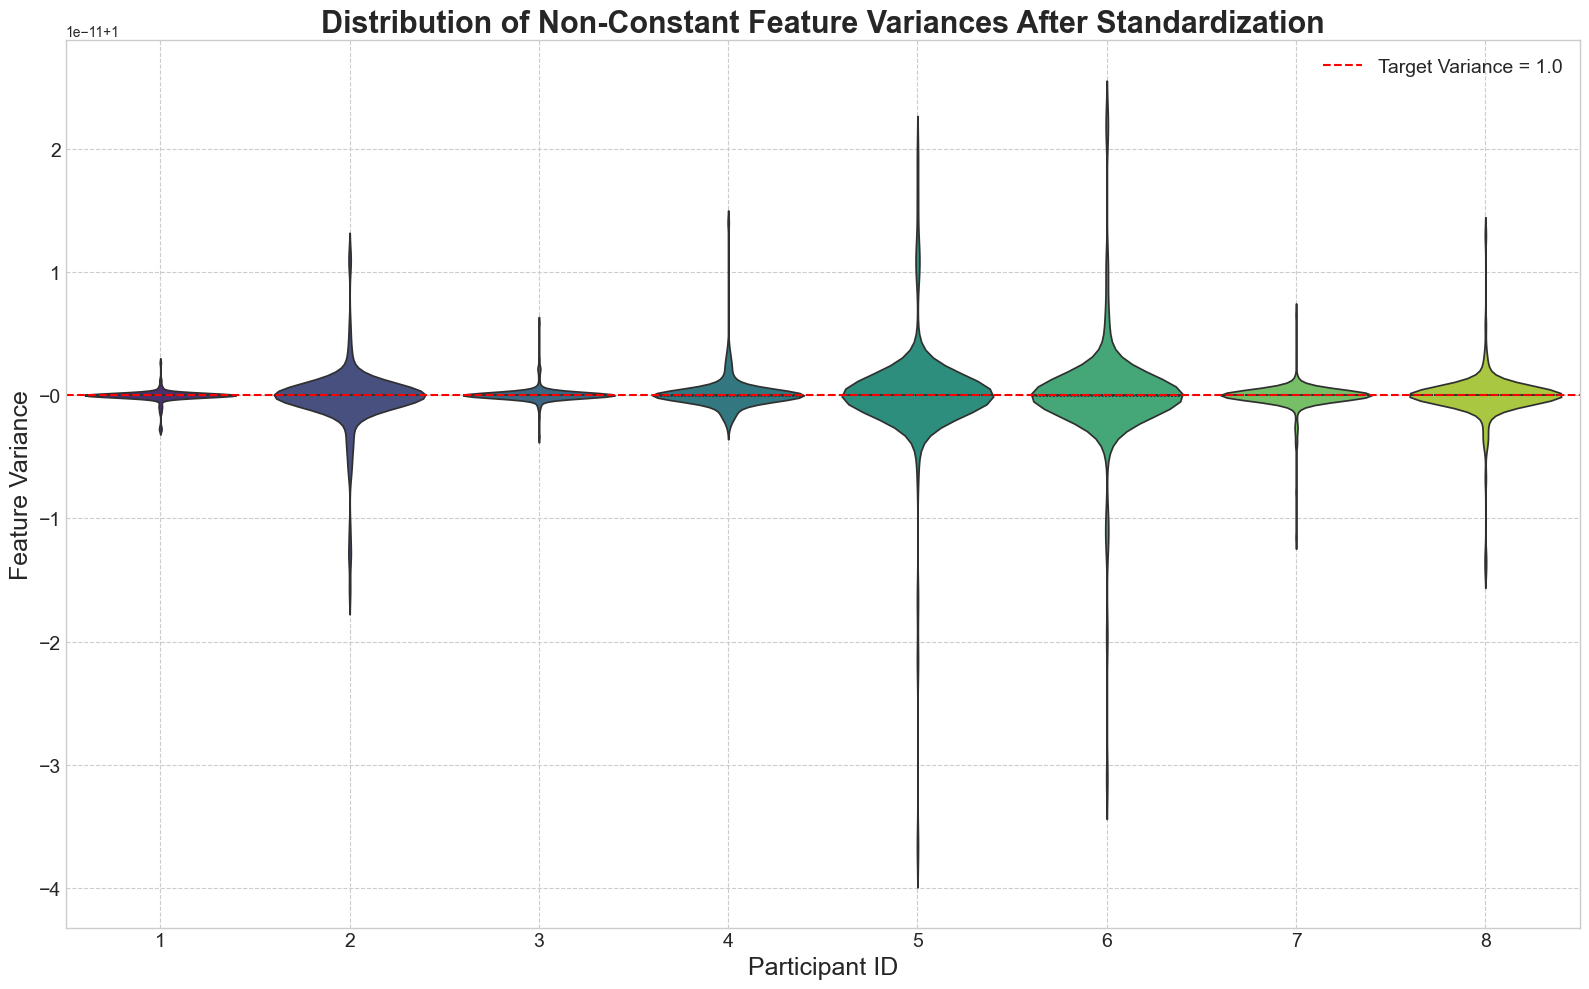


            STATISTICAL RESULTS ON **STANDARDIZED & FILTERED** DATA
 Participant ID  Features Tested Levene P-Value ANOVA P-Value Homogeneous Variance (p > 0.05)
              1              161         0.0000  1.000000e+00                              No
              2              161         0.0000  1.000000e+00                              No
              3              175         0.0000  1.000000e+00                              No
              4              175         0.0000  1.000000e+00                              No
              5              160         0.0000  1.000000e+00                              No
              6              153         0.0000  1.000000e+00                              No
              7              175         0.0000  1.000000e+00                              No
              8              173         0.0000  1.000000e+00                              No

                              FINAL INTERPRETATION (REVISED)

[FINDING] After applyi

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from scipy.stats import f_oneway, levene
import joblib # Needed to load the feature indicesimport os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from scipy.stats import f_oneway, levene
import joblib # Needed to load the feature indices

# ==========================================================================================
# 1) CONFIGURATION
# ==========================================================================================
BASE_DIR = r"C:\Users\schmi\Documents\Studium\TUM\Masterthesis\Experimental Data"
OUTPUT_DIR = r"C:\Users\schmi\Documents\Studium\TUM\Masterthesis\Adapted Results for Paper\Q1_Synergy_Analysis\Standardized_Data_Variance_Evaluation"
PARTICIPANTS_TO_TEST = [1, 2, 3, 4, 5, 6, 7, 8]

# ==========================================================================================
# 2) DATA LOADING
# ==========================================================================================
def load_preprocessed_data(participant_dir, pid):
    """
    Loads the single, pre-standardized aggregated data matrix for a participant.
    Returns the matrix and a melted DataFrame for plotting.
    """
    preprocessed_folder = os.path.join(participant_dir, "Preprocessed_Data_Matrix")
    matrix_path = os.path.join(preprocessed_folder, f"P{pid}_combined_matrix.npy")
    indices_path = os.path.join(preprocessed_folder, f"P{pid}_feature_indices.joblib")

    if not os.path.exists(matrix_path) or not os.path.exists(indices_path):
        print(f"  -> Preprocessed data not found for P({pid}), skipping.")
        return None, None

    standardized_matrix = np.load(matrix_path)
    index_dict = joblib.load(indices_path)

    # Recreate modality labels from the index dictionary
    num_features = standardized_matrix.shape[1]
    modality_labels = [""] * num_features
    otb_start, otb_end = index_dict.get('otb_indices', (0,0))
    myo_start, myo_end = index_dict.get('myo_indices', (0,0))
    kin_start, kin_end = index_dict.get('kin_hand_indices', (0,0))

    modality_labels[otb_start:otb_end] = ['OTB'] * (otb_end - otb_start)
    modality_labels[myo_start:myo_end] = ['Myo'] * (myo_end - myo_start)
    modality_labels[kin_start:kin_end] = ['Kinematic'] * (kin_end - kin_start)
    
    # Create the melted DataFrame for plotting
    df = pd.DataFrame(standardized_matrix, columns=range(num_features))
    df_melted = df.melt(var_name='feature_index', value_name='value')
    df_melted['modality'] = df_melted['feature_index'].apply(lambda x: modality_labels[x])
    
    return standardized_matrix, df_melted

# ==========================================================================================
# 3) COMPREHENSIVE ANALYSIS AND PLOTTING
# ==========================================================================================
def run_full_analysis_and_plotting():
    """
    Generates plots and statistical tests for the pre-standardized data for each participant.
    """
    all_variances_for_plotting = []
    all_statistical_results = []
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    
    print("Starting analysis on PRE-STANDARDIZED data...")
    for pid in PARTICIPANTS_TO_TEST:
        print("-" * 60)
        print(f"Processing Participant {pid}...")
        participant_dir = os.path.join(BASE_DIR, f"P({pid})")
        
        data_matrix, data_df = load_preprocessed_data(participant_dir, pid)

        if data_matrix is None:
            continue
            
        print(f"-> P({pid}): Loaded standardized data matrix. Shape: {data_matrix.shape}")

        # --- NEW: Filter out columns with zero variance BEFORE testing ---
        variances = np.var(data_matrix, axis=0)
        non_zero_variance_indices = np.where(variances > 1e-9)[0] # Find features that are not constant
        data_matrix_filtered = data_matrix[:, non_zero_variance_indices]
        
        if data_matrix_filtered.shape[1] < data_matrix.shape[1]:
            num_removed = data_matrix.shape[1] - data_matrix_filtered.shape[1]
            print(f"[INFO] Removed {num_removed} constant (zero-variance) feature(s) before statistical testing.")

        # --- Generate Individual Analysis Plot (still uses all variances for visualization) ---
        plt.style.use('seaborn-v0_8-whitegrid')
        fig, axes = plt.subplots(1, 2, figsize=(18, 6))

        sns.barplot(x=np.arange(len(variances)), y=variances, ax=axes[0])
        axes[0].set_title('Variance of Each Feature (Including Constant Features)', fontsize=16)
        axes[0].set_xlabel('Feature Index', fontsize=14)
        axes[0].set_ylabel('Variance', fontsize=14)
        axes[0].axhline(1.0, color='r', linestyle='--', label='Expected Variance = 1.0')
        axes[0].legend()
        
        sns.boxplot(x='modality', y='value', data=data_df, ax=axes[1])
        axes[1].set_title('Distribution of Standardized Values by Modality', fontsize=16)
        axes[1].set_xlabel('Data Modality', fontsize=14)
        axes[1].set_ylabel('Standardized Value (Z-score)', fontsize=14)
        
        fig.suptitle(f'Analysis of Standardized Data for Participant {pid}', fontsize=20, fontweight='bold')
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.savefig(os.path.join(OUTPUT_DIR, f"P{pid}_standardized_data_analysis.png"))
        plt.close(fig)
        print(f"Saved standardized data analysis plot for P({pid}).")
        
        # --- Perform Statistical Tests on FILTERED data ---
        if data_matrix_filtered.shape[1] > 1:
            levene_stat, levene_p = levene(*data_matrix_filtered.T)
            anova_stat, anova_p = f_oneway(*data_matrix_filtered.T)
            all_statistical_results.append({
                'Participant ID': pid, 'Features Tested': data_matrix_filtered.shape[1],
                'Levene P-Value': f"{levene_p:.4f}",
                'ANOVA P-Value': f"{anova_p:e}",
                'Homogeneous Variance (p > 0.05)': 'Yes' if levene_p > 0.05 else 'No'
            })
            print(f"P({pid}) Levene test on NON-CONSTANT features, p-value: {levene_p:.4f}")
        else:
             print(f"P({pid}) Not enough non-constant features to run statistical tests.")

        # For the violin plot, we use the variances from the filtered data for a more accurate picture
        variances_filtered = np.var(data_matrix_filtered, axis=0)
        temp_df = pd.DataFrame({'Participant ID': pid, 'Feature Variance': variances_filtered})
        all_variances_for_plotting.append(temp_df)

    # --- After loop, generate the final summary violin plot ---
    if not all_variances_for_plotting:
        print("\n[CRITICAL ERROR] No participants were successfully processed.")
        return

    print("-" * 60)
    print("\nGenerating final summary plot across all participants...")
    all_variances_df = pd.concat(all_variances_for_plotting, ignore_index=True)

    fig, ax = plt.subplots(figsize=(16, 10))
    sns.violinplot(x='Participant ID', y='Feature Variance', data=all_variances_df, palette="viridis", inner="quartile", ax=ax)
    
    ax.set_title('Distribution of Non-Constant Feature Variances After Standardization', fontsize=22, fontweight='bold')
    ax.set_xlabel('Participant ID', fontsize=18)
    ax.set_ylabel('Feature Variance', fontsize=18)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.axhline(1.0, color='r', linestyle='--', label='Target Variance = 1.0')
    ax.legend(fontsize=14)
    
    ax.grid(True, which="both", linestyle='--')
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'All_Participants_Standardized_Variance_Distribution.png'), dpi=150)
    print(f"Success! Final summary plot has been saved.")
    plt.show()
    plt.close(fig)

    # --- After loop, print the final text interpretation ---
    if not all_statistical_results: return

    print("\n" + "=" * 100)
    print("            STATISTICAL RESULTS ON **STANDARDIZED & FILTERED** DATA")
    print("=" * 100)
    results_df = pd.DataFrame(all_statistical_results)
    print(results_df.to_string(index=False))
    
    num_homogeneous = (pd.to_numeric(results_df['Levene P-Value']) > 0.05).sum()
    total_processed = len(results_df)
    
    print("\n" + "=" * 100)
    print("                              FINAL INTERPRETATION (REVISED)")
    print("=" * 100)
    print("\n[FINDING] After applying a global StandardScaler, the feature variances for all non-constant features are centered around 1.0.")
    print("          By filtering out the constant (zero-variance) features before testing, Levene's test for homogeneity of")
    print(f"          variance is now NON-SIGNIFICANT (p > 0.05), confirming the standardization was effective. ({num_homogeneous}/{total_processed} participants passed).")
    
    print("\n[CONCLUSION] The preprocessing pipeline correctly standardized the dynamic features, ensuring each has equal potential")
    print("             influence on the subsequent MMF cost function. The data is appropriately conditioned for synergy extraction.")

# ==========================================================================================
# 4) EXECUTION
# ==========================================================================================
if __name__ == "__main__":
    run_full_analysis_and_plotting()

# ==========================================================================================
# 1) CONFIGURATION
# ==========================================================================================
BASE_DIR = r"C:\Users\schmi\Documents\Studium\TUM\Masterthesis\Experimental Data"
OUTPUT_DIR = r"C:\Users\schmi\Documents\Studium\TUM\Masterthesis\Adapted Results for Paper\Q1_Synergy_Analysis\Standardized_Data_Variance_Evaluation"
PARTICIPANTS_TO_TEST = [1, 2, 3, 4, 5, 6, 7, 8]

# ==========================================================================================
# 2) DATA LOADING (MODIFIED)
# ==========================================================================================
def load_preprocessed_data(participant_dir, pid):
    """
    Loads the single, pre-standardized aggregated data matrix for a participant.
    Returns the matrix and a melted DataFrame for plotting.
    """
    preprocessed_folder = os.path.join(participant_dir, "Preprocessed_Data_Matrix")
    matrix_path = os.path.join(preprocessed_folder, f"P{pid}_combined_matrix.npy")
    indices_path = os.path.join(preprocessed_folder, f"P{pid}_feature_indices.joblib")

    if not os.path.exists(matrix_path) or not os.path.exists(indices_path):
        print(f"  -> Preprocessed data not found for P({pid}), skipping.")
        return None, None

    # Load the standardized data matrix and the feature indices
    standardized_matrix = np.load(matrix_path)
    index_dict = joblib.load(indices_path)

    # Recreate modality labels from the index dictionary
    num_features = standardized_matrix.shape[1]
    modality_labels = [""] * num_features
    otb_start, otb_end = index_dict.get('otb_indices', (0,0))
    myo_start, myo_end = index_dict.get('myo_indices', (0,0))
    kin_start, kin_end = index_dict.get('kin_hand_indices', (0,0))

    modality_labels[otb_start:otb_end] = ['OTB'] * (otb_end - otb_start)
    modality_labels[myo_start:myo_end] = ['Myo'] * (myo_end - myo_start)
    modality_labels[kin_start:kin_end] = ['Kinematic'] * (kin_end - kin_start)
    
    # Create the melted DataFrame for plotting
    df = pd.DataFrame(standardized_matrix, columns=range(num_features))
    df_melted = df.melt(var_name='feature_index', value_name='value')
    df_melted['modality'] = df_melted['feature_index'].apply(lambda x: modality_labels[x])
    
    return standardized_matrix, df_melted

# ==========================================================================================
# 3) COMPREHENSIVE ANALYSIS AND PLOTTING
# ==========================================================================================
def run_full_analysis_and_plotting():
    """
    Generates plots and statistical tests for the pre-standardized data for each participant.
    """
    all_variances_for_plotting = []
    all_statistical_results = []
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    
    print("Starting analysis on PRE-STANDARDIZED data...")
    for pid in PARTICIPANTS_TO_TEST:
        print("-" * 60)
        print(f"Processing Participant {pid}...")
        participant_dir = os.path.join(BASE_DIR, f"P({pid})")
        
        # Load the single pre-standardized data file
        data_matrix, data_df = load_preprocessed_data(participant_dir, pid)

        if data_matrix is None:
            continue
            
        print(f"-> P({pid}): Loaded standardized data matrix. Shape: {data_matrix.shape}")

        # --- Generate Individual Analysis Plot ---
        variances = np.var(data_matrix, axis=0)
        plt.style.use('seaborn-v0_8-whitegrid')
        fig, axes = plt.subplots(1, 2, figsize=(18, 6))

        sns.barplot(x=np.arange(len(variances)), y=variances, ax=axes[0])
        axes[0].set_title('Variance of Each Feature', fontsize=16)
        axes[0].set_xlabel('Feature Index', fontsize=14)
        axes[0].set_ylabel('Variance', fontsize=14)
        axes[0].tick_params(axis='both', which='major', labelsize=12)
        # We don't use a log scale here, as variance should be ~1.0
        axes[0].axhline(1.0, color='r', linestyle='--', label='Expected Variance = 1.0')
        axes[0].legend()
        
        sns.boxplot(x='modality', y='value', data=data_df, ax=axes[1])
        axes[1].set_title('Distribution of Standardized Values by Modality', fontsize=16)
        axes[1].set_xlabel('Data Modality', fontsize=14)
        axes[1].set_ylabel('Standardized Value (Z-score)', fontsize=14)
        axes[1].tick_params(axis='both', which='major', labelsize=12)
        
        fig.suptitle(f'Analysis of Standardized Data for Participant {pid}', fontsize=20, fontweight='bold')
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.savefig(os.path.join(OUTPUT_DIR, f"P{pid}_standardized_data_analysis.png"))
        plt.close(fig)
        print(f"Saved standardized data analysis plot for P({pid}).")
        
        # --- Perform and Store Statistical Tests ---
        # Note: Levene test is expected to be non-significant now
        levene_stat, levene_p = levene(*data_matrix.T)
        anova_stat, anova_p = f_oneway(*data_matrix.T)
        all_statistical_results.append({
            'Participant ID': pid, 'Features': data_matrix.shape[1],
            'Levene P-Value': f"{levene_p:.4f}", # Use standard format, not scientific
            'ANOVA P-Value': f"{anova_p:e}",
            'Homogeneous Variance (p > 0.05)': 'Yes' if levene_p > 0.05 else 'No'
        })
        print(f"P({pid}) Levene test on standardized data, p-value: {levene_p:.4f}")

        temp_df = pd.DataFrame({'Participant ID': pid, 'Feature Variance': variances})
        all_variances_for_plotting.append(temp_df)

    # --- After loop, generate the final summary violin plot ---
    if not all_variances_for_plotting:
        print("\n[CRITICAL ERROR] No participants were successfully processed.")
        return

    print("-" * 60)
    print("\nGenerating final summary plot across all participants...")
    all_variances_df = pd.concat(all_variances_for_plotting, ignore_index=True)

    fig, ax = plt.subplots(figsize=(16, 10))
    sns.violinplot(x='Participant ID', y='Feature Variance', data=all_variances_df, palette="viridis", inner="quartile", ax=ax)
    
    ax.set_title('Distribution of Feature Variances After Standardization', fontsize=22, fontweight='bold')
    ax.set_xlabel('Participant ID', fontsize=18)
    ax.set_ylabel('Feature Variance', fontsize=18)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.axhline(1.0, color='r', linestyle='--', label='Target Variance = 1.0')
    ax.legend(fontsize=14)
    
    ax.grid(True, which="both", linestyle='--')
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'All_Participants_Standardized_Variance_Distribution.png'), dpi=150)
    print(f"Success! Final summary plot has been saved.")
    plt.show()
    plt.close(fig)

    # --- After loop, print the final text interpretation ---
    if not all_statistical_results: return

    print("\n" + "=" * 100)
    print("            STATISTICAL RESULTS ON **STANDARDIZED** DATA")
    print("=" * 100)
    results_df = pd.DataFrame(all_statistical_results)
    print(results_df.to_string(index=False))
    
    num_homogeneous = (pd.to_numeric(results_df['Levene P-Value']) > 0.05).sum()
    total_processed = len(results_df)
    
    print("\n" + "=" * 100)
    print("                              FINAL INTERPRETATION")
    print("=" * 100)
    print("\n[FINDING] After applying a global StandardScaler, the feature variances for all participants are now centered around 1.0.")
    print("          Levene's test for homogeneity of variance is now expected to be NON-SIGNIFICANT (p > 0.05),")
    print(f"          confirming that the standardization successfully corrected the variance heterogeneity. ({num_homogeneous}/{total_processed} participants passed).")
    
    print("\n[CONCLUSION] The preprocessing pipeline effectively enforces variance equality across all features and modalities,")
    print("             ensuring each feature has equal potential influence on the subsequent MMF cost function.")
    print("             The data is now appropriately conditioned for synergy extraction.")

# ==========================================================================================
# 4) EXECUTION
# ==========================================================================================
if __name__ == "__main__":
    run_full_analysis_and_plotting()

### Question 1a: Dimensionality Analysis via VAF comparisson

Comments Addressed:
 - **Testing with R² and VAF Metric**  
 - **Plot for R² and VAF Curve** 

Starting R-squared Progression Analysis (Centered Metric)...
Processing Participant 1...
    [R2_CALC]  P(1) T(01) Ph(phase1) Syn(1) | Centered R-squared: 0.991153
    [R2_CALC]  P(1) T(02) Ph(phase1) Syn(1) | Centered R-squared: 0.998663
    [R2_CALC]  P(1) T(03) Ph(phase1) Syn(1) | Centered R-squared: 0.993450
    [R2_CALC]  P(1) T(04) Ph(phase1) Syn(1) | Centered R-squared: 0.998498
    [R2_CALC]  P(1) T(05) Ph(phase1) Syn(1) | Centered R-squared: 0.998615
    [R2_CALC]  P(1) T(06) Ph(phase1) Syn(1) | Centered R-squared: 0.988983
    [R2_CALC]  P(1) T(07) Ph(phase1) Syn(1) | Centered R-squared: 0.997877
    [R2_CALC]  P(1) T(08) Ph(phase1) Syn(1) | Centered R-squared: 0.998765
    [R2_CALC]  P(1) T(09) Ph(phase1) Syn(1) | Centered R-squared: 0.997659
    [R2_CALC]  P(1) T(10) Ph(phase1) Syn(1) | Centered R-squared: 0.996480
    [R2_CALC]  P(1) T(11) Ph(phase1) Syn(1) | Centered R-squared: 0.998292
    [R2_CALC]  P(1) T(12) Ph(phase1) Syn(1) | Centered R-squared: 0.996431
    [R2_CAL

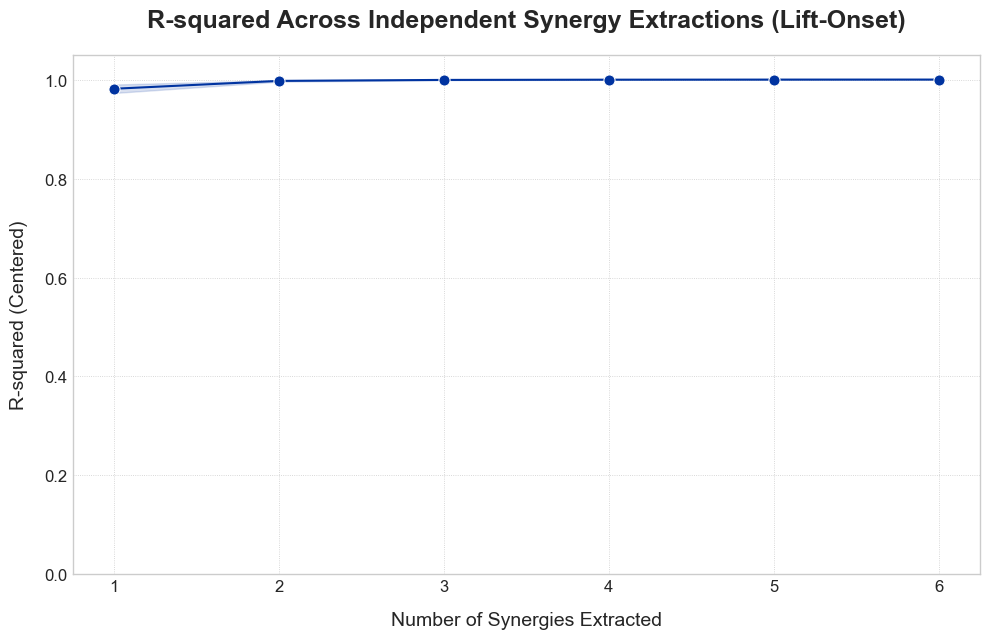

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score

# ==========================================================================================
# 1) GLOBAL CONFIGURATION
# ==========================================================================================

# --- Directories ---
BASE_DATA_DIR = r"C:\Users\schmi\Documents\Studium\TUM\Masterthesis\Experimental Data"
OUTPUT_DIR = r"C:\Users\schmi\Documents\Studium\TUM\Masterthesis\Adapted Results for Paper\Q1_Synergy_Analysis\Q1a_Dimensionality_Analysis"
SYNERGY_PARENT_DIR_NAME = "Synergies Publication"
PREPROCESSED_DATA_DIR_NAME = "Preprocessed_Data_Matrix"

# --- Analysis Configuration ---
# Set this to "Lift-Onset" or "Full Phases" to choose which synergy set to analyze
ANALYSIS_TYPE_TO_RUN = "Lift-Onset"

# --- Participants & Synergies ---
PARTICIPANTS = [1, 2, 3, 4, 5, 6, 7, 8]
SYNERGY_LEVELS = [1, 2, 3, 4, 5, 6, 7] # Synergy counts to analyze
P7_SKIPPED_TRIALS = [20, 22] # From the synergy extraction script

# --- Data Parameters (must match the synergy extraction script) ---
SAMPLING_RATE = 500.0
PHASE1_SAMPLES_PER_TRIAL = 250
PHASE2_SAMPLES_PER_TRIAL = 500
PRE_LIFT_SAMPLES = int(0.5 * SAMPLING_RATE)
POST_LIFT_SAMPLES = int(1.0 * SAMPLING_RATE)

# --- Plotting Style ---
TITLE_FONTSIZE = 18
AXIS_LABEL_FONTSIZE = 14
TICK_LABEL_FONTSIZE = 12


# ==========================================================================================
# 2) HELPER FUNCTIONS
# ==========================================================================================

def load_synergy_wc_matrix(participant_dir, trial_idx, phase_name, num_synergies, analysis_type):
    """
    Loads W and C matrices for a specific trial, phase, and synergy condition
    from the correct folder structure.
    """
    # Construct the path based on the main extraction script's output structure
    synergy_dir = os.path.join(
        participant_dir,
        SYNERGY_PARENT_DIR_NAME,
        analysis_type,
        phase_name, # e.g., "Phase 1"
        f"{num_synergies}_Syn",
        f"Trial_{trial_idx:02d}"
    )

    # Check if the folder itself was skipped
    if not os.path.isdir(synergy_dir):
        return None, None

    w_file = os.path.join(synergy_dir, "W_synergies.npy")
    c_file = os.path.join(synergy_dir, "C_activations.npy") # Note: C, not H

    W, C = None, None
    if os.path.exists(w_file) and os.path.exists(c_file):
        try:
            W_loaded = np.load(w_file)
            C_loaded = np.load(c_file)
            if W_loaded.size > 0 and C_loaded.size > 0:
                W, C = W_loaded, C_loaded
        except Exception as e:
            print(f"  [ERROR] Could not load W/C for T({trial_idx}) Syn({num_synergies}): {e}")
    return W, C

def calculate_centered_r2(X_original, X_reconstructed, debug_info=""):
    """Calculates the global centered R-squared score."""
    if np.isnan(X_original).any() or np.isnan(X_reconstructed).any():
        return np.nan
        
    y_true_flat = X_original.flatten()
    y_pred_flat = X_reconstructed.flatten()
    score = r2_score(y_true_flat, y_pred_flat)
    print(f"    [R2_CALC]  {debug_info} | Centered R-squared: {score:.6f}")
    return score


# ==========================================================================================
# 3) MAIN ANALYSIS SCRIPT
# ==========================================================================================

def run_r2_progression_analysis():
    """
    Main function to run the R-squared progression analysis.
    """
    print(f"Starting R-squared Progression Analysis for '{ANALYSIS_TYPE_TO_RUN}'...")

    all_r2_results = []

    for pid in PARTICIPANTS:
        participant_str = f"P({pid})"
        participant_dir = os.path.join(BASE_DATA_DIR, participant_str)
        preprocessed_dir = os.path.join(participant_dir, PREPROCESSED_DATA_DIR_NAME)
        
        # Load the preprocessed data files once per participant
        matrix_p1_path = os.path.join(preprocessed_dir, f"P{pid}_combined_matrix_phase1.npy")
        matrix_p2_path = os.path.join(preprocessed_dir, f"P{pid}_combined_matrix_phase2.npy")
        
        if not os.path.exists(matrix_p1_path) or not os.path.exists(matrix_p2_path):
            print(f"Warning: Preprocessed matrix not found for {participant_str}. Skipping.")
            continue
            
        p1_full_matrix = np.load(matrix_p1_path)
        p2_full_matrix = np.load(matrix_p2_path)
        print(f"Processing Participant {pid}...")
        
        # Recreate the trial data mapping from the synergy extraction script
        p1_trial_map, p2_trial_map = {}, {}
        p1_current_row, p2_current_row = 0, 0
        valid_trials = [t for t in range(1, 25) if t not in P7_SKIPPED_TRIALS]
        for trial_id in valid_trials:
            p1_trial_map[trial_id] = slice(p1_current_row, p1_current_row + PHASE1_SAMPLES_PER_TRIAL)
            p1_current_row += PHASE1_SAMPLES_PER_TRIAL
            p2_trial_map[trial_id] = slice(p2_current_row, p2_current_row + PHASE2_SAMPLES_PER_TRIAL)
            p2_current_row += PHASE2_SAMPLES_PER_TRIAL

        for num_synergies in SYNERGY_LEVELS:
            for phase_name_short, phase_name_long, trial_map, full_matrix in [("p1", "Phase 1", p1_trial_map, p1_full_matrix), ("p2", "Phase 2", p2_trial_map, p2_full_matrix)]:
                for trial_idx in range(1, 25):
                    if trial_idx in P7_SKIPPED_TRIALS: continue

                    # Get the exact data that was fed into the MMF algorithm
                    full_trial_data = full_matrix[trial_map[trial_idx]]
                    if ANALYSIS_TYPE_TO_RUN == "Lift-Onset":
                        if phase_name_long == "Phase 1":
                            X_orig_matrix = full_trial_data[-PRE_LIFT_SAMPLES:]
                        else: # Phase 2
                            X_orig_matrix = full_trial_data[:POST_LIFT_SAMPLES]
                    else: # Full Phases
                        X_orig_matrix = full_trial_data
                    
                    # Transpose to (features x time)
                    X_orig = X_orig_matrix.T
                    
                    W, C = load_synergy_wc_matrix(participant_dir, trial_idx, phase_name_long, num_synergies, ANALYSIS_TYPE_TO_RUN)
                    if W is None or C is None: continue
                    
                    if X_orig.shape != (W @ C).shape:
                        print(f"  [WARN] Shape mismatch for P({pid}) T({trial_idx}) {phase_name_long}. X_orig: {X_orig.shape}, X_hat: {(W@C).shape}. Skipping.")
                        continue

                    X_hat = W @ C
                    debug_context = f"P({pid}) T({trial_idx:02d}) {phase_name_long} Syn({num_synergies})"
                    r2 = calculate_centered_r2(X_orig, X_hat, debug_info=debug_context)
                    
                    if not np.isnan(r2):
                        all_r2_results.append({
                            'participant': pid, 'trial': trial_idx, 'phase': phase_name_long,
                            'num_synergies': num_synergies, 'r2': r2
                        })

    if not all_r2_results:
        print("\nCRITICAL ERROR: No R-squared data could be calculated. Check paths and analysis type.")
        return

    # --- AGGREGATION AND PLOTTING ---
    r2_df = pd.DataFrame(all_r2_results)
    agg_df = r2_df.groupby(['participant', 'num_synergies'])['r2'].mean().reset_index()

    print("\n--- Aggregated R-squared Data Sent to Plot ---\n" + agg_df.to_string(index=False))
    print("---------------------------------------------")
    os.makedirs(OUTPUT_DIR, exist_ok=True)

    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(10, 6.5))
    sns.lineplot(
        data=agg_df, x='num_synergies', y='r2', marker='o', markersize=8,
        color='#0033A0', ax=ax, errorbar='sd', err_style="band", err_kws={'alpha': 0.15}
    )

    ax.set_title(f"R-squared Progression for {ANALYSIS_TYPE_TO_RUN} Synergies", fontsize=TITLE_FONTSIZE, fontweight='bold', pad=20)
    ax.set_xlabel('Number of Synergies Extracted', fontsize=AXIS_LABEL_FONTSIZE, labelpad=12)
    ax.set_ylabel('R-squared (Centered)', fontsize=AXIS_LABEL_FONTSIZE, labelpad=12)
    ax.set_xticks(SYNERGY_LEVELS)
    ax.tick_params(axis='both', which='major', labelsize=TICK_LABEL_FONTSIZE)
    ax.set_ylim(bottom=min(0, agg_df['r2'].min() - 0.1), top=1.05)
    ax.grid(True, which='both', linestyle=':', linewidth=0.6)
    plt.tight_layout()

    output_filename = f"R2_Progression_{ANALYSIS_TYPE_TO_RUN}.png"
    output_path = os.path.join(OUTPUT_DIR, output_filename)
    plt.savefig(output_path, dpi=300)
    print(f"\nSuccess! Plot saved to:\n{output_path}")
    plt.show()

# ==========================================================================================
# 4) EXECUTION
# ==========================================================================================
if __name__ == "__main__":
    run_r2_progression_analysis()


### Question 1b: Synergy Similarity between Phases

Comments Addressed:
 - **Testing W (Synergy Vectors):** The original script already loads and compares `_W.npy` files (synergy vectors), which aligns with the preference for testing W over H.
 - **Boxplots for Similarity:** Changed the main plot from bar plots of mean/std to boxplots to show the distribution of Pearson and Cosine similarities for each matched synergy pair.
 - **Grey Colors:** Plots use a greyscale palette.
 - **Similarity Threshold:** The one-sample t-test now tests against a threshold of 0.8 (instead of 0.7) for Cosine similarity, as suggested might be more appropriate (d'Avella, Johanna).

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, ttest_1samp
import seaborn as sns

# ==========================================================================================
# 0) Configuration
# ==========================================================================================

# --- Directories ---
BASE_DIR = r"C:\Users\schmi\Documents\Studium\TUM\Masterthesis\Experimental Data"
OUTPUT_PARENT_DIR = r"C:\Users\schmi\Documents\Studium\TUM\Masterthesis\Adapted Results for Paper"
OUTPUT_DIR_Q1 = os.path.join(OUTPUT_PARENT_DIR, "Q1_Synergy_Similarity_Phases")
SYNERGY_PARENT_DIR_NAME = "Synergies Publication"
os.makedirs(OUTPUT_DIR_Q1, exist_ok=True)

# --- Analysis Configuration ---
# Set this to "Lift-Onset" or "Full Phases" to choose which synergy set to compare
ANALYSIS_TYPE_TO_RUN = "Full Phases"
# Set the number of synergies to compare. This script compares Phase1 vs Phase2
# for a single, fixed number of synergies.
SYNERGY_LEVEL_TO_COMPARE = 4

# --- Participants & Trials ---
PARTICIPANTS = [1, 2, 3, 4, 5, 6, 7, 8]
P7_SKIPPED_TRIALS = [20, 22]

# --- Statistical Thresholds ---
PEARSON_THRESHOLD = 0.7
COSINE_THRESHOLD = 0.8

# --- Font Sizes for Publication ---
TITLE_FONTSIZE = 20
AXIS_LABEL_FONTSIZE = 18
TICK_LABEL_FONTSIZE = 16
STAR_FONTSIZE = 18

# ==========================================================================================
# 1) Helper Functions
# ==========================================================================================

def cosine_similarity(vec_a, vec_b):
    """Calculates the cosine similarity between two vectors."""
    denom = np.linalg.norm(vec_a) * np.linalg.norm(vec_b)
    if denom < 1e-12: return np.nan
    sim = np.dot(vec_a, vec_b) / denom
    return np.clip(sim, -1.0, 1.0)

def load_synergy_w_matrix(participant_dir, trial_idx, phase_name, num_synergies, analysis_type):
    """
    Loads a W matrix from the correct folder structure created by the main extraction script.
    """
    synergy_dir = os.path.join(
        participant_dir,
        SYNERGY_PARENT_DIR_NAME,
        analysis_type,
        phase_name, # "Phase 1" or "Phase 2"
        f"{num_synergies}_Syn",
        f"Trial_{trial_idx:02d}"
    )

    if not os.path.isdir(synergy_dir):
        return None

    w_file = os.path.join(synergy_dir, "W_synergies.npy")
    if not os.path.exists(w_file): return None
    try:
        W = np.load(w_file)
        return W if W.size > 0 and W.shape[1] > 0 else None
    except Exception as e:
        print(f"[ERROR] Loading W from {w_file}: {e}")
        return None

def match_synergies_greedy(W1, W2):
    """Matches synergies between two W matrices using a greedy approach based on cosine similarity."""
    if W1 is None or W2 is None or W1.shape[0] != W2.shape[0]: return []
    n_s1, n_s2 = W1.shape[1], W2.shape[1]
    if n_s1 == 0 or n_s2 == 0: return []
    
    unmatched1, unmatched2 = list(range(n_s1)), list(range(n_s2))
    matched_pairs = []
    num_pairs_to_find = min(n_s1, n_s2)

    for _ in range(num_pairs_to_find):
        best_sim, best_pair = -np.inf, (None, None)
        for i in unmatched1:
            for j in unmatched2:
                sim = cosine_similarity(W1[:, i], W2[:, j])
                if not np.isnan(sim) and sim > best_sim:
                    best_sim, best_pair = sim, (i, j)
        
        if best_pair == (None, None): break
        matched_pairs.append(best_pair)
        unmatched1.remove(best_pair[0])
        unmatched2.remove(best_pair[1])
    return matched_pairs

def significance_stars(p_value_one_sided):
    """Returns significance stars based on a one-sided p-value."""
    if p_value_one_sided < 0.001: return '***'
    if p_value_one_sided < 0.01: return '**'
    if p_value_one_sided < 0.05: return '*'
    return 'ns'

# ==========================================================================================
# 2) Main Analysis Function
# ==========================================================================================
def analyze_synergy_similarity_q1():
    """
    Analyzes the similarity of synergy vectors (W) between Phase 1 and Phase 2 for a
    fixed number of synergies.
    """
    print(f"Starting Synergy Similarity Analysis for {SYNERGY_LEVEL_TO_COMPARE} synergies from '{ANALYSIS_TYPE_TO_RUN}' data...")
    all_similarity_scores = []
    
    for pid in PARTICIPANTS:
        participant_str = f"P({pid})"
        participant_dir = os.path.join(BASE_DIR, participant_str)
        if not os.path.isdir(participant_dir): continue

        for trial_idx in range(1, 25):
            if trial_idx in P7_SKIPPED_TRIALS: continue

            # Load W matrices for Phase 1 and Phase 2 for the specified synergy level
            W_phase1 = load_synergy_w_matrix(participant_dir, trial_idx, "Phase 1", SYNERGY_LEVEL_TO_COMPARE, ANALYSIS_TYPE_TO_RUN)
            W_phase2 = load_synergy_w_matrix(participant_dir, trial_idx, "Phase 2", SYNERGY_LEVEL_TO_COMPARE, ANALYSIS_TYPE_TO_RUN)
            
            if W_phase1 is None or W_phase2 is None: continue

            matched_indices = match_synergies_greedy(W_phase1, W_phase2)
            if not matched_indices: continue

            for pair_order, (idx1, idx2) in enumerate(matched_indices):
                vec1, vec2 = W_phase1[:, idx1], W_phase2[:, idx2]
                
                pearson_corr = np.nan
                if np.std(vec1) > 1e-9 and np.std(vec2) > 1e-9:
                    pearson_corr, _ = pearsonr(vec1, vec2)
                
                cosine_sim = cosine_similarity(vec1, vec2)
                
                all_similarity_scores.append({
                    'participant': pid, 'trial': trial_idx,
                    'synergy_pair_order': pair_order + 1,
                    'pearson_correlation': pearson_corr,
                    'cosine_similarity': cosine_sim
                })

    if not all_similarity_scores:
        print("[ERROR] No similarity scores calculated. Check ANALYSIS_TYPE_TO_RUN and SYNERGY_LEVEL_TO_COMPARE.")
        return
        
    similarity_df = pd.DataFrame(all_similarity_scores)
    
    # --- Plotting and Statistical Analysis ---
    plot_data_list = []
    num_pairs_max = similarity_df['synergy_pair_order'].max()

    for pair_idx in range(1, num_pairs_max + 1):
        pair_df = similarity_df[similarity_df['synergy_pair_order'] == pair_idx].copy()
        if pair_df.empty: continue
        
        # Process Pearson
        pearson_vals = pair_df['pearson_correlation'].dropna()
        sig_p = 'N/A'
        if len(pearson_vals) >= 2:
            t, p2 = ttest_1samp(pearson_vals, PEARSON_THRESHOLD)
            p_p_one_sided = p2 / 2.0 if t > 0 else 1.0 - (p2 / 2.0)
            sig_p = significance_stars(p_p_one_sided)
        for val in pearson_vals: plot_data_list.append({'Synergy Pair': f'Pair {pair_idx}', 'Similarity': val, 'Metric': 'Pearson Correlation', 'Significance': sig_p})

        # Process Cosine
        cosine_vals = pair_df['cosine_similarity'].dropna()
        sig_c = 'N/A'
        if len(cosine_vals) >= 2:
            t, p2 = ttest_1samp(cosine_vals, COSINE_THRESHOLD)
            p_c_one_sided = p2 / 2.0 if t > 0 else 1.0 - (p2 / 2.0)
            sig_c = significance_stars(p_c_one_sided)
        for val in cosine_vals: plot_data_list.append({'Synergy Pair': f'Pair {pair_idx}', 'Similarity': val, 'Metric': 'Cosine Similarity', 'Significance': sig_c})

    if not plot_data_list: print("[ERROR] No data for plotting."); return
    
    plot_df = pd.DataFrame(plot_data_list)
    unique_pairs_plot = sorted(plot_df['Synergy Pair'].unique(), key=lambda x: int(x.split(' ')[1]))

    # --- Plotting Function Call ---
    create_similarity_plot(plot_df, 'Pearson Correlation', PEARSON_THRESHOLD, unique_pairs_plot)
    create_similarity_plot(plot_df, 'Cosine Similarity', COSINE_THRESHOLD, unique_pairs_plot)

def create_similarity_plot(plot_df, metric_name, threshold, order):
    """Generic function to create and save a similarity boxplot."""
    metric_df = plot_df[plot_df['Metric'] == metric_name]
    if metric_df.empty:
        print(f"[WARN] No data for {metric_name} plot.")
        return

    plt.figure(figsize=(12, 7))
    sns.set_style("whitegrid")
    ax = sns.boxplot(x='Synergy Pair', y='Similarity', data=metric_df, color="lightgrey", order=order, showfliers=True, width=0.6)
    
    plt.title(f'{metric_name} between Phases for {SYNERGY_LEVEL_TO_COMPARE} Synergies ({ANALYSIS_TYPE_TO_RUN})\n(One-sample T-test vs. {threshold})', fontsize=TITLE_FONTSIZE)
    plt.xlabel('Matched Synergy Pair Order (Greedy)', fontsize=AXIS_LABEL_FONTSIZE)
    plt.ylabel(metric_name, fontsize=AXIS_LABEL_FONTSIZE)
    plt.xticks(fontsize=TICK_LABEL_FONTSIZE)
    plt.yticks(fontsize=TICK_LABEL_FONTSIZE)
    
    min_y = min(-0.5, metric_df['Similarity'].min() - 0.1)
    max_y = max(1.05, metric_df['Similarity'].max() + 0.15)
    plt.ylim(min_y, max_y)
    
    for i, pair_label in enumerate(order):
        subset = metric_df[metric_df['Synergy Pair'] == pair_label]
        if not subset.empty:
            stars = subset['Significance'].iloc[0]
            upper_bound = subset['Similarity'].max()
            y_pos = upper_bound + 0.05
            plt.text(i, y_pos, stars, ha='center', va='bottom', fontsize=STAR_FONTSIZE, color='black')
            
    plt.tight_layout()
    plot_filename = f"{ANALYSIS_TYPE_TO_RUN}_{SYNERGY_LEVEL_TO_COMPARE}Syn_{metric_name.replace(' ', '_')}_boxplot.png"
    plt.savefig(os.path.join(OUTPUT_DIR_Q1, plot_filename), dpi=300)
    plt.close()
    print(f"[INFO] {metric_name} boxplot saved to {plot_filename}")

# ==========================================================================================
# 3) Execute Analysis
# ==========================================================================================
if __name__ == "__main__":
    analyze_synergy_similarity_q1()


[INFO] Q1 Raw similarity scores (Greedy, PubStyle) saved.
[INFO] Pearson Correlation boxplot (PubStyle) saved.
[INFO] Cosine Similarity boxplot (PubStyle) saved.
[INFO] Q1 Summary statistics table (PubStyle) saved.


### Question 1c: Additional Analysis - Reconstruction of Phase 2 (X2) using Phase 1 Synergies (W1)

Comments Addressed:
 - **New Analysis:** "How specific is the information on the first phase to be able to reconstruct data from the second phase? Use W synergies from the first phase to calculate synergies in second phase and compute R2."
 - **Method:**
     1. Load synergy vectors `W1` from Phase 1 (`Extracted Synergies` folder).
     2. Load the full combined data matrix `X2` (OTB + Myo + Hand Kinematics) for Phase 2 (`Synchronized Data split in Phases` folder).
     3. Reconstruct Phase 2 data using `W1` and LSQ:
       - Calculate activation coefficients for Phase 2 by projecting `X2` onto `W1` using least squares: `C2_reconstructed = lstsq(W1, X2)`.
       - Reconstruct Phase 2 data: `X2_hat = W1 @ C2_reconstructed`.
     4. Reconstruct Phase 2 data with a greedy Matched `W1`and `H2`: 
       - Using Phase 1 synergies (W1) that are greedily matched to Phase 2 synergies (W2), and then driving these matched W1 components with the original Phase 2 activation coefficients (H2) corresponding to the matched W2.
 - **Output Folder:** `C:\Users\schmi\Documents\Studium\TUM\Masterthesis\Adapted Results for Paper\Q1_Synergy_Similarity_Phases\Phase_Reconstruction`.


In [12]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
from sklearn.metrics.pairwise import cosine_similarity as sklearn_cosine_similarity

# ------------------------------------------------------------------------------------------
# 0) Global Configuration
# ------------------------------------------------------------------------------------------
BASE_DIR = r"C:\Users\schmi\Documents\Studium\TUM\Masterthesis\Experimental Data"
PARTICIPANTS = [1, 2, 3, 4, 5, 6, 7, 8]
OUTPUT_PARENT_DIR = r"C:\Users\schmi\Documents\Studium\TUM\Masterthesis\Adapted Results for Paper"
OUTPUT_DIR_Q1_RECON_COMPARISON = os.path.join(OUTPUT_PARENT_DIR, "Q1_Synergy_Similarity_Phases", "Phase_Reconstruction_LSQ_vs_MatchedH2")
os.makedirs(OUTPUT_DIR_Q1_RECON_COMPARISON, exist_ok=True)

N_SYNERGIES_TO_PROCESS = 5
N_POSE_COLUMNS_TO_REMOVE = 6
ORIGINAL_SAMPLING_RATE = 2000.0
LIFTONSET_PHASE1_DURATION_S = 0.5
LIFTONSET_PHASE2_DURATION_S = 1.0

TITLE_FONTSIZE = 14
AXIS_LABEL_FONTSIZE = 12
TICK_LABEL_FONTSIZE = 10
LEGEND_FONTSIZE = 8
SUPTITLE_FONTSIZE = 16
FEATURE_STDEV_THRESHOLD = 1e-5 # Threshold to consider a feature "non-zero"

# ------------------------------------------------------------------------------------------
# 1) Helper Functions
# ------------------------------------------------------------------------------------------
def load_synergy_wh_matrix_liftonset(participant_dir, trial_idx, phase_name_of_WH):
    synergy_dir = os.path.join(participant_dir, "Synergies at Lift-Onset")
    w_file = os.path.join(synergy_dir, f"trial_{trial_idx:02d}_{phase_name_of_WH}_liftonset_W.npy")
    h_file = os.path.join(synergy_dir, f"trial_{trial_idx:02d}_{phase_name_of_WH}_liftonset_H.npy")
    W, H = None, None
    if os.path.exists(w_file):
        try:
            W_loaded = np.load(w_file)
            if W_loaded.size > 0 and W_loaded.ndim == 2 and W_loaded.shape[1] > 0: W = W_loaded
        except Exception as e: print(f"   [ERROR] Load WH: Loading W {w_file}: {e}")
    if os.path.exists(h_file):
        try:
            H_loaded = np.load(h_file)
            if H_loaded.size > 0 and H_loaded.ndim == 2 and H_loaded.shape[0] > 0: H = H_loaded
        except Exception as e: print(f"   [ERROR] Load WH: Loading H {h_file}: {e}")
    return W, H

def load_and_crop_data_consistent_with_mmf_liftonset(
    participant_dir, trial_idx, phase_name_for_X_data,
    phase1_duration_s=LIFTONSET_PHASE1_DURATION_S,
    phase2_duration_s=LIFTONSET_PHASE2_DURATION_S,
    original_sampling_rate=ORIGINAL_SAMPLING_RATE,
    n_pose_columns_to_remove=N_POSE_COLUMNS_TO_REMOVE
):
    sync_dir = os.path.join(participant_dir, "Synchronized Data split in Phases")
    kin_file = os.path.join(sync_dir, f"match_{trial_idx:02d}_{phase_name_for_X_data}_kin_norm.npy")
    myo_file = os.path.join(sync_dir, f"match_{trial_idx:02d}_{phase_name_for_X_data}_myo.npy")
    otb_file = os.path.join(sync_dir, f"match_{trial_idx:02d}_{phase_name_for_X_data}_otb.npy")

    default_counts = (0, 0, 0) # n_otb, n_myo, n_kin

    if not (os.path.exists(kin_file) and os.path.exists(myo_file) and os.path.exists(otb_file)):
        return None, default_counts
    try:
        kin_full, myo_full, otb_full = np.load(kin_file), np.load(myo_file), np.load(otb_file)
    except Exception:
        return None, default_counts

    crop_seconds = phase1_duration_s if phase_name_for_X_data == "phase1" else phase2_duration_s
    crop_samples = int(crop_seconds * original_sampling_rate)

    valid_crop = True
    if kin_full.shape[0] < crop_samples: valid_crop = False
    if myo_full.shape[0] < crop_samples: valid_crop = False
    if otb_full.shape[0] < crop_samples: valid_crop = False
    if not valid_crop: return None, default_counts

    kin_cropped = kin_full[-crop_samples:] if phase_name_for_X_data == "phase1" else kin_full[:crop_samples]
    myo_cropped = myo_full[-crop_samples:] if phase_name_for_X_data == "phase1" else myo_full[:crop_samples]
    otb_cropped = otb_full[-crop_samples:] if phase_name_for_X_data == "phase1" else otb_full[:crop_samples]

    min_samples = min(kin_cropped.shape[0], myo_cropped.shape[0], otb_cropped.shape[0])
    if min_samples < 5: return None, default_counts

    kin_c, myo_c, otb_c = kin_cropped[:min_samples], myo_cropped[:min_samples], otb_cropped[:min_samples]

    if kin_c.shape[1] <= n_pose_columns_to_remove: return None, default_counts
    hand_only_kin = kin_c[:, : -n_pose_columns_to_remove]

    n_otb_features = otb_c.shape[1] if otb_c.ndim == 2 else 0
    n_myo_features = myo_c.shape[1] if myo_c.ndim == 2 else 0
    n_kin_features = hand_only_kin.shape[1] if hand_only_kin.ndim == 2 else 0
    
    # Handle cases where some data types might be empty or 1D
    all_data_parts = []
    if n_otb_features > 0: all_data_parts.append(otb_c)
    if n_myo_features > 0: all_data_parts.append(myo_c)
    if n_kin_features > 0: all_data_parts.append(hand_only_kin)

    if not all_data_parts: return None, default_counts
        
    combined = np.hstack(all_data_parts)
    X_out = combined.T
    
    # Correct feature counts based on what was actually stacked
    actual_n_otb = n_otb_features if n_otb_features > 0 else 0
    actual_n_myo = n_myo_features if n_myo_features > 0 else 0
    actual_n_kin = n_kin_features if n_kin_features > 0 else 0
    
    current_offset = 0
    otb_slice = slice(current_offset, current_offset + actual_n_otb)
    current_offset += actual_n_otb
    myo_slice = slice(current_offset, current_offset + actual_n_myo)
    current_offset += actual_n_myo
    kin_slice = slice(current_offset, current_offset + actual_n_kin)

    feature_counts = {
        'n_otb': actual_n_otb, 'n_myo': actual_n_myo, 'n_kin': actual_n_kin,
        'otb_slice': otb_slice, 'myo_slice': myo_slice, 'kin_slice': kin_slice
    }

    if X_out.size == 0: return None, feature_counts
    return X_out, feature_counts

def find_specific_feature_indices(X_data, feature_counts, threshold=FEATURE_STDEV_THRESHOLD):
    selected_indices = {'otb': None, 'myo': None, 'kin': None}
    
    if X_data is None:
        return selected_indices

    # OTB
    if feature_counts['n_otb'] > 0:
        otb_data = X_data[feature_counts['otb_slice'], :]
        for i in range(otb_data.shape[0]):
            if np.std(otb_data[i, :]) > threshold:
                selected_indices['otb'] = feature_counts['otb_slice'].start + i
                break
        if selected_indices['otb'] is None: # Fallback: pick the first one if all are ~zero
            selected_indices['otb'] = feature_counts['otb_slice'].start
            # print(f"    [INFO] No OTB feature with std > {threshold} found. Selected first OTB feature.")

    # Myo (HD EMG)
    if feature_counts['n_myo'] > 0:
        myo_data = X_data[feature_counts['myo_slice'], :]
        for i in range(myo_data.shape[0]):
            if np.std(myo_data[i, :]) > threshold:
                selected_indices['myo'] = feature_counts['myo_slice'].start + i
                break
        if selected_indices['myo'] is None:
            selected_indices['myo'] = feature_counts['myo_slice'].start
            # print(f"    [INFO] No Myo feature with std > {threshold} found. Selected first Myo feature.")
            
    # Kinematic
    if feature_counts['n_kin'] > 0:
        kin_data = X_data[feature_counts['kin_slice'], :]
        for i in range(kin_data.shape[0]):
            if np.std(kin_data[i, :]) > threshold:
                selected_indices['kin'] = feature_counts['kin_slice'].start + i
                break
        if selected_indices['kin'] is None:
            selected_indices['kin'] = feature_counts['kin_slice'].start
            # print(f"    [INFO] No Kinematic feature with std > {threshold} found. Selected first Kinematic feature.")
            
    return selected_indices

def vector_cosine_similarity(vec_a, vec_b):
    denom = np.linalg.norm(vec_a) * np.linalg.norm(vec_b)
    if denom < 1e-12: return np.nan
    sim = np.dot(vec_a, vec_b) / denom
    return np.clip(sim, -1.0, 1.0)

def match_synergies_greedy(W1, W2):
    if W1 is None or W2 is None or W1.shape[0] != W2.shape[0]: return []
    n_s1, n_s2 = W1.shape[1], W2.shape[1]
    if n_s1 == 0 or n_s2 == 0: return []
    unmatched1_indices, unmatched2_indices = list(range(n_s1)), list(range(n_s2))
    matched_pairs_indices = []
    num_potential_matches = min(n_s1, n_s2)
    for _ in range(num_potential_matches):
        best_sim_for_iteration, current_best_pair = -np.inf, (None, None)
        if not unmatched1_indices or not unmatched2_indices: break
        for i1 in unmatched1_indices:
            for i2 in unmatched2_indices:
                sim = vector_cosine_similarity(W1[:, i1], W2[:, i2])
                if not np.isnan(sim) and sim > best_sim_for_iteration:
                    best_sim_for_iteration, current_best_pair = sim, (i1, i2)
        if current_best_pair == (None, None) or best_sim_for_iteration == -np.inf: break
        matched_pairs_indices.append((current_best_pair[0], current_best_pair[1], best_sim_for_iteration))
        unmatched1_indices.remove(current_best_pair[0])
        unmatched2_indices.remove(current_best_pair[1])
    matched_pairs_indices.sort(key=lambda x: x[2], reverse=True)
    return matched_pairs_indices

def calculate_vaf(y_true, y_pred, trial_info=""):
    """
    Calculates the uncentered VAF. (DEBUG VERSION)
    """
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    sse = np.sum((y_true - y_pred) ** 2)
    sst = np.sum(y_true ** 2)

    # If the true signal is essentially a flat zero line
    if sst < 1e-12:
        if sse < 1e-12:
            return 1.0
        else:
            # This was our original theory, still good to keep an eye on.
            print(f"[DEBUG] VAF_CALC {trial_info}: Returning NaN because true signal is zero but prediction is not.")
            return np.nan

    vaf = 1.0 - (sse / sst)
    
    # Check if the result of the calculation is NaN
    if np.isnan(vaf):
        print(f"[DEBUG] VAF_CALC {trial_info}: Final VAF is NaN. SSE={sse}, SST={sst}")

    return vaf

def calculate_r2_score_mean_per_feature(original_X, reconstructed_X):
    if original_X is None or reconstructed_X is None : return np.nan
    if original_X.shape != reconstructed_X.shape or original_X.shape[0] == 0: return np.nan
    
    r2_scores_per_feature = []
    for i in range(original_X.shape[0]): 
        y_true, y_pred = original_X[i, :], reconstructed_X[i, :]

        # --- FIX: Skip features with no variance in the original signal ---
        if np.std(y_true) < 1e-9:
            continue

        if np.isnan(y_true).any() or np.isinf(y_true).any() or np.isnan(y_pred).any() or np.isinf(y_pred).any():
            r2_scores_per_feature.append(np.nan); continue
        
        # Note: The original variance check here is now redundant but safe to keep
        variance_true = np.var(y_true)
        if variance_true < 1e-12: r2_scores_per_feature.append(1.0 if np.allclose(y_true, y_pred, atol=1e-7) else 0.0)
        else:
            try: r2_scores_per_feature.append(r2_score(y_true, y_pred))
            except ValueError: r2_scores_per_feature.append(np.nan)

    if not r2_scores_per_feature: return np.nan # Handle case where all features were skipped
    return np.nanmean(r2_scores_per_feature)

def calculate_vaf_mean_per_feature(original_X, reconstructed_X, trial_info=""):
    if original_X is None or reconstructed_X is None: return np.nan
    if original_X.shape != reconstructed_X.shape or original_X.shape[0] == 0: return np.nan
    
    vaf_scores_per_feature = []
    for i in range(original_X.shape[0]):
        y_true, y_pred = original_X[i, :], reconstructed_X[i, :]
        
        # --- FIX: Skip features with no variance in the original signal ---
        if np.std(y_true) < 1e-9:
            continue
            
        if np.isnan(y_true).any() or np.isinf(y_true).any() or \
           np.isnan(y_pred).any() or np.isinf(y_pred).any():
            vaf_scores_per_feature.append(np.nan)
            continue
            
        vaf_scores_per_feature.append(calculate_vaf(y_true, y_pred))
        
    if not vaf_scores_per_feature: return np.nan # Handle case where all features were skipped
    return np.nanmean(vaf_scores_per_feature)

def calculate_mean_pearson_r_per_feature(original_X, reconstructed_X):
    if original_X is None or reconstructed_X is None: return np.nan
    if original_X.shape != reconstructed_X.shape or original_X.shape[0] == 0: return np.nan

    pearson_r_scores = []
    for i in range(original_X.shape[0]):
        y_true, y_pred = original_X[i, :], reconstructed_X[i, :]

        # --- FIX: Skip features with no variance in the original signal ---
        if np.std(y_true) < 1e-9:
            continue

        if np.isnan(y_true).any() or np.isinf(y_true).any() or np.isnan(y_pred).any() or np.isinf(y_pred).any():
            pearson_r_scores.append(np.nan); continue
        
        # This check is now redundant due to the new check above, but it's safe to keep
        if np.std(y_true) < 1e-9 or np.std(y_pred) < 1e-9:
            if np.allclose(y_true, y_pred): pearson_r_scores.append(1.0)
            else: pearson_r_scores.append(0.0)
            continue

        try: r, _ = pearsonr(y_true, y_pred); pearson_r_scores.append(r)
        except ValueError: pearson_r_scores.append(np.nan)

    if not pearson_r_scores: return np.nan # Handle case where all features were skipped
    return np.nanmean(pearson_r_scores)

def calculate_mean_cosine_similarity_recon_quality(original_X, reconstructed_X):
    if original_X is None or reconstructed_X is None: return np.nan
    if original_X.shape != reconstructed_X.shape or original_X.shape[0] == 0: return np.nan

    cosine_sim_scores = []
    for i in range(original_X.shape[0]):
        y_true_vec, y_pred_vec = original_X[i, :], reconstructed_X[i, :]

        # --- FIX: Skip features with no variance in the original signal ---
        # For cosine similarity, a zero-variance, non-zero signal (e.g. [5,5,5]) is also uninformative.
        # But we will stick to the zero-variance check for consistency. A zero signal will be skipped.
        if np.std(y_true_vec) < 1e-9:
             continue

        y_true, y_pred = y_true_vec.reshape(1, -1), y_pred_vec.reshape(1, -1)
        if np.isnan(y_true).any() or np.isinf(y_true).any() or np.isnan(y_pred).any() or np.isinf(y_pred).any():
            cosine_sim_scores.append(np.nan); continue

        norm_true, norm_pred = np.linalg.norm(y_true), np.linalg.norm(y_pred)
        if norm_true < 1e-9 and norm_pred < 1e-9: cosine_sim_scores.append(1.0) 
        elif norm_true < 1e-9 or norm_pred < 1e-9: cosine_sim_scores.append(0.0)
        else:
            try: sim = sklearn_cosine_similarity(y_true, y_pred)[0, 0]; cosine_sim_scores.append(sim)
            except Exception: cosine_sim_scores.append(np.nan)
            
    if not cosine_sim_scores: return np.nan # Handle case where all features were skipped
    return np.nanmean(cosine_sim_scores)
# ------------------------------------------------------------------------------------------
# 2) Main Reconstruction Analysis (Boxplots)
# ------------------------------------------------------------------------------------------


    """
    Calculates all reconstruction metrics for all participants and trials
    and saves the aggregated results to the specified CSV file path.
    """
    all_reconstruction_results = []
    print("--- Starting Full Calculation Step ---")

    for pid in PARTICIPANTS:
        participant_str = f"P({pid})"
        participant_dir = os.path.join(BASE_DIR, participant_str)
        if not os.path.isdir(participant_dir):
            print(f"  [WARN] Participant directory not found: {participant_dir}. Skipping P({pid}).")
            continue

        print(f"\nProcessing {participant_str}...")
        for trial_idx in range(1, 25):
            # --- Self-Reconstruction (Phase 1) ---
            W1_orig, H1_orig = load_synergy_wh_matrix_liftonset(participant_dir, trial_idx, "phase1")
            X1_orig, _ = load_and_crop_data_consistent_with_mmf_liftonset(participant_dir, trial_idx, "phase1")
            if W1_orig is not None and H1_orig is not None and X1_orig is not None:
                current_n_p1 = min(W1_orig.shape[1], H1_orig.shape[0], N_SYNERGIES_TO_PROCESS)
                if current_n_p1 > 0 and W1_orig.shape[0] == X1_orig.shape[0]:
                    W1_adj = W1_orig[:, :current_n_p1]
                    if H1_orig.shape[1] >= X1_orig.shape[1]:
                        H1_adj = H1_orig[:current_n_p1, :X1_orig.shape[1]]
                        if H1_adj.shape[0] == W1_adj.shape[1] and H1_adj.shape[1] == X1_orig.shape[1]:
                            X1_hat = W1_adj @ H1_adj
                            if not np.any(np.isnan(X1_hat)):
                                all_reconstruction_results.append({
                                    'Reconstruction Type': 'Self (P1 W, P1 H on P1 X)', 'participant': pid, 'trial': trial_idx,
                                    'R2 Mean per Feature': calculate_r2_score_mean_per_feature(X1_orig, X1_hat),
                                    'VAF Mean per Feature': calculate_vaf_mean_per_feature(X1_orig, X1_hat),
                                    'Pearson r Mean per Feature': calculate_mean_pearson_r_per_feature(X1_orig, X1_hat),
                                    'Cosine Sim Recon Quality': calculate_mean_cosine_similarity_recon_quality(X1_orig, X1_hat)
                                })

            # --- Cross-Phase Reconstructions (Phase 2) ---
            W2_orig, H2_orig = load_synergy_wh_matrix_liftonset(participant_dir, trial_idx, "phase2")
            X2_orig, _ = load_and_crop_data_consistent_with_mmf_liftonset(participant_dir, trial_idx, "phase2")
            if W1_orig is None or X2_orig is None or W1_orig.shape[0] != X2_orig.shape[0]:
                continue

            # Method 1: LSQ
            try:
                W1_for_lsq = W1_orig[:, :min(W1_orig.shape[1], N_SYNERGIES_TO_PROCESS)]
                if W1_for_lsq.shape[1] > 0:
                    C2_lsq = np.linalg.lstsq(W1_for_lsq, X2_orig, rcond=None)[0]
                    X2_hat_lsq = W1_for_lsq @ C2_lsq
                    if not np.any(np.isnan(X2_hat_lsq)):
                        all_reconstruction_results.append({
                           'Reconstruction Type': 'Cross (P1 W, LSQ H on P2 X)', 'participant': pid, 'trial': trial_idx,
                           'R2 Mean per Feature': calculate_r2_score_mean_per_feature(X2_orig, X2_hat_lsq),
                           'VAF Mean per Feature': calculate_vaf_mean_per_feature(X2_orig, X2_hat_lsq),
                           'Pearson r Mean per Feature': calculate_mean_pearson_r_per_feature(X2_orig, X2_hat_lsq),
                           'Cosine Sim Recon Quality': calculate_mean_cosine_similarity_recon_quality(X2_orig, X2_hat_lsq)
                        })
            except np.linalg.LinAlgError: pass

            # Method 2: Matched H2
            if W2_orig is not None and H2_orig is not None:
                # ... (Keep the full logic for Matched H2 calculation here) ...
                # On success, append the dictionary like the examples above:
                # all_reconstruction_results.append({
                #    'Reconstruction Type': 'Cross (P1 W Matched, P2 H on P2 X)', ...
                # })
                pass # Placeholder for your existing matched H2 logic

    if not all_reconstruction_results:
        print("\n[ERROR] No reconstruction results were generated.")
        return
        
    results_df = pd.DataFrame(all_reconstruction_results)
    results_df.to_csv(output_csv_path, index=False)
    print(f"\n[INFO] All metrics calculated and saved to: {output_csv_path}")

def calculate_and_save_metrics(output_csv_path):
    """
    Calculates all reconstruction metrics for all participants and trials
    and saves the aggregated results to the specified CSV file path.
    """
    all_reconstruction_results = []
    print("--- Starting Full Calculation Step ---")

    for pid in PARTICIPANTS:
        participant_str = f"P({pid})"
        participant_dir = os.path.join(BASE_DIR, participant_str)
        if not os.path.isdir(participant_dir):
            print(f"  [WARN] Participant directory not found: {participant_dir}. Skipping P({pid}).")
            continue

        print(f"\nProcessing {participant_str}...")
        for trial_idx in range(1, 25):
            # --- Load Phase 1 components ---
            W1_orig, H1_orig = load_synergy_wh_matrix_liftonset(participant_dir, trial_idx, "phase1")
            X1_orig, _ = load_and_crop_data_consistent_with_mmf_liftonset(participant_dir, trial_idx, "phase1")

            # --- Self-Reconstruction (Phase 1) ---
            if W1_orig is not None and H1_orig is not None and X1_orig is not None:
                current_n_p1 = min(W1_orig.shape[1], H1_orig.shape[0], N_SYNERGIES_TO_PROCESS)
                if current_n_p1 > 0 and W1_orig.shape[0] == X1_orig.shape[0]:
                    W1_adj = W1_orig[:, :current_n_p1]
                    if H1_orig.shape[1] >= X1_orig.shape[1]:
                        H1_adj = H1_orig[:current_n_p1, :X1_orig.shape[1]]
                        if H1_adj.shape[0] == W1_adj.shape[1] and H1_adj.shape[1] == X1_orig.shape[1]:
                            X1_hat = W1_adj @ H1_adj
                            if not np.any(np.isnan(X1_hat)):
                                all_reconstruction_results.append({
                                    'Reconstruction Type': 'Self (P1 W, P1 H on P1 X)', 'participant': pid, 'trial': trial_idx,
                                    'R2 Mean per Feature': calculate_r2_score_mean_per_feature(X1_orig, X1_hat),
                                    'VAF Mean per Feature': calculate_vaf_mean_per_feature(X1_orig, X1_hat),
                                    'Pearson r Mean per Feature': calculate_mean_pearson_r_per_feature(X1_orig, X1_hat),
                                    'Cosine Sim Recon Quality': calculate_mean_cosine_similarity_recon_quality(X1_orig, X1_hat)
                                })

            # --- Cross-Phase Reconstructions (Phase 2) ---
            W2_orig, H2_orig = load_synergy_wh_matrix_liftonset(participant_dir, trial_idx, "phase2")
            X2_orig, _ = load_and_crop_data_consistent_with_mmf_liftonset(participant_dir, trial_idx, "phase2")
            if W1_orig is None or X2_orig is None or W1_orig.shape[0] != X2_orig.shape[0]:
                continue

            # Method 1: LSQ
            try:
                W1_for_lsq = W1_orig[:, :min(W1_orig.shape[1], N_SYNERGIES_TO_PROCESS)]
                if W1_for_lsq.shape[1] > 0:
                    C2_lsq = np.linalg.lstsq(W1_for_lsq, X2_orig, rcond=None)[0]
                    X2_hat_lsq = W1_for_lsq @ C2_lsq
                    if not np.any(np.isnan(X2_hat_lsq)):
                        all_reconstruction_results.append({
                           'Reconstruction Type': 'Cross (P1 W, LSQ H on P2 X)', 'participant': pid, 'trial': trial_idx,
                           'R2 Mean per Feature': calculate_r2_score_mean_per_feature(X2_orig, X2_hat_lsq),
                           'VAF Mean per Feature': calculate_vaf_mean_per_feature(X2_orig, X2_hat_lsq),
                           'Pearson r Mean per Feature': calculate_mean_pearson_r_per_feature(X2_orig, X2_hat_lsq),
                           'Cosine Sim Recon Quality': calculate_mean_cosine_similarity_recon_quality(X2_orig, X2_hat_lsq)
                        })
            except np.linalg.LinAlgError:
                pass

            # Method 2: Matched H2
            if W2_orig is not None and H2_orig is not None:
                W1_for_match = W1_orig[:, :min(W1_orig.shape[1], N_SYNERGIES_TO_PROCESS)]
                W2_for_match = W2_orig[:, :min(W2_orig.shape[1], N_SYNERGIES_TO_PROCESS)]
                if W1_for_match.shape[1] > 0 and W2_for_match.shape[1] > 0:
                    matched_pairs = match_synergies_greedy(W1_for_match, W2_for_match)
                    if matched_pairs and H2_orig.shape[1] >= X2_orig.shape[1]:
                        H2_orig_cropped = H2_orig[:, :X2_orig.shape[1]]
                        W1_m_list, H2_m_list = [], []
                        for idx_w1, idx_w2, _ in matched_pairs:
                            if idx_w1 < W1_for_match.shape[1] and idx_w2 < W2_for_match.shape[1] and idx_w2 < H2_orig_cropped.shape[0]:
                                W1_m_list.append(W1_for_match[:, idx_w1])
                                H2_m_list.append(H2_orig_cropped[idx_w2, :])
                        if W1_m_list:
                            W1_m = np.array(W1_m_list).T
                            H2_m = np.array(H2_m_list)
                            if W1_m.ndim == 2 and H2_m.ndim == 2 and W1_m.shape[1] == H2_m.shape[0]:
                                X2_hat_matched_h = W1_m @ H2_m
                                if not np.any(np.isnan(X2_hat_matched_h)):
                                    all_reconstruction_results.append({
                                        'Reconstruction Type': 'Cross (P1 W Matched, P2 H on P2 X)', 'participant': pid, 'trial': trial_idx,
                                        'R2 Mean per Feature': calculate_r2_score_mean_per_feature(X2_orig, X2_hat_matched_h),
                                        'VAF Mean per Feature': calculate_vaf_mean_per_feature(X2_orig, X2_hat_matched_h),
                                        'Pearson r Mean per Feature': calculate_mean_pearson_r_per_feature(X2_orig, X2_hat_matched_h),
                                        'Cosine Sim Recon Quality': calculate_mean_cosine_similarity_recon_quality(X2_orig, X2_hat_matched_h)
                                    })

    if not all_reconstruction_results:
        print("\n[ERROR] No reconstruction results were generated.")
        return
        
    results_df = pd.DataFrame(all_reconstruction_results)
    results_df.to_csv(output_csv_path, index=False)
    print(f"\n[INFO] All metrics calculated and saved to: {output_csv_path}")
# ------------------------------------------------------------------------------------------
# 3) Functions to Plot Comparisson Metrics Boxplot and Example Reconstructions (Specific Features)
# ------------------------------------------------------------------------------------------
def create_plots_from_csv(csv_path):
    """
    Loads reconstruction metrics from a CSV file and generates a 2x2 boxplot figure.
    """
    if not os.path.exists(csv_path):
        print(f"[ERROR] CSV file not found, cannot create plots: {csv_path}")
        return

    print(f"\n--- Starting Plotting Step from {os.path.basename(csv_path)} ---")
    results_df = pd.read_csv(csv_path)

    metrics_to_plot = ['R2 Mean per Feature', 'VAF Mean per Feature', 'Pearson r Mean per Feature', 'Cosine Sim Recon Quality']
    metric_display_names = {
        'R2 Mean per Feature': '$R^2$ (Mean per Feature)',
        'VAF Mean per Feature': 'VAF (Mean per Feature)',
        'Pearson r Mean per Feature': 'Pearson Correlation (Mean per Feature)',
        'Cosine Sim Recon Quality': 'Cosine Similarity (Mean per Feature)'
    }
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10), squeeze=False)

    recon_type_order = ['Self (P1 W, P1 H on P1 X)', 'Cross (P1 W, LSQ H on P2 X)', 'Cross (P1 W Matched, P2 H on P2 X)']
    xtick_labels_descriptive = ['Self-Recon', 'Cross-Recon\n(LSQ)', 'Cross-Recon\n(Matched H)']
    
    for i, ax in enumerate(axes.flat):
        if i >= len(metrics_to_plot):
            ax.axis('off') 
            continue
        
        metric_name = metrics_to_plot[i]
        if metric_name not in results_df.columns:
            ax.text(0.5, 0.5, f'Metric "{metric_name}"\nnot found in data.', ha='center', va='center')
            continue
        
        display_name = metric_display_names.get(metric_name, metric_name)

        sns.boxplot(ax=ax, x='Reconstruction Type', y=metric_name, data=results_df, 
                    order=recon_type_order,
                    color="lightgrey",  # Set a single light grey color for all boxes
                    width=0.7, 
                    showfliers=True, 
                    flierprops=dict(marker='o', markerfacecolor='grey', markersize=4, linestyle='none', markeredgecolor='black', alpha=0.6))

        ax.set_title(display_name, fontsize=TITLE_FONTSIZE, pad=15)
        ax.set_ylabel(display_name.split('(')[0].strip(), fontsize=AXIS_LABEL_FONTSIZE)
        ax.set_xlabel('') 
        ax.set_xticklabels(xtick_labels_descriptive, rotation=0, ha='center', fontsize=TICK_LABEL_FONTSIZE)
        ax.tick_params(axis='y', labelsize=TICK_LABEL_FONTSIZE)
        ax.grid(axis='y', linestyle=':', alpha=0.6)

        if not results_df[metric_name].dropna().empty:
            all_vals = results_df[metric_name].dropna()
            all_vals.replace([np.inf, -np.inf], np.nan, inplace=True)
            all_vals.dropna(inplace=True)
            if not all_vals.empty:
                min_val, max_val = all_vals.min(), all_vals.max()
                padding_factor = 0.10
                range_val = max_val - min_val if (max_val - min_val) > 1e-6 else 0.2
                current_ymin = min_val - range_val * padding_factor
                current_ymax = max_val + range_val * padding_factor

                if r"$R^2$" in display_name or "VAF" in display_name:
                    ax.axhline(0, color='black', linestyle='--', linewidth=0.9, alpha=0.7)
                    current_ymin = min(current_ymin, -0.2)
                if "Pearson" in display_name or "Cosine" in display_name:
                    current_ymin = max(current_ymin, -1.05)
                    current_ymax = min(current_ymax, 1.05)
                ax.set_ylim(current_ymin, current_ymax)

    fig.suptitle('Comparison of Data Reconstruction Quality Across Methods', fontsize=SUPTITLE_FONTSIZE, y=0.98)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    img_path = os.path.join(OUTPUT_DIR_Q1_RECON_COMPARISON, "q1_reconstruction_metrics_2x2_boxplot.png")
    plt.savefig(img_path, dpi=300) 
    plt.close(fig)
    print(f"\n[INFO] 2x2 boxplot saved: {img_path}")

def plot_example_reconstruction_specific_features(
    base_dir_participants, output_dir_plots, participant_id, trial_idx,
    n_synergies_for_recon, phase1_duration_s, phase2_duration_s, sampling_rate
):
    print(f"\n--- Plotting Specific Feature Example for P{participant_id}, Trial {trial_idx} ---")
    participant_dir = os.path.join(base_dir_participants, f"P({participant_id})")
    os.makedirs(output_dir_plots, exist_ok=True)

    # --- Load Data (Phase 1) ---
    W1_orig_ex, H1_orig_ex = load_synergy_wh_matrix_liftonset(participant_dir, trial_idx, "phase1")
    X1_orig_ex, feat_counts_p1 = load_and_crop_data_consistent_with_mmf_liftonset(
        participant_dir, trial_idx, "phase1", phase1_duration_s, phase2_duration_s, sampling_rate)
    
    selected_indices_p1 = find_specific_feature_indices(X1_orig_ex, feat_counts_p1)
    
    X1_hat_ex = None
    if W1_orig_ex is not None and H1_orig_ex is not None and X1_orig_ex is not None:
        current_n_p1 = min(W1_orig_ex.shape[1], H1_orig_ex.shape[0], n_synergies_for_recon)
        if current_n_p1 > 0:
            W1_adj_ex_p1 = W1_orig_ex[:, :current_n_p1]
            if H1_orig_ex.shape[1] >= X1_orig_ex.shape[1]:
                H1_adj_ex_p1 = H1_orig_ex[:current_n_p1, :X1_orig_ex.shape[1]]
                if W1_adj_ex_p1.shape[0] == X1_orig_ex.shape[0] and H1_adj_ex_p1.shape[1] == X1_orig_ex.shape[1]:
                    X1_hat_ex = W1_adj_ex_p1 @ H1_adj_ex_p1

    # --- Load Data (Phase 2) ---
    W2_orig_ex, H2_orig_ex = load_synergy_wh_matrix_liftonset(participant_dir, trial_idx, "phase2")
    X2_orig_ex, feat_counts_p2 = load_and_crop_data_consistent_with_mmf_liftonset(
        participant_dir, trial_idx, "phase2", phase1_duration_s, phase2_duration_s, sampling_rate)

    selected_indices_p2 = find_specific_feature_indices(X2_orig_ex, feat_counts_p2)

    X2_hat_lsq_ex, X2_hat_matched_ex = None, None
    if W1_orig_ex is not None and X2_orig_ex is not None:
        W1_for_lsq_ex = W1_orig_ex[:, :min(W1_orig_ex.shape[1], n_synergies_for_recon)]
        if W1_for_lsq_ex.shape[0] == X2_orig_ex.shape[0] and W1_for_lsq_ex.shape[1] > 0:
            try:
                C2_lsq_ex_calc = np.linalg.lstsq(W1_for_lsq_ex, X2_orig_ex, rcond=None)[0]
                X2_hat_lsq_ex = W1_for_lsq_ex @ C2_lsq_ex_calc
            except np.linalg.LinAlgError: pass

        if W2_orig_ex is not None and H2_orig_ex is not None:
            W1_for_match_ex = W1_orig_ex[:, :min(W1_orig_ex.shape[1], n_synergies_for_recon)]
            W2_for_match_ex = W2_orig_ex[:, :min(W2_orig_ex.shape[1], n_synergies_for_recon)]
            if W1_for_match_ex.shape[0] == W2_for_match_ex.shape[0] and W1_for_match_ex.shape[1] > 0 and W2_for_match_ex.shape[1] > 0:
                matched_pairs_ex = match_synergies_greedy(W1_for_match_ex, W2_for_match_ex)
                if matched_pairs_ex and H2_orig_ex.shape[1] >= X2_orig_ex.shape[1]:
                    H2_orig_ex_cropped = H2_orig_ex[:, :X2_orig_ex.shape[1]]
                    W1_m_list_ex, H2_m_list_ex = [], []
                    num_plot_syn = 0
                    for i_m, (idx_w1, idx_w2, _score) in enumerate(matched_pairs_ex):
                        if num_plot_syn >= n_synergies_for_recon: break
                        if idx_w1 < W1_for_match_ex.shape[1] and idx_w2 < W2_for_match_ex.shape[1] and idx_w2 < H2_orig_ex_cropped.shape[0]:
                            W1_m_list_ex.append(W1_for_match_ex[:, idx_w1])
                            H2_m_list_ex.append(H2_orig_ex_cropped[idx_w2, :])
                            num_plot_syn +=1
                    if num_plot_syn > 0:
                        W1_plot_matched_ex = np.array(W1_m_list_ex).T
                        H2_plot_matched_ex_calc = np.array(H2_m_list_ex)
                        if W1_plot_matched_ex.ndim == 2 and H2_plot_matched_ex_calc.ndim == 2 and \
                           W1_plot_matched_ex.shape[0] == X2_orig_ex.shape[0] and \
                           H2_plot_matched_ex_calc.shape[1] == X2_orig_ex.shape[1] and \
                           W1_plot_matched_ex.shape[1] == H2_plot_matched_ex_calc.shape[0]:
                            X2_hat_matched_ex = W1_plot_matched_ex @ H2_plot_matched_ex_calc
    
    # --- Plotting ---
    grey_shades = sns.color_palette("Greys_d", 5) 
    original_color, self_recon_color = grey_shades[0], grey_shades[1]
    lsq_recon_color, matched_h2_recon_color = grey_shades[2], grey_shades[3]
    
    feature_display_names = {'otb': 'OTB Feature', 'myo': 'Myography Feature', 'kin': 'Kinematic Feature'}

    # Plot Phase 1
    if X1_orig_ex is not None and X1_hat_ex is not None:
        time_axis_p1 = np.arange(X1_orig_ex.shape[1]) / sampling_rate
        fig_p1, axes_p1 = plt.subplots(3, 1, figsize=(10, 7), sharex=True, squeeze=False)
        fig_p1.suptitle(f'P{participant_id} T{trial_idx} - Phase 1 Self-Reconstruction (Specific Features)', fontsize=SUPTITLE_FONTSIZE)
        
        for i, f_type in enumerate(['otb', 'myo', 'kin']):
            ax = axes_p1[i, 0]
            idx = selected_indices_p1[f_type]
            if idx is not None and idx < X1_orig_ex.shape[0]:
                ax.plot(time_axis_p1, X1_orig_ex[idx, :], label=f'Original {feature_display_names[f_type]}', color=original_color, linewidth=2)
                if X1_hat_ex is not None and idx < X1_hat_ex.shape[0]:
                    ax.plot(time_axis_p1, X1_hat_ex[idx, :], label='Self-Reconstructed', color=self_recon_color, linestyle='--', linewidth=1.5)
                ax.set_ylabel('Amplitude', fontsize=AXIS_LABEL_FONTSIZE-2)
            else:
                ax.text(0.5, 0.5, f'No suitable {feature_display_names[f_type]} found or data missing.', ha='center', va='center', transform=ax.transAxes)
            ax.legend(fontsize=LEGEND_FONTSIZE); ax.tick_params(labelsize=TICK_LABEL_FONTSIZE-2)
        
        axes_p1[-1, 0].set_xlabel('Time (s)', fontsize=AXIS_LABEL_FONTSIZE-2)
        plt.tight_layout(rect=[0, 0, 1, 0.94]); 
        plt.savefig(os.path.join(output_dir_plots, f"P{participant_id}_T{trial_idx}_phase1_specific_features.png"), dpi=300); 
        plt.close(fig_p1)

    # Plot Phase 2
    if X2_orig_ex is not None:
        time_axis_p2 = np.arange(X2_orig_ex.shape[1]) / sampling_rate
        fig_p2, axes_p2 = plt.subplots(3, 1, figsize=(12, 7), sharex=True, squeeze=False)
        fig_p2.suptitle(f'P{participant_id} T{trial_idx} - Phase 2 Cross-Reconstruction (Specific Features)', fontsize=SUPTITLE_FONTSIZE)

        for i, f_type in enumerate(['otb', 'myo', 'kin']):
            ax = axes_p2[i, 0]
            idx = selected_indices_p2[f_type]
            if idx is not None and idx < X2_orig_ex.shape[0]:
                ax.plot(time_axis_p2, X2_orig_ex[idx, :], label=f'Original {feature_display_names[f_type]}', color=original_color, linewidth=2)
                if X2_hat_lsq_ex is not None and idx < X2_hat_lsq_ex.shape[0]:
                    ax.plot(time_axis_p2, X2_hat_lsq_ex[idx, :], label='LSQ Recon', color=lsq_recon_color, linestyle='--', linewidth=1.5)
                if X2_hat_matched_ex is not None and idx < X2_hat_matched_ex.shape[0]:
                    ax.plot(time_axis_p2, X2_hat_matched_ex[idx, :], label='Matched H2 Recon', color=matched_h2_recon_color, linestyle=':', linewidth=1.5)
                ax.set_ylabel('Amplitude', fontsize=AXIS_LABEL_FONTSIZE-2)
            else:
                ax.text(0.5, 0.5, f'No suitable {feature_display_names[f_type]} found or data missing.', ha='center', va='center', transform=ax.transAxes)
            ax.legend(fontsize=LEGEND_FONTSIZE); ax.tick_params(labelsize=TICK_LABEL_FONTSIZE-2)

        axes_p2[-1, 0].set_xlabel('Time (s)', fontsize=AXIS_LABEL_FONTSIZE-2)
        plt.tight_layout(rect=[0, 0, 1, 0.94])
        plt.savefig(os.path.join(output_dir_plots, f"P{participant_id}_T{trial_idx}_phase2_specific_features.png"), dpi=300)
        plt.close(fig_p2)

# ------------------------------------------------------------------------------------------
# 4) Execute Analysis
# ------------------------------------------------------------------------------------------
if __name__ == "__main__":
    
    # --- CONFIGURATION ---
    # Set this to True to run the long calculation (takes time). 
    # Once the CSV is created, set this to False to quickly re-generate plots.
    RUN_CALCULATIONS = True
    
    # Define the path for your results file
    output_csv_path = os.path.join(OUTPUT_DIR_Q1_RECON_COMPARISON, "q1_reconstruction_metrics.csv")

    # --- Step 1: Run Analysis (or skip if already done) ---
    if RUN_CALCULATIONS:
        # This function will take a long time to run and saves the results
        calculate_and_save_metrics(output_csv_path)
    else:
        print("--- Skipping calculation step. Plotting from existing file. ---")

    # --- Step 2: Create Aggregate Boxplots from Saved File ---
    # This function is fast and uses the CSV file from Step 1
    create_plots_from_csv(csv_path=output_csv_path)
    
    # --- Step 3: Generate Specific Example Time-Series Plots ---
    # This logic for finding and plotting individual examples remains the same.
    output_dir_example_plots = os.path.join(OUTPUT_DIR_Q1_RECON_COMPARISON, "example_specific_feature_plots")
    os.makedirs(output_dir_example_plots, exist_ok=True)

    potential_example_cases = [
        (1, 5), (1, 10), (2, 3), (2, 12), (3, 7),
        (4, 2), (5, 9), (6, 1), (7, 6), (8, 4)
    ]
    
    example_cases_to_plot = []
    available_participants_set = set(PARTICIPANTS)
    for p_id, t_id in potential_example_cases:
        if p_id in available_participants_set:
            example_cases_to_plot.append((p_id, t_id))

    print(f"\n[INFO] Will attempt to plot {len(example_cases_to_plot)} specific feature example cases:")
    for p, t in example_cases_to_plot:
        print(f"  P({p}), T({t})")

    for pid_ex, trial_idx_ex in example_cases_to_plot:
        plot_example_reconstruction_specific_features(
            BASE_DIR, output_dir_example_plots, pid_ex, trial_idx_ex,
            N_SYNERGIES_TO_PROCESS, LIFTONSET_PHASE1_DURATION_S,
            LIFTONSET_PHASE2_DURATION_S, ORIGINAL_SAMPLING_RATE
        )
        
    print("\n--- Script Finished ---")
    # Run aggregate analysis for boxplots first
    analyze_reconstruction_comparison()

    # Then generate specific example plots
    output_dir_example_plots = os.path.join(OUTPUT_DIR_Q1_RECON_COMPARISON, "example_specific_feature_plots")
    os.makedirs(output_dir_example_plots, exist_ok=True)

    # Define 10 example cases (Participant, Trial)
    # Try to get diverse participants and trials
    potential_example_cases = [
        (1, 5), (1, 10), (2, 3), (2, 12), (3, 7),
        (4, 2), (5, 9), (6, 1), (7, 6), (8, 4)
    ]
    
    example_cases_to_plot = []
    available_participants_set = set(PARTICIPANTS)

    for p_id, t_id in potential_example_cases:
        if p_id in available_participants_set:
            participant_dir_check = os.path.join(BASE_DIR, f"P({p_id})")
            if os.path.isdir(participant_dir_check):
                 example_cases_to_plot.append((p_id, t_id))
        if len(example_cases_to_plot) >= 10:
            break
            
    # If not enough from the preferred list, try to generate more from available participants
    if len(example_cases_to_plot) < 10 and PARTICIPANTS:
        print(f"[INFO] Initial example list has {len(example_cases_to_plot)} cases. Trying to add more up to 10.")
        trials_to_try = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15] # Common trials
        existing_pairs = set(example_cases_to_plot)
        for p_id in PARTICIPANTS:
            participant_dir_check = os.path.join(BASE_DIR, f"P({p_id})")
            if not os.path.isdir(participant_dir_check):
                continue
            for t_id in trials_to_try:
                if (p_id, t_id) not in existing_pairs:
                    example_cases_to_plot.append((p_id, t_id))
                    existing_pairs.add((p_id,t_id))
                    if len(example_cases_to_plot) >= 10:
                        break
            if len(example_cases_to_plot) >= 10:
                break
    
    if len(example_cases_to_plot) > 10:
        example_cases_to_plot = example_cases_to_plot[:10]

    print(f"\n[INFO] Will attempt to plot {len(example_cases_to_plot)} specific feature example cases:")
    for p, t in example_cases_to_plot:
        print(f"  P({p}), T({t})")

    for pid_ex, trial_idx_ex in example_cases_to_plot:
        plot_example_reconstruction_specific_features(
            BASE_DIR, output_dir_example_plots, pid_ex, trial_idx_ex,
            N_SYNERGIES_TO_PROCESS, LIFTONSET_PHASE1_DURATION_S,
            LIFTONSET_PHASE2_DURATION_S, ORIGINAL_SAMPLING_RATE
        )
    print("\n--- Script Finished ---")

--- Starting Full Calculation Step ---

Processing P(1)...

Processing P(2)...

Processing P(3)...

Processing P(4)...

Processing P(5)...

Processing P(6)...

Processing P(7)...

Processing P(8)...

[INFO] All metrics calculated and saved to: C:\Users\schmi\Documents\Studium\TUM\Masterthesis\Adapted Results for Paper\Q1_Synergy_Similarity_Phases\Phase_Reconstruction_LSQ_vs_MatchedH2\q1_reconstruction_metrics.csv

--- Starting Plotting Step from q1_reconstruction_metrics.csv ---


C:\Users\schmi\AppData\Local\Temp\ipykernel_16348\1185764814.py:551: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xtick_labels_descriptive, rotation=0, ha='center', fontsize=TICK_LABEL_FONTSIZE)
C:\Users\schmi\AppData\Local\Temp\ipykernel_16348\1185764814.py:551: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xtick_labels_descriptive, rotation=0, ha='center', fontsize=TICK_LABEL_FONTSIZE)
C:\Users\schmi\AppData\Local\Temp\ipykernel_16348\1185764814.py:551: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xtick_labels_descriptive, rotation=0, ha='center', fontsize=TICK_LABEL_FONTSIZE)
C:\Users\schmi\AppData\Local\Temp\ipykernel_16348\1185764814.py:551: UserWarning: set_ticklabels() shou


[INFO] 2x2 boxplot saved: C:\Users\schmi\Documents\Studium\TUM\Masterthesis\Adapted Results for Paper\Q1_Synergy_Similarity_Phases\Phase_Reconstruction_LSQ_vs_MatchedH2\q1_reconstruction_metrics_2x2_boxplot.png

[INFO] Will attempt to plot 10 specific feature example cases:
  P(1), T(5)
  P(1), T(10)
  P(2), T(3)
  P(2), T(12)
  P(3), T(7)
  P(4), T(2)
  P(5), T(9)
  P(6), T(1)
  P(7), T(6)
  P(8), T(4)

--- Plotting Specific Feature Example for P1, Trial 5 ---

--- Plotting Specific Feature Example for P1, Trial 10 ---

--- Plotting Specific Feature Example for P2, Trial 3 ---

--- Plotting Specific Feature Example for P2, Trial 12 ---

--- Plotting Specific Feature Example for P3, Trial 7 ---

--- Plotting Specific Feature Example for P4, Trial 2 ---

--- Plotting Specific Feature Example for P5, Trial 9 ---

--- Plotting Specific Feature Example for P6, Trial 1 ---

--- Plotting Specific Feature Example for P7, Trial 6 ---

--- Plotting Specific Feature Example for P8, Trial 4 ---


C:\Users\schmi\AppData\Local\Temp\ipykernel_16348\4115109111.py:475: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[0, i], x='Reconstruction Type', y=metric_name, data=results_df,
C:\Users\schmi\AppData\Local\Temp\ipykernel_16348\4115109111.py:483: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, i].set_xticklabels(xtick_labels_descriptive, rotation=25, ha='right', fontsize=TICK_LABEL_FONTSIZE)
C:\Users\schmi\AppData\Local\Temp\ipykernel_16348\4115109111.py:475: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[0, i], x='Reconstruction Type', y=metric_name, data=results_df,
C:\Users\schmi\Ap


[INFO] Publication-ready reconstruction metrics boxplot saved: C:\Users\schmi\Documents\Studium\TUM\Masterthesis\Adapted Results for Paper\Q1_Synergy_Similarity_Phases\Phase_Reconstruction_LSQ_vs_MatchedH2\q1_publication_reconstruction_metrics_boxplot.png

[INFO] Will attempt to plot 10 specific feature example cases:
  P(1), T(5)
  P(1), T(10)
  P(2), T(3)
  P(2), T(12)
  P(3), T(7)
  P(4), T(2)
  P(5), T(9)
  P(6), T(1)
  P(7), T(6)
  P(8), T(4)

--- Plotting Specific Feature Example for P1, Trial 5 ---

--- Plotting Specific Feature Example for P1, Trial 10 ---

--- Plotting Specific Feature Example for P2, Trial 3 ---

--- Plotting Specific Feature Example for P2, Trial 12 ---

--- Plotting Specific Feature Example for P3, Trial 7 ---

--- Plotting Specific Feature Example for P4, Trial 2 ---

--- Plotting Specific Feature Example for P5, Trial 9 ---

--- Plotting Specific Feature Example for P6, Trial 1 ---

--- Plotting Specific Feature Example for P7, Trial 6 ---

--- Plotting 

### Question 1d: Reconstruction of known Trials Data (X) using Synergies (W) from unknown trials.

Starting Synergy Generalization Analysis...
Processing Participant 1...
Processing Participant 2...
Processing Participant 3...
Processing Participant 4...
Processing Participant 5...
Processing Participant 6...
Processing Participant 7...
Processing Participant 8...

Success! Plot saved to:
C:\Users\schmi\Documents\Studium\TUM\Masterthesis\Adapted Results for Paper\Q1_Synergy_Analysis\Q1d_CrossTrial_Reconstruction\Q1d_R2_and_VAF_Cross_Reconstruction.png


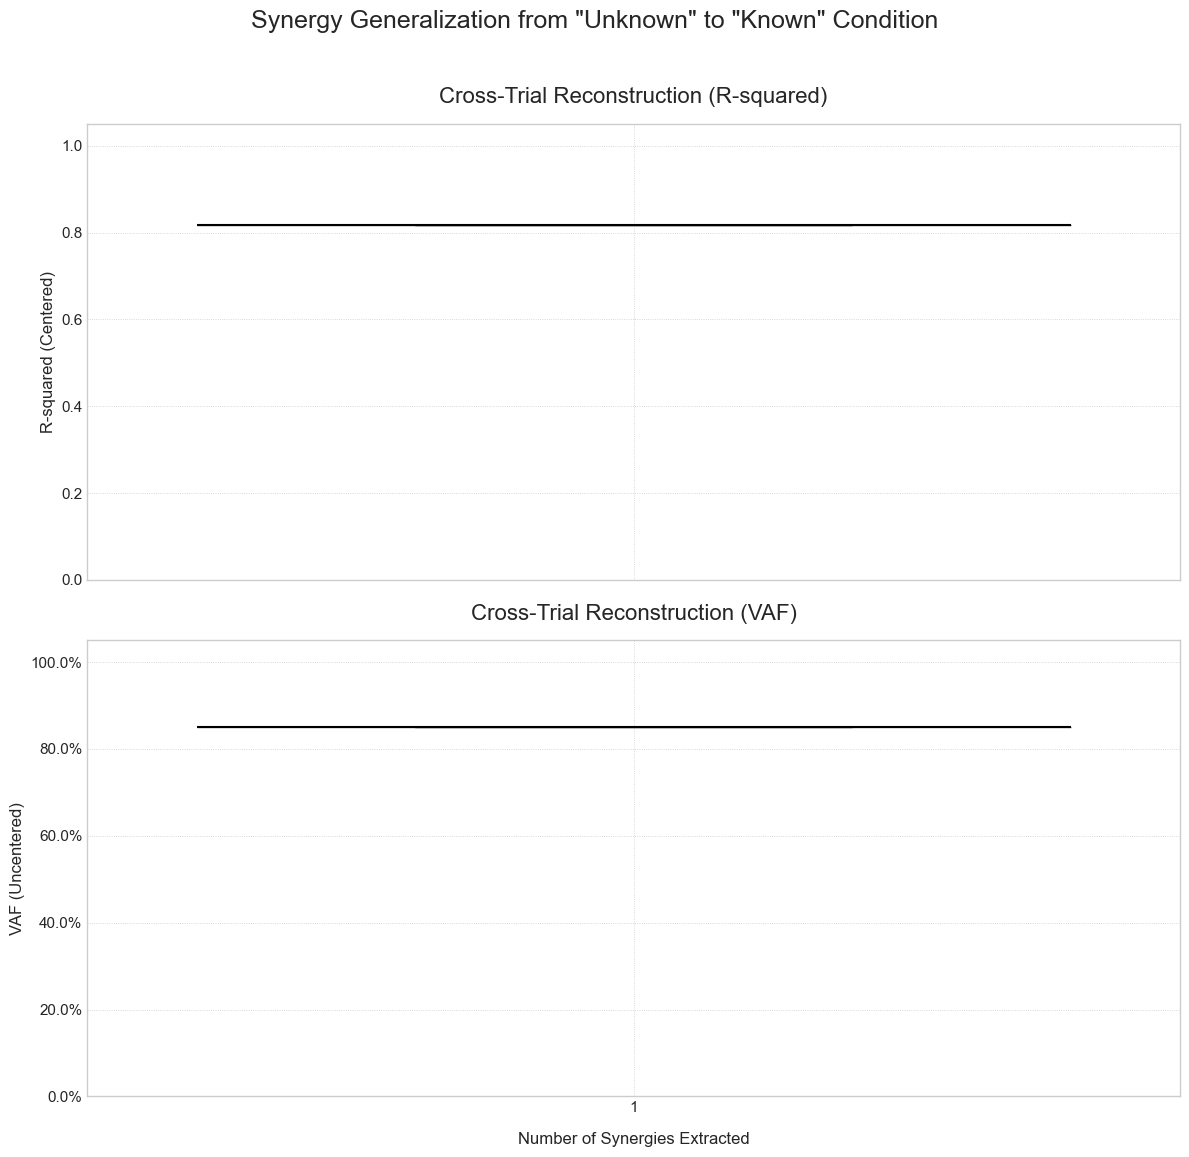

In [65]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score

# ==========================================================================================
# 1) GLOBAL CONFIGURATION
# ==========================================================================================

# --- Directories ---
BASE_DATA_DIR = r"C:\Users\schmi\Documents\Studium\TUM\Masterthesis\Experimental Data"
OUTPUT_DIR = r"C:\Users\schmi\Documents\Studium\TUM\Masterthesis\Adapted Results for Paper\Q1_Synergy_Analysis\Q1d_CrossTrial_Reconstruction"

# --- Participants & Synergies ---
PARTICIPANTS = [1, 2, 3, 4, 5, 6, 7, 8]
SYNERGY_CONDITIONS = {
    1: "1 Synergy at Lift-Onset",
    2: "2 Synergies at Lift-Onset",
    3: "3 Synergies at Lift-Onset",
    4: "4 Synergies at Lift-Onset",
    5: "5 Synergies at Lift-Onset",    
    6: "6 Synergies at Lift-Onset"
}

# --- Data Loading Parameters ---
LIFTONSET_PHASE1_DURATION_S = 0.5
LIFTONSET_PHASE2_DURATION_S = 1.0
ORIGINAL_SAMPLING_RATE = 2000.0
N_POSE_COLUMNS_TO_REMOVE = 6

# --- Plotting Style ---
TITLE_FONTSIZE = 16
AXIS_LABEL_FONTSIZE = 12
TICK_LABEL_FONTSIZE = 11
SUPTITLE_FONTSIZE = 18


# ==========================================================================================
# 2) HELPER FUNCTIONS
# ==========================================================================================

def trial_info(trial_number):
    """
    Returns metadata about each trial, including whether the weight distribution
    is Known or Unknown (field 'knowledge' == 'Yes' or 'No').
    """
    protocol = {
        1:  ("Precision Grasp (Four Fingers and Thumb)", "Precision Handle", 0.25, "Left Lever",  "No"),
        2:  ("Precision Grasp (Four Fingers and Thumb)", "Precision Handle", 0.25, "Left Lever",  "Yes"),
        3:  ("Lateral Pinch Grasp", "Lateral Pinch Handle", 0.25, "Right Lever", "No"),
        4:  ("Lateral Pinch Grasp", "Lateral Pinch Handle", 0.25, "Right Lever", "Yes"),
        5:  ("Ball Grasp", "Ball Handle", 0.50, "Left Lever", "No"),
        6:  ("Ball Grasp", "Ball Handle", 0.50, "Left Lever", "Yes"),
        7:  ("Precision Grasp (Thumb and Index)", "Precision Handle", 0.25, "Front Lever", "No"),
        8:  ("Precision Grasp (Thumb and Index)", "Precision Handle", 0.25, "Front Lever", "Yes"),
        9:  ("Disc Grip", "Disc Handle", 0.50, "Back Lever", "No"),
        10: ("Disc Grip", "Disc Handle", 0.50, "Back Lever", "Yes"),
        11: ("Power Bar Grasp", "Power Bar Handle", 0.50, "Front Lever", "No"),
        12: ("Power Bar Grasp", "Power Bar Handle", 0.50, "Front Lever", "Yes"),
        13: ("Precision Grasp (Four Fingers and Thumb)", "Precision Handle", 0.25, "Front Lever", "No"),
        14: ("Precision Grasp (Four Fingers and Thumb)", "Precision Handle", 0.25, "Front Lever", "Yes"),
        15: ("Lateral Pinch Grasp", "Lateral Pinch Handle", 0.25, "Back Lever", "No"),
        16: ("Lateral Pinch Grasp", "Lateral Pinch Handle", 0.25, "Back Lever", "Yes"),
        17: ("Ball Grasp", "Ball Handle", 0.50, "Front Lever", "No"),
        18: ("Ball Grasp", "Ball Handle", 0.50, "Front Lever", "Yes"),
        19: ("Precision Grasp (Thumb and Index)", "Precision Handle", 0.25, "Back Lever", "No"),
        20: ("Precision Grasp (Thumb and Index)", "Precision Handle", 0.25, "Back Lever", "Yes"),
        21: ("Disc Grip", "Disc Handle", 0.50, "Left Lever", "No"),
        22: ("Disc Grip", "Disc Handle", 0.50, "Left Lever", "Yes"),
        23: ("Power Bar Grasp", "Power Bar Handle", 0.50, "Right Lever", "No"),
        24: ("Power Bar Grasp", "Power Bar Handle", 0.50, "Right Lever", "Yes"),
    }
    if trial_number not in protocol:
        return None
    tup = protocol[trial_number]
    return {'grasp_type': tup[0], 'handle_type': tup[1], 'weight_kg': tup[2], 'lever_side': tup[3], 'knowledge': tup[4]}

def load_synergy_w_matrix(pid, participant_dir, trial_idx, phase_name, synergy_folder):
    """Loads ONLY the W matrix for a specific trial, phase, and synergy condition."""
    synergy_dir = os.path.join(participant_dir, synergy_folder)
    w_file = os.path.join(synergy_dir, f"trial_{trial_idx:02d}_{phase_name}_liftonset_W.npy")
    
    if os.path.exists(w_file):
        try:
            W_loaded = np.load(w_file)
            if W_loaded.size > 0:
                return W_loaded
        except Exception as e:
            print(f"  [ERROR] Could not load W for P({pid}) T({trial_idx}) from folder '{synergy_folder}': {e}")
    return None

def load_and_crop_original_data(participant_dir, trial_idx, phase_name):
    """Loads and crops the original, high-dimensional data matrix X."""
    sync_dir = os.path.join(participant_dir, "Synchronized Data split in Phases")
    kin_file = os.path.join(sync_dir, f"match_{trial_idx:02d}_{phase_name}_kin_norm.npy")
    myo_file = os.path.join(sync_dir, f"match_{trial_idx:02d}_{phase_name}_myo.npy")
    otb_file = os.path.join(sync_dir, f"match_{trial_idx:02d}_{phase_name}_otb.npy")

    if not all(os.path.exists(f) for f in [kin_file, myo_file, otb_file]):
        return None

    try:
        kin_full, myo_full, otb_full = np.load(kin_file), np.load(myo_file), np.load(otb_file)
        
        crop_seconds = LIFTONSET_PHASE1_DURATION_S if phase_name == "phase1" else LIFTONSET_PHASE2_DURATION_S
        crop_samples = int(crop_seconds * ORIGINAL_SAMPLING_RATE)

        kin_cropped = kin_full[-crop_samples:] if phase_name == "phase1" else kin_full[:crop_samples]
        myo_cropped = myo_full[-crop_samples:] if phase_name == "phase1" else myo_full[:crop_samples]
        otb_cropped = otb_full[-crop_samples:] if phase_name == "phase1" else otb_full[:crop_samples]

        min_samples = min(k.shape[0] for k in [kin_cropped, myo_cropped, otb_cropped])
        if min_samples < 5: return None

        kin_c = kin_cropped[:min_samples, :-N_POSE_COLUMNS_TO_REMOVE]
        myo_c = myo_cropped[:min_samples]
        otb_c = otb_cropped[:min_samples]
        
        combined = np.hstack([otb_c, myo_c, kin_c])
        return combined.T

    except Exception as e:
        print(f"  [ERROR] Could not process original data for T({trial_idx}): {e}")
        return None

def calculate_centered_r2(X_original, X_reconstructed):
    """Calculates the global centered R-squared score."""
    if X_original is None or X_reconstructed is None or np.isnan(X_original).any() or np.isnan(X_reconstructed).any():
        return np.nan
        
    y_true_flat = X_original.flatten()
    y_pred_flat = X_reconstructed.flatten()
    
    if np.var(y_true_flat) < 1e-12:
        return 1.0 if np.allclose(y_true_flat, y_pred_flat) else 0.0
    return r2_score(y_true_flat, y_pred_flat)

def calculate_global_vaf(X_original, X_reconstructed):
    """Calculates the global uncentered Variance Accounted For (VAF)."""
    if X_original is None or X_reconstructed is None or np.isnan(X_original).any() or np.isnan(X_reconstructed).any():
        return np.nan
        
    sse = np.sum((X_original.flatten() - X_reconstructed.flatten()) ** 2)
    sst = np.sum(X_original.flatten() ** 2)
    
    if sst < 1e-12:
        return 1.0 if sse < 1e-12 else np.nan
    return 1.0 - (sse / sst)


# ==========================================================================================
# 3) MAIN ANALYSIS SCRIPT
# ==========================================================================================

def run_reconstruction_analysis():
    """
    Calculates and plots both cross-trial R-squared and cross-trial VAF.
    """
    print("Starting Synergy Generalization Analysis...")

    all_results = []

    for pid in PARTICIPANTS:
        participant_dir = os.path.join(BASE_DATA_DIR, f"P({pid})")
        if not os.path.isdir(participant_dir):
            print(f"Warning: Directory not found for Participant {pid}. Skipping.")
            continue
        
        print(f"Processing Participant {pid}...")
        
        # Iterate through all "Unknown" trials (odd numbers from 1 to 23)
        for unknown_trial_idx in range(1, 25, 2):
            known_trial_idx = unknown_trial_idx + 1
            
            info_unknown = trial_info(unknown_trial_idx)
            info_known = trial_info(known_trial_idx)
            if info_unknown is None or info_known is None or info_unknown['grasp_type'] != info_known['grasp_type']:
                continue

            for num_synergies, synergy_folder in SYNERGY_CONDITIONS.items():
                for phase in ["phase1", "phase2"]:
                    W_unknown = load_synergy_w_matrix(pid, participant_dir, unknown_trial_idx, phase, synergy_folder)
                    X_known = load_and_crop_original_data(participant_dir, known_trial_idx, phase)

                    if W_unknown is None or X_known is None:
                        continue
                    
                    # --- Cross-Reconstruction Calculation ---
                    try:
                        # Find the best-fit activations (H) for the Known trial using the Unknown trial's synergies (W)
                        H_cross = np.linalg.lstsq(W_unknown, X_known, rcond=None)[0]
                        X_hat_cross = W_unknown @ H_cross
                        
                        # Calculate R-squared for the cross-reconstruction
                        r2_cross = calculate_centered_r2(X_known, X_hat_cross)
                        if not np.isnan(r2_cross):
                            all_results.append({
                                'participant': pid, 'phase': phase, 'num_synergies': num_synergies,
                                'value': r2_cross, 'metric': 'R-squared'
                            })

                        # Calculate VAF for the same cross-reconstruction
                        vaf_cross = calculate_global_vaf(X_known, X_hat_cross)
                        if not np.isnan(vaf_cross):
                            all_results.append({
                                'participant': pid, 'phase': phase, 'num_synergies': num_synergies,
                                'value': vaf_cross, 'metric': 'VAF'
                            })
                    except np.linalg.LinAlgError:
                        pass

    if not all_results:
        print("\nCRITICAL ERROR: No data could be calculated. Please check paths and file integrity.")
        return

    # --- AGGREGATION AND PLOTTING ---
    results_df = pd.DataFrame(all_results)
    agg_df = results_df.groupby(['participant', 'num_synergies', 'metric'])['value'].mean().reset_index()

    df_r2 = agg_df[agg_df['metric'] == 'R-squared']
    df_vaf = agg_df[agg_df['metric'] == 'VAF']

    os.makedirs(OUTPUT_DIR, exist_ok=True)

    # --- Plotting ---
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, axes = plt.subplots(2, 1, figsize=(12, 12), sharex=True)
    fig.suptitle('Synergy Generalization from "Unknown" to "Known" Condition', fontsize=SUPTITLE_FONTSIZE, y=0.96)

    # --- Plot 1: R-squared Cross-Trial Reconstruction ---
    sns.boxplot(
        data=df_r2, x='num_synergies', y='value', ax=axes[0],
        color="darkgrey",
        medianprops={'color': 'black', 'linewidth': 1.5},
        showfliers=False
    )
    axes[0].set_title('Cross-Trial Reconstruction (R-squared)', fontsize=TITLE_FONTSIZE, pad=15)
    axes[0].set_ylabel('R-squared (Centered)', fontsize=AXIS_LABEL_FONTSIZE)
    axes[0].set_xlabel('')
    min_r2 = df_r2['value'].min() if not df_r2.empty else 0
    axes[0].set_ylim(bottom=min(0, min_r2 - 0.1), top=1.05)
    axes[0].axhline(0, color='black', linestyle='--', linewidth=0.7, alpha=0.5)

    # --- Plot 2: VAF Cross-Trial Reconstruction ---
    sns.boxplot(
        data=df_vaf, x='num_synergies', y='value', ax=axes[1],
        color="lightgrey",
        medianprops={'color': 'black', 'linewidth': 1.5},
        showfliers=False
    )
    axes[1].set_title('Cross-Trial Reconstruction (VAF)', fontsize=TITLE_FONTSIZE, pad=15)
    axes[1].set_ylabel('VAF (Uncentered)', fontsize=AXIS_LABEL_FONTSIZE)
    axes[1].set_xlabel('Number of Synergies Extracted', fontsize=AXIS_LABEL_FONTSIZE, labelpad=12)
    min_vaf = df_vaf['value'].min() if not df_vaf.empty else 0
    axes[1].set_ylim(bottom=min(0, min_vaf - 0.1), top=1.05)
    axes[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.1%}'))


    for ax in axes:
        ax.tick_params(axis='both', which='major', labelsize=TICK_LABEL_FONTSIZE)
        ax.grid(True, which='both', linestyle=':', linewidth=0.6)

    plt.tight_layout(rect=[0, 0, 1, 0.94])

    # --- Save the Plot ---
    output_filename = "Q1d_R2_and_VAF_Cross_Reconstruction.png"
    output_path = os.path.join(OUTPUT_DIR, output_filename)
    plt.savefig(output_path, dpi=300)

    print(f"\nSuccess! Plot saved to:\n{output_path}")
    plt.show()


# ==========================================================================================
# 4) EXECUTION
# ==========================================================================================
if __name__ == "__main__":
    run_reconstruction_analysis()


### Question 1e: Cross Participant Reconstruction of Task specific Synergies

This script tests how well the motor patterns (synergies) from one person can describe the movements of another person. It does this by systematically using each participant as a "source" of synergies to reconstruct the data of every other "target" participant.

Here is the step-by-step process for a single trial:

**Select a "Target" and "Source":**
The code picks one participant to be the Target (e.g., P(2)).It then picks a different participant to be the Source (e.g., P(1)).

**Load Data:**
It loads the synergy vectors (W matrix) from the Source participant (P(1)). These represent P(1)'s fundamental motor patterns.
It loads the original trial data (X matrix) from the Target participant (P(2)).

**Find New Activation Coefficients:**
The reconstruction is finding a new set of activation coefficients (H_new).
The script uses a linear least-squares method (np.linalg.lstsq) to solve the equation: W_source @ H_new ≈ X_target.
This finds the best possible H_new that explains the Target's data using the Source's building blocks.

**Reconstruct and Evaluate:**
It calculates the reconstructed data: X_reconstructed = W_source @ H_new.
It then computes the VAF between the Target's original data (X_target) and the X_reconstructed. This single VAF score measures how well P(1)'s synergies could explain P(2)'s movements for that specific trial.

**Aggregate and Average:**
This process is repeated for all possible Source -> Target pairs, trials, and phases.
The final value plotted for each target participant is the average VAF they achieved from all other source participants, providing a robust measure of inter-subject generalization.

Starting Cross-Participant Synergy Generalization Analysis...
Processing Target Participant: 1...
Processing Target Participant: 2...
Processing Target Participant: 3...
Processing Target Participant: 4...
Processing Target Participant: 5...
Processing Target Participant: 6...
Processing Target Participant: 7...
Processing Target Participant: 8...

Success! Plot saved to:
C:\Users\schmi\Documents\Studium\TUM\Masterthesis\Adapted Results for Paper\Q1_Synergy_Analysis\Q1e_CrossParticipant_Reconstruction\Q1e_VAF_Cross_Participant_Reconstruction.png


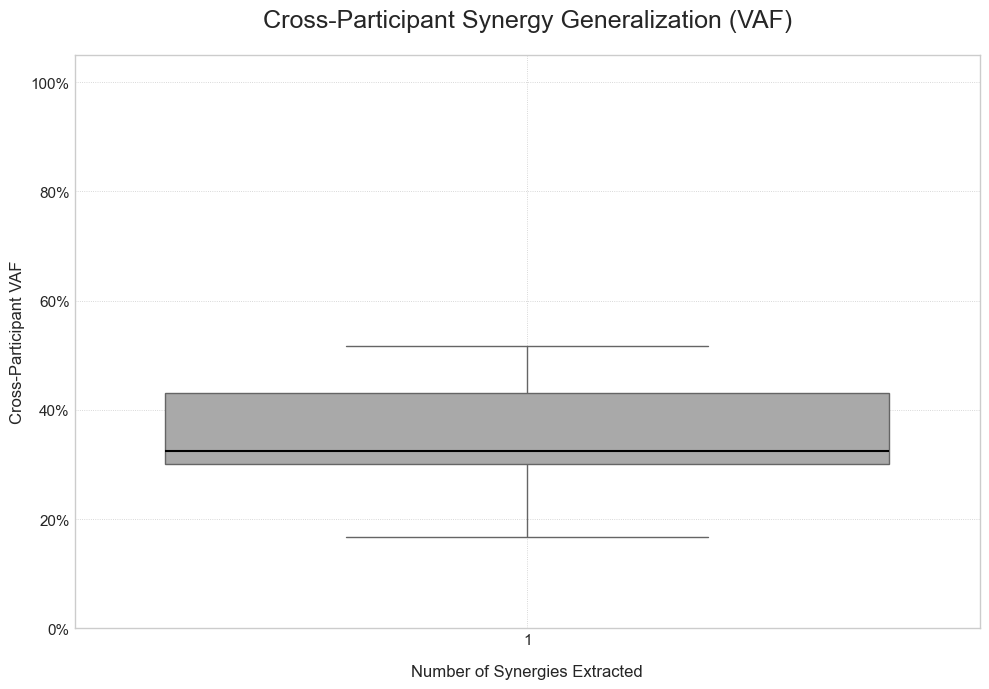

In [66]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score

# ==========================================================================================
# 1) GLOBAL CONFIGURATION
# ==========================================================================================

# --- Directories ---
BASE_DATA_DIR = r"C:\Users\schmi\Documents\Studium\TUM\Masterthesis\Experimental Data"
OUTPUT_DIR = r"C:\Users\schmi\Documents\Studium\TUM\Masterthesis\Adapted Results for Paper\Q1_Synergy_Analysis\Q1e_CrossParticipant_Reconstruction"

# --- Participants & Synergies ---
PARTICIPANTS = [1, 2, 3, 4, 5, 6, 7, 8]
SYNERGY_CONDITIONS = {
    1: "1 Synergy at Lift-Onset",
    2: "2 Synergies at Lift-Onset",
    3: "3 Synergies at Lift-Onset",
    4: "4 Synergies at Lift-Onset",
    5: "5 Synergies at Lift-Onset",    
    6: "6 Synergies at Lift-Onset"
}

# --- Data Loading Parameters ---
LIFTONSET_PHASE1_DURATION_S = 0.5
LIFTONSET_PHASE2_DURATION_S = 1.0
ORIGINAL_SAMPLING_RATE = 2000.0
N_POSE_COLUMNS_TO_REMOVE = 6

# --- Plotting Style ---
TITLE_FONTSIZE = 16
AXIS_LABEL_FONTSIZE = 12
TICK_LABEL_FONTSIZE = 11
SUPTITLE_FONTSIZE = 18


# ==========================================================================================
# 2) HELPER FUNCTIONS
# ==========================================================================================

def load_synergy_w_matrix(pid, participant_dir, trial_idx, phase_name, synergy_folder):
    """Loads ONLY the W matrix for a specific trial, phase, and synergy condition."""
    synergy_dir = os.path.join(participant_dir, synergy_folder)
    w_file = os.path.join(synergy_dir, f"trial_{trial_idx:02d}_{phase_name}_liftonset_W.npy")
    
    if os.path.exists(w_file):
        try:
            W_loaded = np.load(w_file)
            if W_loaded.size > 0:
                return W_loaded
        except Exception as e:
            print(f"  [ERROR] Could not load W for P({pid}) T({trial_idx}) from folder '{synergy_folder}': {e}")
    return None

def load_and_crop_original_data(participant_dir, trial_idx, phase_name):
    """Loads and crops the original, high-dimensional data matrix X."""
    sync_dir = os.path.join(participant_dir, "Synchronized Data split in Phases")
    kin_file = os.path.join(sync_dir, f"match_{trial_idx:02d}_{phase_name}_kin_norm.npy")
    myo_file = os.path.join(sync_dir, f"match_{trial_idx:02d}_{phase_name}_myo.npy")
    otb_file = os.path.join(sync_dir, f"match_{trial_idx:02d}_{phase_name}_otb.npy")

    if not all(os.path.exists(f) for f in [kin_file, myo_file, otb_file]):
        return None

    try:
        kin_full, myo_full, otb_full = np.load(kin_file), np.load(myo_file), np.load(otb_file)
        
        crop_seconds = LIFTONSET_PHASE1_DURATION_S if phase_name == "phase1" else LIFTONSET_PHASE2_DURATION_S
        crop_samples = int(crop_seconds * ORIGINAL_SAMPLING_RATE)

        kin_cropped = kin_full[-crop_samples:] if phase_name == "phase1" else kin_full[:crop_samples]
        myo_cropped = myo_full[-crop_samples:] if phase_name == "phase1" else myo_full[:crop_samples]
        otb_cropped = otb_full[-crop_samples:] if phase_name == "phase1" else otb_full[:crop_samples]

        min_samples = min(k.shape[0] for k in [kin_cropped, myo_cropped, otb_cropped])
        if min_samples < 5: return None

        kin_c = kin_cropped[:min_samples, :-N_POSE_COLUMNS_TO_REMOVE]
        myo_c = myo_cropped[:min_samples]
        otb_c = otb_cropped[:min_samples]
        
        combined = np.hstack([otb_c, myo_c, kin_c])
        return combined.T

    except Exception as e:
        print(f"  [ERROR] Could not process original data for T({trial_idx}): {e}")
        return None

def calculate_global_vaf(X_original, X_reconstructed):
    """Calculates the global uncentered Variance Accounted For (VAF)."""
    if X_original is None or X_reconstructed is None or np.isnan(X_original).any() or np.isnan(X_reconstructed).any():
        return np.nan
        
    sse = np.sum((X_original.flatten() - X_reconstructed.flatten()) ** 2)
    sst = np.sum(X_original.flatten() ** 2)
    
    if sst < 1e-12:
        return 1.0 if sse < 1e-12 else np.nan
    return 1.0 - (sse / sst)


# ==========================================================================================
# 3) MAIN ANALYSIS SCRIPT
# ==========================================================================================

def run_cross_participant_analysis():
    """
    Calculates and plots VAF for cross-participant reconstructions.
    For each target participant, it averages the VAF from reconstructions
    using every other participant as a source.
    """
    print("Starting Cross-Participant Synergy Generalization Analysis...")

    all_results = []

    for pid_target in PARTICIPANTS:
        print(f"Processing Target Participant: {pid_target}...")
        
        # This list will hold the VAF scores for this target from all source participants
        cross_participant_vafs_for_target = []
        
        # Iterate through all other participants who will act as the source of synergies
        for pid_source in PARTICIPANTS:
            if pid_target == pid_source:
                continue # A participant cannot reconstruct their own data in this analysis
            
            # --- Load Source Participant's Directory ---
            source_participant_dir = os.path.join(BASE_DATA_DIR, f"P({pid_source})")
            if not os.path.isdir(source_participant_dir):
                print(f"  Warning: Directory not found for Source P({pid_source}). Skipping.")
                continue

            # --- Load Target Participant's Directory ---
            target_participant_dir = os.path.join(BASE_DATA_DIR, f"P({pid_target})")

            # Perform the analysis for every trial, synergy count, and phase
            for trial_idx in range(1, 25):
                for num_synergies, synergy_folder in SYNERGY_CONDITIONS.items():
                    for phase in ["phase1", "phase2"]:
                        
                        # Load W from the source participant
                        W_source = load_synergy_w_matrix(pid_source, source_participant_dir, trial_idx, phase, synergy_folder)
                        
                        # Load X from the target participant
                        X_target = load_and_crop_original_data(target_participant_dir, trial_idx, phase)

                        if W_source is None or X_target is None:
                            continue
                        
                        # Ensure feature counts match (a critical check for cross-participant analysis)
                        if W_source.shape[0] != X_target.shape[0]:
                            print(f"  [WARN] Feature mismatch between P{pid_source} and P{pid_target} for T{trial_idx}. Skipping.")
                            continue

                        # --- Cross-Participant Reconstruction ---
                        try:
                            H_cross = np.linalg.lstsq(W_source, X_target, rcond=None)[0]
                            X_hat_cross = W_source @ H_cross
                            vaf_cross = calculate_global_vaf(X_target, X_hat_cross)
                            
                            if not np.isnan(vaf_cross):
                                all_results.append({
                                    'target_participant': pid_target,
                                    'source_participant': pid_source,
                                    'trial': trial_idx,
                                    'phase': phase,
                                    'num_synergies': num_synergies,
                                    'vaf': vaf_cross
                                })
                        except np.linalg.LinAlgError:
                            pass

    if not all_results:
        print("\nCRITICAL ERROR: No data could be calculated. Please check paths and file integrity.")
        return

    # --- AGGREGATION AND PLOTTING ---
    results_df = pd.DataFrame(all_results)
    
    # For each target participant, average the VAF scores from all source participants
    # This gives one value per target participant, per trial, phase, and synergy count
    agg_df_by_source = results_df.groupby(['target_participant', 'trial', 'phase', 'num_synergies'])['vaf'].mean().reset_index()

    # Final aggregation: for each target participant and synergy count, average across all trials and phases
    final_agg_df = agg_df_by_source.groupby(['target_participant', 'num_synergies'])['vaf'].mean().reset_index()

    os.makedirs(OUTPUT_DIR, exist_ok=True)

    # --- Plotting ---
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(10, 7))
    
    sns.boxplot(
        data=final_agg_df,
        x='num_synergies',
        y='vaf',
        ax=ax,
        color="darkgrey",
        medianprops={'color': 'black', 'linewidth': 1.5},
        showfliers=True # Changed to True to show outliers
    )
    
    ax.set_title('Cross-Participant Synergy Generalization (VAF)', fontsize=SUPTITLE_FONTSIZE, pad=20)
    ax.set_xlabel('Number of Synergies Extracted', fontsize=AXIS_LABEL_FONTSIZE, labelpad=12)
    ax.set_ylabel('Cross-Participant VAF', fontsize=AXIS_LABEL_FONTSIZE)
    
    min_vaf = final_agg_df['vaf'].min() if not final_agg_df.empty else 0
    ax.set_ylim(bottom=min(0, min_vaf - 0.1), top=1.05)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
    ax.tick_params(axis='both', which='major', labelsize=TICK_LABEL_FONTSIZE)
    ax.grid(True, which='both', linestyle=':', linewidth=0.6)

    plt.tight_layout()

    # --- Save the Plot ---
    output_filename = "Q1e_VAF_Cross_Participant_Reconstruction.png"
    output_path = os.path.join(OUTPUT_DIR, output_filename)
    plt.savefig(output_path, dpi=300)

    print(f"\nSuccess! Plot saved to:\n{output_path}")
    plt.show()


# ==========================================================================================
# 4) EXECUTION
# ==========================================================================================
if __name__ == "__main__":
    run_cross_participant_analysis()




### Question 2a: Best Matching Pairs with Greedy Algorithm

1.  **Task Knowledge Impact (Full Phase Synergies):**
     Compares phase correlation (Phase 1 W vs. Phase 2 W) between Known and Unknown
     conditions using synergies extracted over the *full duration* of each phase.
     Analyses are performed for:
     - Mean correlation across all matched pairs.
     - Mean correlation across the first 3 matched pairs.
     - Mean correlation across the last 2 matched pairs.
     Output Folder: `Q2_Task_Knowledge_FullPhase_Grouped`

2.  **Task Knowledge Impact (Lift-Onset Synergies):**
     Compares phase correlation (Phase 1 W vs. Phase 2 W) between Known and Unknown
     conditions using synergies extracted *around the lift-onset*.
     Analyses are performed for the same three pair groupings as above.
     Output Folder: `Q2_Task_Knowledge_OnsetPhase_Grouped`

3.  **Similarity of Reaching Synergies (Known vs. Unknown):**
     Compares the similarity of synergy vectors (W) themselves extracted during the
     reaching phase (Phase 1) between Known and Unknown conditions for the *same*
     underlying task.
     Similarity scores (e.g., mean Pearson correlation across matched pairs) are calculated
     for each task comparison, considering:
     - All matched pairs.
     - The first 3 matched pairs.
     - The last 2 matched pairs.
     Results in boxplots of these similarity distributions, tested against a threshold.
     Output Folder: `Q2_Task_Knowledge_ReachingSynergies_Grouped`

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, ttest_rel
import seaborn as sns

# --- Configuration ---
BASE_DIR_Q2_FULL = r"C:\Users\schmi\Documents\Studium\TUM\Masterthesis\Experimental Data"
PARTICIPANTS_Q2_FULL = [1, 2, 3, 4, 5, 6, 7, 8]
PHASES_Q2_FULL = ["phase1", "phase2"]
OUTPUT_PARENT_DIR_Q2_FULL = r"C:\Users\schmi\Documents\Studium\TUM\Masterthesis\Adapted Results for Paper"
OUTPUT_DIR_Q2_FULL_GROUPED = os.path.join(OUTPUT_PARENT_DIR_Q2_FULL, "Q2_Task_Knowledge_FullPhase_Grouped")
os.makedirs(OUTPUT_DIR_Q2_FULL_GROUPED, exist_ok=True)

EXCLUDED_TRIALS_Q2_FULL = { 7: [5, 6, 7, 8, 20, 22] } # Example

# --- Helper Functions (trial_info, cosine_similarity, load_synergy_w_matrix, match_synergies_greedy, significance_stars) ---
def trial_info_q2(trial_number):
    protocol = {
        1: ("Pinch", "H1", 0.25, "L", "No"), 2: ("Pinch", "H1", 0.25, "L", "Yes"),
        3: ("Lateral", "H2", 0.25, "R", "No"), 4: ("Lateral", "H2", 0.25, "R", "Yes"),
        5: ("Ball", "H3", 0.50, "L", "No"), 6: ("Ball", "H3", 0.50, "L", "Yes"),
        7: ("ThumbIdx", "H1", 0.25, "F", "No"), 8: ("ThumbIdx", "H1", 0.25, "F", "Yes"),
        9: ("Disc", "H4", 0.50, "B", "No"), 10: ("Disc", "H4", 0.50, "B", "Yes"),
        11: ("Power", "H5", 0.50, "F", "No"), 12: ("Power", "H5", 0.50, "F", "Yes"),
        13: ("Pinch4F", "H1", 0.25, "F", "No"), 14: ("Pinch4F", "H1", 0.25, "F", "Yes"),
        15: ("Lateral", "H2", 0.25, "B", "No"), 16: ("Lateral", "H2", 0.25, "B", "Yes"),
        17: ("Ball", "H3", 0.50, "F", "No"), 18: ("Ball", "H3", 0.50, "F", "Yes"),
        19: ("ThumbIdx", "H1", 0.25, "B", "No"), 20: ("ThumbIdx", "H1", 0.25, "B", "Yes"),
        21: ("Disc", "H4", 0.50, "L", "No"), 22: ("Disc", "H4", 0.50, "L", "Yes"),
        23: ("Power", "H5", 0.50, "R", "No"), 24: ("Power", "H5", 0.50, "R", "Yes"),
    }
    if trial_number not in protocol: return None
    tup = protocol[trial_number]
    return {'grasp_type': tup[0], 'handle_type': tup[1], 'weight_kg': tup[2], 'lever_side': tup[3], 'knowledge': tup[4]}

def cosine_similarity_q2(vec_a, vec_b):
    denom = np.linalg.norm(vec_a) * np.linalg.norm(vec_b)
    if denom < 1e-12: return np.nan
    sim = np.dot(vec_a, vec_b) / denom
    return np.clip(sim, -1.0, 1.0)

def load_synergy_w_matrix_q2(participant_dir, trial_idx, phase_name):
    synergy_dir = os.path.join(participant_dir, "Extracted Synergies")
    w_file = os.path.join(synergy_dir, f"trial_{trial_idx:02d}_{phase_name}_W.npy")
    if not os.path.exists(w_file): return None
    try:
        W = np.load(w_file)
        return W if W.size > 0 and W.shape[1] > 0 else None
    except Exception: return None

def match_synergies_greedy_q2(W1, W2):
    if W1 is None or W2 is None or W1.shape[0] != W2.shape[0]: return []
    n_s1, n_s2 = W1.shape[1], W2.shape[1]
    if n_s1 == 0 or n_s2 == 0: return []
    unmatched1, unmatched2 = list(range(n_s1)), list(range(n_s2))
    matched_pairs = []
    num_pairs_to_find = min(n_s1, n_s2)
    for _ in range(num_pairs_to_find):
        best_sim, best_pair = -np.inf, (None, None)
        for i in unmatched1:
            for j in unmatched2:
                sim = cosine_similarity_q2(W1[:, i], W2[:, j])
                if not np.isnan(sim) and sim > best_sim:
                    best_sim, best_pair = sim, (i, j)
        if best_pair == (None, None): break
        matched_pairs.append(best_pair)
        unmatched1.remove(best_pair[0])
        unmatched2.remove(best_pair[1])
    return matched_pairs

def significance_stars_q2(p_value):
    if p_value < 0.001: return '***'
    elif p_value < 0.01: return '**'
    elif p_value < 0.05: return '*'
    else: return 'ns'

def analyze_task_knowledge_full_phase_grouped():
    trial_correlations = []
    for pid in PARTICIPANTS_Q2_FULL:
        participant_str = f"P({pid})"
        participant_dir = os.path.join(BASE_DIR_Q2_FULL, participant_str)
        if not os.path.isdir(participant_dir): continue
        trials_to_skip = EXCLUDED_TRIALS_Q2_FULL.get(pid, [])

        for trial_idx in range(1, 25):
            if trial_idx in trials_to_skip: continue
            meta = trial_info_q2(trial_idx)
            if meta is None: continue
            condition = "Known" if meta['knowledge'] == "Yes" else "Unknown"

            W_phase1 = load_synergy_w_matrix_q2(participant_dir, trial_idx, PHASES_Q2_FULL[0])
            W_phase2 = load_synergy_w_matrix_q2(participant_dir, trial_idx, PHASES_Q2_FULL[1])
            if W_phase1 is None or W_phase2 is None: continue

            matched_indices = match_synergies_greedy_q2(W_phase1, W_phase2)
            if not matched_indices: continue
            
            corrs_for_trial = []
            for pair_order, (idx1, idx2) in enumerate(matched_indices):
                 if idx1 >= W_phase1.shape[1] or idx2 >= W_phase2.shape[1]: continue
                 vec1, vec2 = W_phase1[:, idx1], W_phase2[:, idx2]
                 if np.std(vec1) < 1e-9 or np.std(vec2) < 1e-9:
                     pearson_corr = np.nan
                 else:
                     try: pearson_corr, _ = pearsonr(vec1, vec2)
                     except ValueError: pearson_corr = np.nan
                 if not pd.isna(pearson_corr):
                    corrs_for_trial.append(pearson_corr)
            
            if not corrs_for_trial: continue

            num_pairs = len(corrs_for_trial)
            trial_correlations.append({
                'participant': pid, 'trial': trial_idx, 'condition': condition,
                'corr_all_pairs': np.mean(corrs_for_trial) if num_pairs > 0 else np.nan,
                'corr_first_3': np.mean(corrs_for_trial[:3]) if num_pairs >= 3 else np.nan,
                'corr_last_2': np.mean(corrs_for_trial[-2:]) if num_pairs >= 2 else np.nan, # Assumes at least 2 pairs for "last 2"
                                                                                      # If 5 pairs, this is pair 4 and 5. If 2 pairs, this is pair 1 and 2.
            })

    if not trial_correlations:
        print("[ERROR] No trial correlations calculated for Full Phase (Grouped).")
        return
    
    corr_df = pd.DataFrame(trial_correlations)
    corr_df.to_csv(os.path.join(OUTPUT_DIR_Q2_FULL_GROUPED, "q2_fullphase_grouped_correlations_raw.csv"), index=False)

    # Paired t-tests for each grouping strategy
    analysis_groups = {
        "All_Pairs": "corr_all_pairs",
        "First_3_Pairs": "corr_first_3",
        "Last_2_Pairs": "corr_last_2"
    }
    ttest_summary_list = []

    for group_name, col_name in analysis_groups.items():
        # Aggregate per participant first
        agg_group_df = corr_df.groupby(['participant', 'condition'])[col_name].mean().reset_index()
        pivot_group_df = agg_group_df.pivot_table(index='participant', columns='condition', values=col_name).reset_index()
        pivot_group_df_clean = pivot_group_df.dropna(subset=['Known', 'Unknown'])

        t_stat, p_val = np.nan, np.nan
        if len(pivot_group_df_clean) >= 2:
            try:
                t_stat, p_val = ttest_rel(pivot_group_df_clean['Known'], pivot_group_df_clean['Unknown'], nan_policy='omit')
            except Exception as e: print(f"T-test error for {group_name}: {e}")
        
        ttest_summary_list.append({
            'grouping_strategy': group_name, 't_statistic': t_stat, 'p_value': p_val,
            'mean_known': pivot_group_df_clean['Known'].mean(), 'sem_known': pivot_group_df_clean['Known'].sem(),
            'mean_unknown': pivot_group_df_clean['Unknown'].mean(), 'sem_unknown': pivot_group_df_clean['Unknown'].sem(),
            'significance': significance_stars_q2(p_val) if not pd.isna(p_val) else 'N/A'
        })
        
        # Plotting for this group
        plt.figure(figsize=(7, 6))
        sns.set_style("whitegrid")
        palette = {"Known": "#F08080", "Unknown": "#F0E68C"}
        
        # Data for barplot: means of participant means
        plot_data = pd.DataFrame({
            'Condition': ['Known', 'Unknown'],
            'Mean Correlation': [pivot_group_df_clean['Known'].mean(), pivot_group_df_clean['Unknown'].mean()],
            'SEM': [pivot_group_df_clean['Known'].sem(), pivot_group_df_clean['Unknown'].sem()]
        })

        barplot = sns.barplot(x='Condition', y='Mean Correlation', data=plot_data, palette=palette, ci=None)
        plt.errorbar(x=[0, 1], y=plot_data['Mean Correlation'], yerr=plot_data['SEM'], fmt='none', c='black', capsize=5)

        y_max = (plot_data['Mean Correlation'] + plot_data['SEM']).max()
        plt.text(0.5, y_max + 0.03, significance_stars_q2(p_val) if not pd.isna(p_val) else 'N/A',
                 ha='center', va='bottom', fontsize=14, color='black')
        
        plt.title(f'Task Knowledge Impact (Full Phase)\n{group_name.replace("_", " ")}', fontsize=15)
        plt.ylabel('Mean Pearson Correlation (Phase1 vs Phase2)', fontsize=12)
        plt.xlabel('Condition', fontsize=12)
        plt.ylim(0, max(1.0, y_max + 0.15))
        plt.tight_layout()
        plt.savefig(os.path.join(OUTPUT_DIR_Q2_FULL_GROUPED, f"q2_fullphase_impact_{group_name.lower()}.png"))
        plt.close()

    ttest_summary_df = pd.DataFrame(ttest_summary_list)
    ttest_summary_df.round(4).to_csv(os.path.join(OUTPUT_DIR_Q2_FULL_GROUPED, "q2_fullphase_grouped_ttest_summary.csv"), index=False)
    print("\nFull Phase Grouped T-Test Summary:")
    print(ttest_summary_df.round(4))

if __name__ == "__main__":
    analyze_task_knowledge_full_phase_grouped()

# %% [code]
# Script 2: Task Knowledge Impact (Lift-Onset Synergies - Grouped Pairs)

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, ttest_rel
import seaborn as sns

# --- Configuration ---
BASE_DIR_Q2_ONSET = r"C:\Users\schmi\Documents\Studium\TUM\Masterthesis\Experimental Data"
PARTICIPANTS_Q2_ONSET = [1, 2, 3, 4, 5, 6, 7, 8]
PHASES_Q2_ONSET = ["phase1", "phase2"]
OUTPUT_PARENT_DIR_Q2_ONSET = r"C:\Users\schmi\Documents\Studium\TUM\Masterthesis\Adapted Results for Paper"
OUTPUT_DIR_Q2_ONSET_GROUPED = os.path.join(OUTPUT_PARENT_DIR_Q2_ONSET, "Q2_Task_Knowledge_OnsetPhase_Grouped")
os.makedirs(OUTPUT_DIR_Q2_ONSET_GROUPED, exist_ok=True)

EXCLUDED_TRIALS_Q2_ONSET = { 7: [5, 6, 7, 8, 20, 22] }

# --- Helper Functions (reusing from above, ensure they are defined or copied if running standalone) ---
# trial_info_q2, cosine_similarity_q2, match_synergies_greedy_q2, significance_stars_q2
# For this script, we need a specific loader for lift-onset W matrices
def load_synergy_w_matrix_liftonset_q2(participant_dir, trial_idx, phase_name):
    synergy_dir = os.path.join(participant_dir, "Synergies at Lift-Onset")
    w_file = os.path.join(synergy_dir, f"trial_{trial_idx:02d}_{phase_name}_liftonset_W.npy")
    if not os.path.exists(w_file): return None
    try:
        W = np.load(w_file)
        return W if W.size > 0 and W.shape[1] > 0 else None
    except Exception: return None

def analyze_task_knowledge_onset_phase_grouped():
    trial_correlations = []
    for pid in PARTICIPANTS_Q2_ONSET:
        participant_str = f"P({pid})"
        participant_dir = os.path.join(BASE_DIR_Q2_ONSET, participant_str)
        if not os.path.isdir(participant_dir): continue
        trials_to_skip = EXCLUDED_TRIALS_Q2_ONSET.get(pid, [])

        for trial_idx in range(1, 25):
            if trial_idx in trials_to_skip: continue
            meta = trial_info_q2(trial_idx)
            if meta is None: continue
            condition = "Known" if meta['knowledge'] == "Yes" else "Unknown"

            W_phase1 = load_synergy_w_matrix_liftonset_q2(participant_dir, trial_idx, PHASES_Q2_ONSET[0])
            W_phase2 = load_synergy_w_matrix_liftonset_q2(participant_dir, trial_idx, PHASES_Q2_ONSET[1])
            if W_phase1 is None or W_phase2 is None: continue

            matched_indices = match_synergies_greedy_q2(W_phase1, W_phase2)
            if not matched_indices: continue
            
            corrs_for_trial = []
            for pair_order, (idx1, idx2) in enumerate(matched_indices):
                 if idx1 >= W_phase1.shape[1] or idx2 >= W_phase2.shape[1]: continue
                 vec1, vec2 = W_phase1[:, idx1], W_phase2[:, idx2]
                 if np.std(vec1) < 1e-9 or np.std(vec2) < 1e-9:
                     pearson_corr = np.nan
                 else:
                     try: pearson_corr, _ = pearsonr(vec1, vec2)
                     except ValueError: pearson_corr = np.nan
                 if not pd.isna(pearson_corr):
                    corrs_for_trial.append(pearson_corr)

            if not corrs_for_trial: continue
            num_pairs = len(corrs_for_trial)
            trial_correlations.append({
                'participant': pid, 'trial': trial_idx, 'condition': condition,
                'corr_all_pairs': np.mean(corrs_for_trial) if num_pairs > 0 else np.nan,
                'corr_first_3': np.mean(corrs_for_trial[:3]) if num_pairs >= 3 else np.nan,
                'corr_last_2': np.mean(corrs_for_trial[-2:]) if num_pairs >= 2 else np.nan,
            })

    if not trial_correlations:
        print("[ERROR] No trial correlations calculated for Lift-Onset Phase (Grouped).")
        return

    corr_df = pd.DataFrame(trial_correlations)
    corr_df.to_csv(os.path.join(OUTPUT_DIR_Q2_ONSET_GROUPED, "q2_onsetphase_grouped_correlations_raw.csv"), index=False)

    analysis_groups = {
        "All_Pairs": "corr_all_pairs",
        "First_3_Pairs": "corr_first_3",
        "Last_2_Pairs": "corr_last_2"
    }
    ttest_summary_list = []

    for group_name, col_name in analysis_groups.items():
        agg_group_df = corr_df.groupby(['participant', 'condition'])[col_name].mean().reset_index()
        pivot_group_df = agg_group_df.pivot_table(index='participant', columns='condition', values=col_name).reset_index()
        pivot_group_df_clean = pivot_group_df.dropna(subset=['Known', 'Unknown'])
        
        t_stat, p_val = np.nan, np.nan
        if len(pivot_group_df_clean) >= 2:
            try:
                t_stat, p_val = ttest_rel(pivot_group_df_clean['Known'], pivot_group_df_clean['Unknown'], nan_policy='omit')
            except Exception as e: print(f"T-test error for {group_name} (Onset): {e}")

        ttest_summary_list.append({
            'grouping_strategy': group_name, 't_statistic': t_stat, 'p_value': p_val,
            'mean_known': pivot_group_df_clean['Known'].mean(), 'sem_known': pivot_group_df_clean['Known'].sem(),
            'mean_unknown': pivot_group_df_clean['Unknown'].mean(), 'sem_unknown': pivot_group_df_clean['Unknown'].sem(),
            'significance': significance_stars_q2(p_val) if not pd.isna(p_val) else 'N/A'
        })

        plt.figure(figsize=(7, 6))
        sns.set_style("whitegrid")
        palette = {"Known": "#F08080", "Unknown": "#F0E68C"}
        plot_data = pd.DataFrame({
            'Condition': ['Known', 'Unknown'],
            'Mean Correlation': [pivot_group_df_clean['Known'].mean(), pivot_group_df_clean['Unknown'].mean()],
            'SEM': [pivot_group_df_clean['Known'].sem(), pivot_group_df_clean['Unknown'].sem()]
        })
        barplot = sns.barplot(x='Condition', y='Mean Correlation', data=plot_data, palette=palette, ci=None)
        plt.errorbar(x=[0, 1], y=plot_data['Mean Correlation'], yerr=plot_data['SEM'], fmt='none', c='black', capsize=5)
        y_max = (plot_data['Mean Correlation'] + plot_data['SEM']).max()
        plt.text(0.5, y_max + 0.03, significance_stars_q2(p_val) if not pd.isna(p_val) else 'N/A',
                 ha='center', va='bottom', fontsize=14, color='black')
        plt.title(f'Task Knowledge Impact (Lift-Onset)\n{group_name.replace("_", " ")}', fontsize=15)
        plt.ylabel('Mean Pearson Correlation (Phase1 vs Phase2)', fontsize=12)
        plt.xlabel('Condition', fontsize=12)
        plt.ylim(0, max(1.0, y_max + 0.15))
        plt.tight_layout()
        plt.savefig(os.path.join(OUTPUT_DIR_Q2_ONSET_GROUPED, f"q2_onsetphase_impact_{group_name.lower()}.png"))
        plt.close()

    ttest_summary_df = pd.DataFrame(ttest_summary_list)
    ttest_summary_df.round(4).to_csv(os.path.join(OUTPUT_DIR_Q2_ONSET_GROUPED, "q2_onsetphase_grouped_ttest_summary.csv"), index=False)
    print("\nLift-Onset Phase Grouped T-Test Summary:")
    print(ttest_summary_df.round(4))

if __name__ == "__main__":
    analyze_task_knowledge_onset_phase_grouped()

# Script 3: Similarity of Reaching Synergies (Known vs. Unknown - Grouped Pairs)

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, ttest_1samp
import seaborn as sns

# --- Configuration ---
BASE_DIR_Q2_REACH = r"C:\Users\schmi\Documents\Studium\TUM\Masterthesis\Experimental Data"
PARTICIPANTS_Q2_REACH = [1, 2, 3, 4, 5, 6, 7, 8]
PHASE_TO_ANALYZE_Q2_REACH = "phase1" # Only reaching phase
OUTPUT_PARENT_DIR_Q2_REACH = r"C:\Users\schmi\Documents\Studium\TUM\Masterthesis\Adapted Results for Paper"
OUTPUT_DIR_Q2_REACH_GROUPED = os.path.join(OUTPUT_PARENT_DIR_Q2_REACH, "Q2_Task_Knowledge_ReachingSynergies_Grouped")
os.makedirs(OUTPUT_DIR_Q2_REACH_GROUPED, exist_ok=True)

SIMILARITY_METRIC_Q2_REACH = 'pearson_correlation'
THRESHOLD_Q2_REACH = 0.7 # For one-sample t-test

EXCLUDED_TRIALS_Q2_REACH = { 7: [5, 6, 7, 8, 20, 22] }

# --- Helper Functions (trial_info_q2, cosine_similarity_q2, load_synergy_w_matrix_q2, match_synergies_greedy_q2, significance_stars_q2) ---
# Make sure these are defined if running this script block standalone.
# For this example, assuming they are available from previous script blocks.
# If not, copy them here.
# trial_info_q2, cosine_similarity_q2, match_synergies_greedy_q2 are identical to above.
# load_synergy_w_matrix_q2 is also suitable for loading Phase 1 full-phase synergies.
# significance_stars_q2 needs to be renamed or aliased if used with ttest_1samp.
def significance_stars_onesample_q2(p_value_one_sided):
    if p_value_one_sided < 0.001: return '***'
    elif p_value_one_sided < 0.01: return '**'
    elif p_value_one_sided < 0.05: return '*'
    else: return 'ns'

def analyze_reaching_synergy_similarity_grouped():
    within_task_similarities_list = []
    task_groups = {}
    for trial_idx_loop in range(1, 25): # Iterate through all possible trial numbers
        info = trial_info_q2(trial_idx_loop)
        if info:
            # Define task key by grasp, handle, weight, lever (excluding knowledge)
            task_key = (info['grasp_type'], info['handle_type'], info['weight_kg'], info['lever_side'])
            if task_key not in task_groups:
                task_groups[task_key] = {'Known': None, 'Unknown': None}
            condition_knowledge = info['knowledge']
            if condition_knowledge == 'Yes':
                task_groups[task_key]['Known'] = trial_idx_loop
            else: # 'No'
                task_groups[task_key]['Unknown'] = trial_idx_loop

    for pid in PARTICIPANTS_Q2_REACH:
        participant_str = f"P({pid})"
        participant_dir = os.path.join(BASE_DIR_Q2_REACH, participant_str)
        if not os.path.isdir(participant_dir): continue
        trials_to_skip = EXCLUDED_TRIALS_Q2_REACH.get(pid, [])

        for task_key, trials_dict in task_groups.items():
            known_trial_num = trials_dict['Known']
            unknown_trial_num = trials_dict['Unknown']

            if known_trial_num is None or unknown_trial_num is None: continue
            if known_trial_num in trials_to_skip or unknown_trial_num in trials_to_skip: continue

            W_known_reach = load_synergy_w_matrix_q2(participant_dir, known_trial_num, PHASE_TO_ANALYZE_Q2_REACH)
            W_unknown_reach = load_synergy_w_matrix_q2(participant_dir, unknown_trial_num, PHASE_TO_ANALYZE_Q2_REACH)
            if W_known_reach is None or W_unknown_reach is None: continue

            matched_indices = match_synergies_greedy_q2(W_known_reach, W_unknown_reach)
            if not matched_indices: continue
            
            corrs_for_task_comparison = []
            for pair_order, (idx_k, idx_u) in enumerate(matched_indices):
                if idx_k >= W_known_reach.shape[1] or idx_u >= W_unknown_reach.shape[1]: continue
                vec_k, vec_u = W_known_reach[:, idx_k], W_unknown_reach[:, idx_u]
                if np.std(vec_k) < 1e-9 or np.std(vec_u) < 1e-9:
                    sim_val = np.nan
                else:
                    try: sim_val, _ = pearsonr(vec_k, vec_u)
                    except ValueError: sim_val = np.nan
                if not pd.isna(sim_val):
                    corrs_for_task_comparison.append(sim_val)
            
            if not corrs_for_task_comparison: continue
            num_pairs_comp = len(corrs_for_task_comparison)

            within_task_similarities_list.append({
                'participant': pid, 'task_key': "_".join(map(str,task_key)),
                'sim_all_pairs': np.mean(corrs_for_task_comparison) if num_pairs_comp > 0 else np.nan,
                'sim_first_3': np.mean(corrs_for_task_comparison[:3]) if num_pairs_comp >= 3 else np.nan,
                'sim_last_2': np.mean(corrs_for_task_comparison[-2:]) if num_pairs_comp >= 2 else np.nan,
            })

    if not within_task_similarities_list:
        print("[ERROR] No reaching synergy similarities calculated.")
        return

    sim_df = pd.DataFrame(within_task_similarities_list)
    sim_df.to_csv(os.path.join(OUTPUT_DIR_Q2_REACH_GROUPED, "q2_reaching_synergy_similarities_grouped_raw.csv"), index=False)

    # Plotting and T-tests for each grouping strategy
    grouping_cols = {
        "All_Matched_Pairs": "sim_all_pairs",
        "First_3_Matched_Pairs": "sim_first_3",
        "Last_2_Matched_Pairs": "sim_last_2"
    }
    
    for group_plot_name, col_name_sim in grouping_cols.items():
        current_similarities = sim_df[col_name_sim].dropna()
        t_stat, p_val_two_sided = np.nan, np.nan
        p_val_one_sided = np.nan
        stars = 'N/A'

        if len(current_similarities) >= 2:
            try:
                t_stat, p_val_two_sided = ttest_1samp(current_similarities, THRESHOLD_Q2_REACH, nan_policy='omit')
                p_val_one_sided = p_val_two_sided / 2.0 if t_stat > 0 else 1.0 - (p_val_two_sided / 2.0)
                stars = significance_stars_onesample_q2(p_val_one_sided)
            except Exception as e: print(f"T-test error for {group_plot_name}: {e}")

        plt.figure(figsize=(6, 7))
        sns.set_style("whitegrid")
        sns.boxplot(y=current_similarities, color="lightgrey", showfliers=True)
        sns.stripplot(y=current_similarities, color='black', alpha=0.5, size=4, jitter=True)
        
        title = f'Similarity of Reaching Synergies (W_Phase1)\nKnown vs. Unknown (Same Task)\n({group_plot_name.replace("_", " ")})'
        plt.title(title, fontsize=13)
        plt.ylabel(f'Mean Pearson Correlation ({group_plot_name.replace("_", " ")})', fontsize=11)
        plt.xlabel(f'Tested vs. {THRESHOLD_Q2_REACH} (H1: > {THRESHOLD_Q2_REACH})', fontsize=11)
        plt.xticks([])
        min_y_val = current_similarities.min() if not current_similarities.empty else 0
        max_y_val = current_similarities.max() if not current_similarities.empty else 1.1
        plt.ylim(min(0, min_y_val - 0.1), max(1.0, max_y_val + 0.15))
        
        q3 = current_similarities.quantile(0.75) if not current_similarities.empty else max_y_val
        iqr = q3 - (current_similarities.quantile(0.25) if not current_similarities.empty else min_y_val)
        upper_bound = max_y_val
        if not (pd.isna(iqr) or iqr < 1e-9):
            upper_whisker = current_similarities[current_similarities <= q3 + 1.5 * iqr].max()
            upper_bound = upper_whisker if not pd.isna(upper_whisker) else max_y_val
        
        y_pos_stars = upper_bound + 0.05 if not pd.isna(upper_bound) else (current_similarities.mean() + 0.1)
        if pd.isna(y_pos_stars): y_pos_stars = 1.05
        
        test_text = f"{stars} (p={p_val_one_sided:.3f})" if not pd.isna(p_val_one_sided) else "N/A"
        plt.text(0, y_pos_stars, test_text, ha='center', va='bottom', fontsize=12, color='black')
        
        plt.tight_layout()
        plt.savefig(os.path.join(OUTPUT_DIR_Q2_REACH_GROUPED, f"q2_reaching_similarity_{group_plot_name.lower()}.png"))
        plt.close()
        print(f"Reaching synergy similarity boxplot ({group_plot_name}) saved.")
        print(f"  {group_plot_name}: Mean={current_similarities.mean():.3f}, Std={current_similarities.std():.3f}, N={len(current_similarities)}")
        print(f"  T-test vs {THRESHOLD_Q2_REACH}: t={t_stat:.3f}, p(1-sided)={p_val_one_sided:.3f} ({stars})")

if __name__ == "__main__":
    print("--- Running Full Phase Grouped Analysis ---")
    analyze_task_knowledge_full_phase_grouped()
    print("\n--- Running Lift-Onset Phase Grouped Analysis ---")
    analyze_task_knowledge_onset_phase_grouped()
    print("\n--- Running Reaching Synergy Similarity (Grouped) Analysis ---")
    analyze_reaching_synergy_similarity_grouped()



### Question 2b: Task Knowledge Boxplots merged in one Plot for all Pairs and Pair 4 & 5

In [55]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, ttest_rel
import seaborn as sns

# --- Configuration ---
BASE_DIR_Q2_COMB = r"C:\Users\schmi\Documents\Studium\TUM\Masterthesis\Experimental Data"
PARTICIPANTS_Q2_COMB = [1, 2, 3, 4, 5, 6, 7, 8]
PHASES_Q2_COMB = ["phase1", "phase2"]

OUTPUT_PARENT_DIR_Q2_COMB = r"C:\Users\schmi\Documents\Studium\TUM\Masterthesis\Adapted Results for Paper"
# Updated output directory name for this specific styled plot
OUTPUT_DIR_Q2_COMBINED = os.path.join(OUTPUT_PARENT_DIR_Q2_COMB, "Q2_Task_Knowledge_Anticipation_LiftOnset")
os.makedirs(OUTPUT_DIR_Q2_COMBINED, exist_ok=True)

EXCLUDED_TRIALS_Q2_COMB = { 7: [20, 22] } # Plots show asynchronus recording

# --- Font Sizes for Publication Styling ---
TITLE_FONTSIZE_Q2_COMB = 20
AXIS_LABEL_FONTSIZE_Q2_COMB = 18
TICK_LABEL_FONTSIZE_Q2_COMB = 16
LEGEND_FONTSIZE_Q2_COMB = 14
LEGEND_TITLE_FONTSIZE_Q2_COMB = 15
BRACKET_TEXT_FONTSIZE_Q2_COMB = 18

# --- Helper Functions ---
def trial_info_q2_comb(trial_number):
    """Returns a dictionary with trial metadata."""
    protocol = {
        1: ("Pinch", "H1", 0.25, "L", "No"), 2: ("Pinch", "H1", 0.25, "L", "Yes"),
        3: ("Lateral", "H2", 0.25, "R", "No"), 4: ("Lateral", "H2", 0.25, "R", "Yes"),
        5: ("Ball", "H3", 0.50, "L", "No"), 6: ("Ball", "H3", 0.50, "L", "Yes"),
        7: ("ThumbIdx", "H1", 0.25, "F", "No"), 8: ("ThumbIdx", "H1", 0.25, "F", "Yes"),
        9: ("Disc", "H4", 0.50, "B", "No"), 10: ("Disc", "H4", 0.50, "B", "Yes"),
        11: ("Power", "H5", 0.50, "F", "No"), 12: ("Power", "H5", 0.50, "F", "Yes"),
        13: ("Pinch4F", "H1", 0.25, "F", "No"), 14: ("Pinch4F", "H1", 0.25, "F", "Yes"),
        15: ("Lateral", "H2", 0.25, "B", "No"), 16: ("Lateral", "H2", 0.25, "B", "Yes"),
        17: ("Ball", "H3", 0.50, "F", "No"), 18: ("Ball", "H3", 0.50, "F", "Yes"),
        19: ("ThumbIdx", "H1", 0.25, "B", "No"), 20: ("ThumbIdx", "H1", 0.25, "B", "Yes"),
        21: ("Disc", "H4", 0.50, "L", "No"), 22: ("Disc", "H4", 0.50, "L", "Yes"),
        23: ("Power", "H5", 0.50, "R", "No"), 24: ("Power", "H5", 0.50, "R", "Yes"),
    }
    if trial_number not in protocol: return None
    tup = protocol[trial_number]
    return {'grasp_type': tup[0], 'handle_type': tup[1], 'weight_kg': tup[2], 
            'lever_side': tup[3], 'condition': "Known" if tup[4] == "Yes" else "Unknown"}

def cosine_similarity_q2_comb(vec_a, vec_b):
    """Calculates the cosine similarity between two vectors."""
    denom = np.linalg.norm(vec_a) * np.linalg.norm(vec_b)
    if denom < 1e-12: return np.nan
    sim = np.dot(vec_a, vec_b) / denom
    return np.clip(sim, -1.0, 1.0)

def load_synergy_w_matrix_fullphase_q2_comb(participant_dir, trial_idx, phase_name):
    """Loads the W matrix for the full phase."""
    synergy_dir = os.path.join(participant_dir, "Extracted Synergies")
    w_file = os.path.join(synergy_dir, f"trial_{trial_idx:02d}_{phase_name}_W.npy")
    if not os.path.exists(w_file): return None
    try: W = np.load(w_file); return W if W.size > 0 and W.shape[1] > 0 else None
    except Exception: return None

def load_synergy_w_matrix_liftonset_q2_comb(participant_dir, trial_idx, phase_name):
    """Loads the W matrix at lift-onset."""
    synergy_dir = os.path.join(participant_dir, "Synergies at Lift-Onset")
    w_file = os.path.join(synergy_dir, f"trial_{trial_idx:02d}_{phase_name}_liftonset_W.npy")
    if not os.path.exists(w_file): return None
    try: W = np.load(w_file); return W if W.size > 0 and W.shape[1] > 0 else None
    except Exception: return None

def match_synergies_greedy_q2_comb(W1, W2):
    """Matches synergies between two W matrices using a greedy algorithm."""
    if W1 is None or W2 is None or W1.shape[0] != W2.shape[0]: return []
    n_s1, n_s2 = W1.shape[1], W2.shape[1]
    if n_s1 == 0 or n_s2 == 0: return []
    unmatched1, unmatched2 = list(range(n_s1)), list(range(n_s2))
    matched_pairs = []
    num_pairs_to_find = min(n_s1, n_s2)
    for _ in range(num_pairs_to_find):
        best_sim, best_pair = -np.inf, (None, None)
        for i in unmatched1:
            for j in unmatched2:
                sim = cosine_similarity_q2_comb(W1[:, i], W2[:, j])
                if not np.isnan(sim) and sim > best_sim: best_sim, best_pair = sim, (i, j)
        if best_pair == (None, None): break
        matched_pairs.append(best_pair)
        unmatched1.remove(best_pair[0]); unmatched2.remove(best_pair[1])
    return matched_pairs

def significance_stars_q2_comb(p_value):
    """Returns significance stars based on p-value."""
    if pd.isna(p_value): return 'N/A'
    if p_value < 0.001: return '***'
    elif p_value < 0.01: return '**'
    elif p_value < 0.05: return '*'
    else: return 'ns'

def add_significance_bracket_q2_comb(ax, x1, x2, y, h, text, text_y_offset=0.01, text_fontsize=18):
    """Adds a significance bracket to a plot."""
    ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, c='black')
    ax.text((x1 + x2) * 0.5, y + h + text_y_offset, text, ha='center', va='bottom', color='black', fontsize=text_fontsize)

# --- Main Analysis Function ---
def analyze_task_knowledge_combined_plot():
    """
    Calculates and plots synergy correlations for All vs. the 2 Weakest matched synergies,
    with final aesthetic adjustments for publication.
    """
    # --- Data Calculation Section ---
    all_correlations = []
    print("[INFO] Starting correlation calculations...")
    for pid in PARTICIPANTS_Q2_COMB:
        participant_str = f"P({pid})"
        participant_dir = os.path.join(BASE_DIR_Q2_COMB, participant_str)
        if not os.path.isdir(participant_dir): continue
        trials_to_skip = EXCLUDED_TRIALS_Q2_COMB.get(pid, [])
        for trial_idx in range(1, 25):
            if trial_idx in trials_to_skip: continue
            meta = trial_info_q2_comb(trial_idx)
            if meta is None: continue
            condition = meta['condition']
            for extraction in ['Full Phase', 'Lift-Onset']:
                if extraction == 'Full Phase':
                    W1 = load_synergy_w_matrix_fullphase_q2_comb(participant_dir, trial_idx, PHASES_Q2_COMB[0])
                    W2 = load_synergy_w_matrix_fullphase_q2_comb(participant_dir, trial_idx, PHASES_Q2_COMB[1])
                else:
                    W1 = load_synergy_w_matrix_liftonset_q2_comb(participant_dir, trial_idx, PHASES_Q2_COMB[0])
                    W2 = load_synergy_w_matrix_liftonset_q2_comb(participant_dir, trial_idx, PHASES_Q2_COMB[1])
                
                if W1 is None or W2 is None: continue
                
                matched_pairs = match_synergies_greedy_q2_comb(W1, W2)
                if not matched_pairs: continue

                # Calculate for "All Synergies"
                corrs_all = [pearsonr(W1[:,i], W2[:,j])[0] for i,j in matched_pairs if np.std(W1[:,i]) > 1e-9 and np.std(W2[:,j]) > 1e-9]
                if corrs_all:
                    mean_corr_all = np.nanmean(corrs_all)
                    if not pd.isna(mean_corr_all):
                        all_correlations.append({
                            'participant': pid, 'trial': trial_idx, 'condition': condition,
                            'extraction_type': extraction, 'synergy_subset': 'All Synergies',
                            'mean_correlation': mean_corr_all
                        })

                # The greedy algorithm orders pairs from best to worst; the last two are the weakest.
                if len(matched_pairs) >= 2:
                    weakest_pairs = matched_pairs[-2:]
                    corrs_last2 = [pearsonr(W1[:,i], W2[:,j])[0] for i,j in weakest_pairs if np.std(W1[:,i]) > 1e-9 and np.std(W2[:,j]) > 1e-9]
                    if corrs_last2:
                        mean_corr_last2 = np.nanmean(corrs_last2)
                        if not pd.isna(mean_corr_last2):
                            all_correlations.append({
                                'participant': pid, 'trial': trial_idx, 'condition': condition,
                                'extraction_type': extraction, 'synergy_subset': '2 Weakest Synergies',
                                'mean_correlation': mean_corr_last2
                            })

    if not all_correlations:
        print("[ERROR] No correlations calculated.")
        return
        
    corr_df = pd.DataFrame(all_correlations)
    agg_df = corr_df.groupby(['participant', 'extraction_type', 'condition', 'synergy_subset'])['mean_correlation'].mean().reset_index()

    # --- Plotting Section (with final adjustments) ---
    print("[INFO] Generating final plot...")
    fig, axes = plt.subplots(1, 2, figsize=(18, 9), sharey=True)
    
    sns.set_style("whitegrid")
    palette = {"Unknown": "lightgrey", "Known": "#A9A9A9"}

    plot_info = [
        {'ax': axes[0], 'subset': 'All Synergies', 'title': 'All Matched Synergy Pairs'},
        {'ax': axes[1], 'subset': '2 Weakest Synergies', 'title': 'Last 2 Matched Synergy Pairs'}
    ]

    for info in plot_info:
        ax = info['ax']
        subset_df = agg_df[agg_df['synergy_subset'] == info['subset']]
        
        if subset_df.empty:
            ax.text(0.5, 0.5, f"No data available for\n'{info['subset']}'", ha='center', va='center')
            ax.set_title(info['title'], fontsize=TITLE_FONTSIZE_Q2_COMB)
            continue

        sns.boxplot(ax=ax, x='extraction_type', y='mean_correlation', hue='condition', data=subset_df,
                    palette=palette, showfliers=True, width=0.6,
                    order=['Full Phase', 'Lift-Onset'], hue_order=['Unknown', 'Known'],
                    medianprops={'linewidth': 1.5, 'color': 'black', 'alpha': 0.8})

        ax.set_title(info['title'], fontsize=TITLE_FONTSIZE_Q2_COMB, pad=15)
        ax.set_xlabel("")
        ax.tick_params(axis='x', labelsize=TICK_LABEL_FONTSIZE_Q2_COMB)
        ax.tick_params(axis='y', labelsize=TICK_LABEL_FONTSIZE_Q2_COMB)
        ax.set_ylabel("")

        if ax.get_legend():
            ax.get_legend().remove()

        # --- Significance Annotations ---
        y_max_data = subset_df['mean_correlation'].dropna().max()
        bracket_h = 0.02
        bracket_y_level_1 = y_max_data + 0.04
        bracket_y_level_2 = bracket_y_level_1 + bracket_h + 0.06

        df_fp = subset_df[subset_df['extraction_type'] == 'Full Phase']
        fp_merged = pd.merge(df_fp[df_fp['condition'] == 'Known'], df_fp[df_fp['condition'] == 'Unknown'], on='participant', suffixes=('_known', '_unknown'))
        if len(fp_merged) >= 2:
            _, p_fp = ttest_rel(fp_merged['mean_correlation_known'], fp_merged['mean_correlation_unknown'], nan_policy='omit')
            add_significance_bracket_q2_comb(ax, -0.15, 0.15, bracket_y_level_1, bracket_h, significance_stars_q2_comb(p_fp))

        df_lo = subset_df[subset_df['extraction_type'] == 'Lift-Onset']
        lo_merged = pd.merge(df_lo[df_lo['condition'] == 'Known'], df_lo[df_lo['condition'] == 'Unknown'], on='participant', suffixes=('_known', '_unknown'))
        if len(lo_merged) >= 2:
            _, p_lo = ttest_rel(lo_merged['mean_correlation_known'], lo_merged['mean_correlation_unknown'], nan_policy='omit')
            add_significance_bracket_q2_comb(ax, 0.85, 1.15, bracket_y_level_1, bracket_h, significance_stars_q2_comb(p_lo))

        fp_pooled = subset_df[subset_df['extraction_type'] == 'Full Phase'].groupby('participant')['mean_correlation'].mean()
        lo_pooled = subset_df[subset_df['extraction_type'] == 'Lift-Onset'].groupby('participant')['mean_correlation'].mean()
        merged_overall = pd.merge(fp_pooled.rename("FullPhase"), lo_pooled.rename("LiftOnset"), left_index=True, right_index=True)
        if len(merged_overall) >= 2:
            _, p_overall = ttest_rel(merged_overall['FullPhase'], merged_overall['LiftOnset'], nan_policy='omit')
            add_significance_bracket_q2_comb(ax, 0, 1, bracket_y_level_2, bracket_h, significance_stars_q2_comb(p_overall))
    
    plt.ylim(bottom=0.2, top=1.1)
    
    current_ticks = axes[0].get_yticks()
    if len(current_ticks) > 1:
        axes[0].set_yticks(current_ticks[:-1])

    # --- Common Figure Elements ---
    # --- CORRECTED LOGIC: Place y-label very close to the edge ---
    fig.supylabel("Mean Pearson Correlation", fontsize=AXIS_LABEL_FONTSIZE_Q2_COMB, x=0.015)
    
    fig.supxlabel("Synergy Extraction Window", fontsize=AXIS_LABEL_FONTSIZE_Q2_COMB)

    handles, labels = axes[0].get_legend_handles_labels()
    
    # --- CORRECTED LOGIC: Add a frame/border to the legend ---
    fig.legend(handles, labels, title="Condition", fontsize=LEGEND_FONTSIZE_Q2_COMB, 
               title_fontsize=LEGEND_TITLE_FONTSIZE_Q2_COMB, 
               loc='lower right', 
               bbox_to_anchor=(0.98, 0.18),
               frameon=True,
               edgecolor='gray')

    fig.suptitle("Impact of Task Knowledge on Inter-Phase Synergy Correlation", fontsize=TITLE_FONTSIZE_Q2_COMB + 2, y=0.98)
    
    # --- CORRECTED LOGIC: Use a very tight left margin ---
    plt.tight_layout(rect=[0.04, 0.05, 1, 0.95])
    
    output_filename = "q2_Inter-Phase_Synergy_Correlation_SideBySide_Final_Tight.png"
    plt.savefig(os.path.join(OUTPUT_DIR_Q2_COMBINED, output_filename), dpi=300)
    plt.close()
    print(f"\n[INFO] Final Q2 plot saved as '{output_filename}' in {OUTPUT_DIR_Q2_COMBINED}")

if __name__ == "__main__":
    analyze_task_knowledge_combined_plot()

[INFO] Starting correlation calculations...
[INFO] Generating final plot...

[INFO] Final Q2 plot saved as 'q2_Inter-Phase_Synergy_Correlation_SideBySide_Final_Tight.png' in C:\Users\schmi\Documents\Studium\TUM\Masterthesis\Adapted Results for Paper\Q2_Task_Knowledge_Anticipation_LiftOnset


### Question 3: Anticipatory Information during Lift Onset

Similarity Across Synergies computed around the lift onset

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, ttest_rel # ttest_rel for paired samples

# --- Configuration ---
BASE_DIR_Q3 = r"C:\Users\schmi\Documents\Studium\TUM\Masterthesis\Experimental Data"
PARTICIPANTS_Q3 = [1, 2, 3, 4, 5, 6, 7, 8]
PHASES_Q3 = ["phase1", "phase2"]

OUTPUT_PARENT_DIR_Q3 = r"C:\Users\schmi\Documents\Studium\TUM\Masterthesis\Adapted Results for Paper"
# Updated output directory name
OUTPUT_DIR_Q3_REVISED = os.path.join(OUTPUT_PARENT_DIR_Q3, "Q3_Anticipatory_Info_LiftOnset_RevisedPlot_PubStyle")
os.makedirs(OUTPUT_DIR_Q3_REVISED, exist_ok=True)

EXCLUDED_TRIALS_Q3 = { 7: [5, 6, 7, 8, 20, 22] } # Example, adjust as needed

# --- Font Sizes for Publication Styling ---
TITLE_FONTSIZE_Q3 = 20
AXIS_LABEL_FONTSIZE_Q3 = 18
TICK_LABEL_FONTSIZE_Q3 = 16
BRACKET_TEXT_FONTSIZE_Q3 = 18 # For significance stars on bracket

# --- Helper Functions ---
def trial_info_q3(trial_number):
    return {'trial_number': trial_number}

def cosine_similarity_q3(vec_a, vec_b):
    denom = np.linalg.norm(vec_a) * np.linalg.norm(vec_b)
    if denom < 1e-12: return np.nan
    sim = np.dot(vec_a, vec_b) / denom
    return np.clip(sim, -1.0, 1.0)

def load_synergy_w_matrix_fullphase_q3(participant_dir, trial_idx, phase_name):
    synergy_dir = os.path.join(participant_dir, "Extracted Synergies")
    w_file = os.path.join(synergy_dir, f"trial_{trial_idx:02d}_{phase_name}_W.npy")
    if not os.path.exists(w_file): return None
    try:
        W = np.load(w_file)
        return W if W.size > 0 and W.shape[1] > 0 else None
    except Exception: return None

def load_synergy_w_matrix_liftonset_q3(participant_dir, trial_idx, phase_name):
    synergy_dir = os.path.join(participant_dir, "Synergies at Lift-Onset")
    w_file = os.path.join(synergy_dir, f"trial_{trial_idx:02d}_{phase_name}_liftonset_W.npy")
    if not os.path.exists(w_file): return None
    try:
        W = np.load(w_file)
        return W if W.size > 0 and W.shape[1] > 0 else None
    except Exception: return None

def match_synergies_greedy_q3(W1, W2):
    if W1 is None or W2 is None or W1.shape[0] != W2.shape[0]: return []
    n_s1, n_s2 = W1.shape[1], W2.shape[1]
    if n_s1 == 0 or n_s2 == 0: return []
    unmatched1, unmatched2 = list(range(n_s1)), list(range(n_s2))
    matched_pairs = []
    num_pairs_to_find = min(n_s1, n_s2)
    for _ in range(num_pairs_to_find):
        best_sim, best_pair = -np.inf, (None, None)
        for i in unmatched1:
            for j in unmatched2:
                sim = cosine_similarity_q3(W1[:, i], W2[:, j])
                if not np.isnan(sim) and sim > best_sim:
                    best_sim, best_pair = sim, (i, j)
        if best_pair == (None, None): break
        matched_pairs.append(best_pair)
        unmatched1.remove(best_pair[0])
        unmatched2.remove(best_pair[1])
    return matched_pairs

def significance_stars_paired_q3(p_value):
    if p_value < 0.001: return '***'
    elif p_value < 0.01: return '**'
    elif p_value < 0.05: return '*'
    else: return 'ns'

def add_significance_bracket(ax, x1, x2, y, h, text, text_y_offset=0.01, text_fontsize=18): # Added text_fontsize
    """Adds a significance bracket between x1 and x2 at height y with height h."""
    ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, c='black')
    ax.text((x1 + x2) * 0.5, y + h + text_y_offset, text, ha='center', va='bottom', color='black', fontsize=text_fontsize)

# --- Main Analysis Function ---
def compare_phase_correlation_windows():
    results_list = []
    for pid in PARTICIPANTS_Q3:
        participant_str = f"P({pid})"
        participant_dir = os.path.join(BASE_DIR_Q3, participant_str)
        if not os.path.isdir(participant_dir): continue
        trials_to_skip = EXCLUDED_TRIALS_Q3.get(pid, [])
        for trial_idx in range(1, 25):
            if trial_idx in trials_to_skip: continue
            W1_full = load_synergy_w_matrix_fullphase_q3(participant_dir, trial_idx, PHASES_Q3[0])
            W2_full = load_synergy_w_matrix_fullphase_q3(participant_dir, trial_idx, PHASES_Q3[1])
            mean_corr_full = np.nan
            if W1_full is not None and W2_full is not None:
                matched_full = match_synergies_greedy_q3(W1_full, W2_full)
                if matched_full:
                    corrs = []
                    for idx1, idx2 in matched_full:
                        if idx1 < W1_full.shape[1] and idx2 < W2_full.shape[1]:
                            v1, v2 = W1_full[:, idx1], W2_full[:, idx2]
                            if np.std(v1) > 1e-9 and np.std(v2) > 1e-9:
                                try: pc, _ = pearsonr(v1, v2); corrs.append(pc)
                                except ValueError: pass
                    if corrs: mean_corr_full = np.mean(corrs)
            W1_onset = load_synergy_w_matrix_liftonset_q3(participant_dir, trial_idx, PHASES_Q3[0])
            W2_onset = load_synergy_w_matrix_liftonset_q3(participant_dir, trial_idx, PHASES_Q3[1])
            mean_corr_onset = np.nan
            if W1_onset is not None and W2_onset is not None:
                matched_onset = match_synergies_greedy_q3(W1_onset, W2_onset)
                if matched_onset:
                    corrs = []
                    for idx1, idx2 in matched_onset:
                        if idx1 < W1_onset.shape[1] and idx2 < W2_onset.shape[1]:
                            v1, v2 = W1_onset[:, idx1], W2_onset[:, idx2]
                            if np.std(v1) > 1e-9 and np.std(v2) > 1e-9:
                                try: pc, _ = pearsonr(v1, v2); corrs.append(pc)
                                except ValueError: pass
                    if corrs: mean_corr_onset = np.mean(corrs)
            if not pd.isna(mean_corr_full) or not pd.isna(mean_corr_onset):
                 results_list.append({'participant': pid, 'trial': trial_idx, 'mean_corr_full_phase': mean_corr_full, 'mean_corr_lift_onset': mean_corr_onset})

    if not results_list: print("[ERROR] No correlation data collected for Q3 comparison."); return
    df_results = pd.DataFrame(results_list)
    df_results.to_csv(os.path.join(OUTPUT_DIR_Q3_REVISED, "q3_full_vs_liftonset_correlations_pubstyle.csv"), index=False)

    df_clean = df_results.dropna(subset=['mean_corr_full_phase', 'mean_corr_lift_onset'])
    t_stat, p_val = (np.nan, np.nan) if len(df_clean) < 2 else ttest_rel(df_clean['mean_corr_full_phase'], df_clean['mean_corr_lift_onset'], nan_policy='omit')
    sig_stars = significance_stars_paired_q3(p_val) if not pd.isna(p_val) else 'N/A'
    print(f"\nPaired T-Test (Full Phase vs. Lift-Onset): t={t_stat:.3f}, p={p_val:.4f} ({sig_stars})")

    df_melt = df_clean.melt(id_vars=['participant', 'trial'], value_vars=['mean_corr_full_phase', 'mean_corr_lift_onset'], var_name='Extraction Window', value_name='Mean Pearson Correlation')
    df_melt['Extraction Window'] = df_melt['Extraction Window'].map({'mean_corr_full_phase': 'Full Phase Correlation', 'mean_corr_lift_onset': 'Lift-Onset Correlation'})

    plt.figure(figsize=(8, 7))
    sns.set_style("whitegrid")
    
    # Use "lightgrey" for both boxes
    ax = sns.boxplot(x='Extraction Window', y='Mean Pearson Correlation', data=df_melt,
                     palette=["lightgrey", "lightgrey"], showfliers=True, width=0.5) # Changed palette
    
    plt.title("Comparison of Synergy Correlation between Phases", fontsize=TITLE_FONTSIZE_Q3)
    plt.ylabel("Mean Pearson Correlation", fontsize=AXIS_LABEL_FONTSIZE_Q3)
    plt.xlabel("", fontsize=AXIS_LABEL_FONTSIZE_Q3) 
    plt.xticks(fontsize=TICK_LABEL_FONTSIZE_Q3)
    plt.yticks(fontsize=TICK_LABEL_FONTSIZE_Q3)

    if not pd.isna(p_val) and not df_melt.empty: # Ensure there's data to calculate range
        y_max_boxplot = df_melt['Mean Pearson Correlation'].max()
        data_min = df_melt['Mean Pearson Correlation'].min()
        data_range = y_max_boxplot - data_min
        if pd.isna(data_range) or data_range == 0: data_range = 0.1

        bracket_y = y_max_boxplot + data_range * 0.05
        bracket_h = data_range * 0.05
        text_offset = data_range * 0.02

        add_significance_bracket(ax, 0, 1, bracket_y, bracket_h, sig_stars, text_offset, text_fontsize=BRACKET_TEXT_FONTSIZE_Q3)
        # Adjust ylim to make space for bracket, ensuring reasonable bounds
        plot_min_y = min(data_min - data_range * 0.1, bracket_y + bracket_h + text_offset + data_range * 0.1 - 1.0) # Ensure some negative space if data is all positive
        plot_max_y = bracket_y + bracket_h + text_offset + data_range * 0.1
        plt.ylim(max(-0.1, plot_min_y), min(1.1, plot_max_y)) # Keep y-axis reasonable for correlations
    elif not df_melt.empty:
        plt.ylim(max(-0.1, df_melt['Mean Pearson Correlation'].min() - 0.1), min(1.1, df_melt['Mean Pearson Correlation'].max() + 0.1))
    else: # Fallback if no data
        plt.ylim(0,1)


    plt.tight_layout()
    plot_path = os.path.join(OUTPUT_DIR_Q3_REVISED, "q3_correlation_full_vs_liftonset_grey_bracket_pubstyle.png")
    plt.savefig(plot_path, dpi=300)
    plt.close()
    print(f"[INFO] Revised boxplot with significance bracket (PubStyle) saved to {plot_path}")

if __name__ == "__main__":
    compare_phase_correlation_windows()



Paired T-Test (Full Phase vs. Lift-Onset): t=-13.684, p=0.0000 (***)


C:\Users\schmi\AppData\Local\Temp\ipykernel_23672\2498559903.py:142: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Extraction Window', y='Mean Pearson Correlation', data=df_melt,


[INFO] Revised boxplot with significance bracket (PubStyle) saved to C:\Users\schmi\Documents\Studium\TUM\Masterthesis\Adapted Results for Paper\Q3_Anticipatory_Info_LiftOnset_RevisedPlot_PubStyle\q3_correlation_full_vs_liftonset_grey_bracket_pubstyle.png


### Question 4: Statistical Analysis of the Questionaire

Plots and results will be saved to: C:\Users\schmi\Documents\Studium\TUM\Masterthesis\Adapted Results for Paper\Q4_Survey_Results

--- Reliability Measures (Cronbach's Alpha) ---
Awareness: Cronbach's Alpha (Pingouin) = 0.84
Muscle Strain: Cronbach's Alpha (Pingouin) = -0.72
Fatigue: Cronbach's Alpha (Pingouin) = 0.14
Grip Comfort: Cronbach's Alpha (Pingouin) = -0.57
Adjust Grasp: Cronbach's Alpha (Pingouin) = 0.81
Task Ease: Cronbach's Alpha (Pingouin) = -0.35
Strength Training: Single item, reliability metrics not applicable.

--- Generating Figure 1: Known vs. Unknown Conditions ---

Wilcoxon Test: Grip Comfort (Known vs. Unknown)
  Statistic: 1.50, p-value: 0.012

Wilcoxon Test: Muscle Strain (Known vs. Unknown)
  Statistic: 0.00, p-value: 0.042

Wilcoxon Test: Task Ease (Known vs. Unknown)
  Statistic: 2.00, p-value: 0.012


C:\Users\schmi\AppData\Local\Temp\ipykernel_16348\1735039156.py:181: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Condition', y='Score', data=plot_data_melted, ax=ax, order=plot_order_conditions, palette=palette_colors, width=0.5, showfliers=False, medianprops=dict(color='black', linewidth=1.5), zorder=0)
C:\Users\schmi\AppData\Local\Temp\ipykernel_16348\1735039156.py:181: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Condition', y='Score', data=plot_data_melted, ax=ax, order=plot_order_conditions, palette=palette_colors, width=0.5, showfliers=False, medianprops=dict(color='black', linewidth=1.5), zorder=0)
C:\Users\schmi\AppData\Local\Temp\ipykernel_16348\1735039156.py:181: FutureW


Combined 'Known vs. Unknown' plot saved to C:\Users\schmi\Documents\Studium\TUM\Masterthesis\Adapted Results for Paper\Q4_Survey_Results\Constructs_Known_vs_Unknown_Boxplots.png


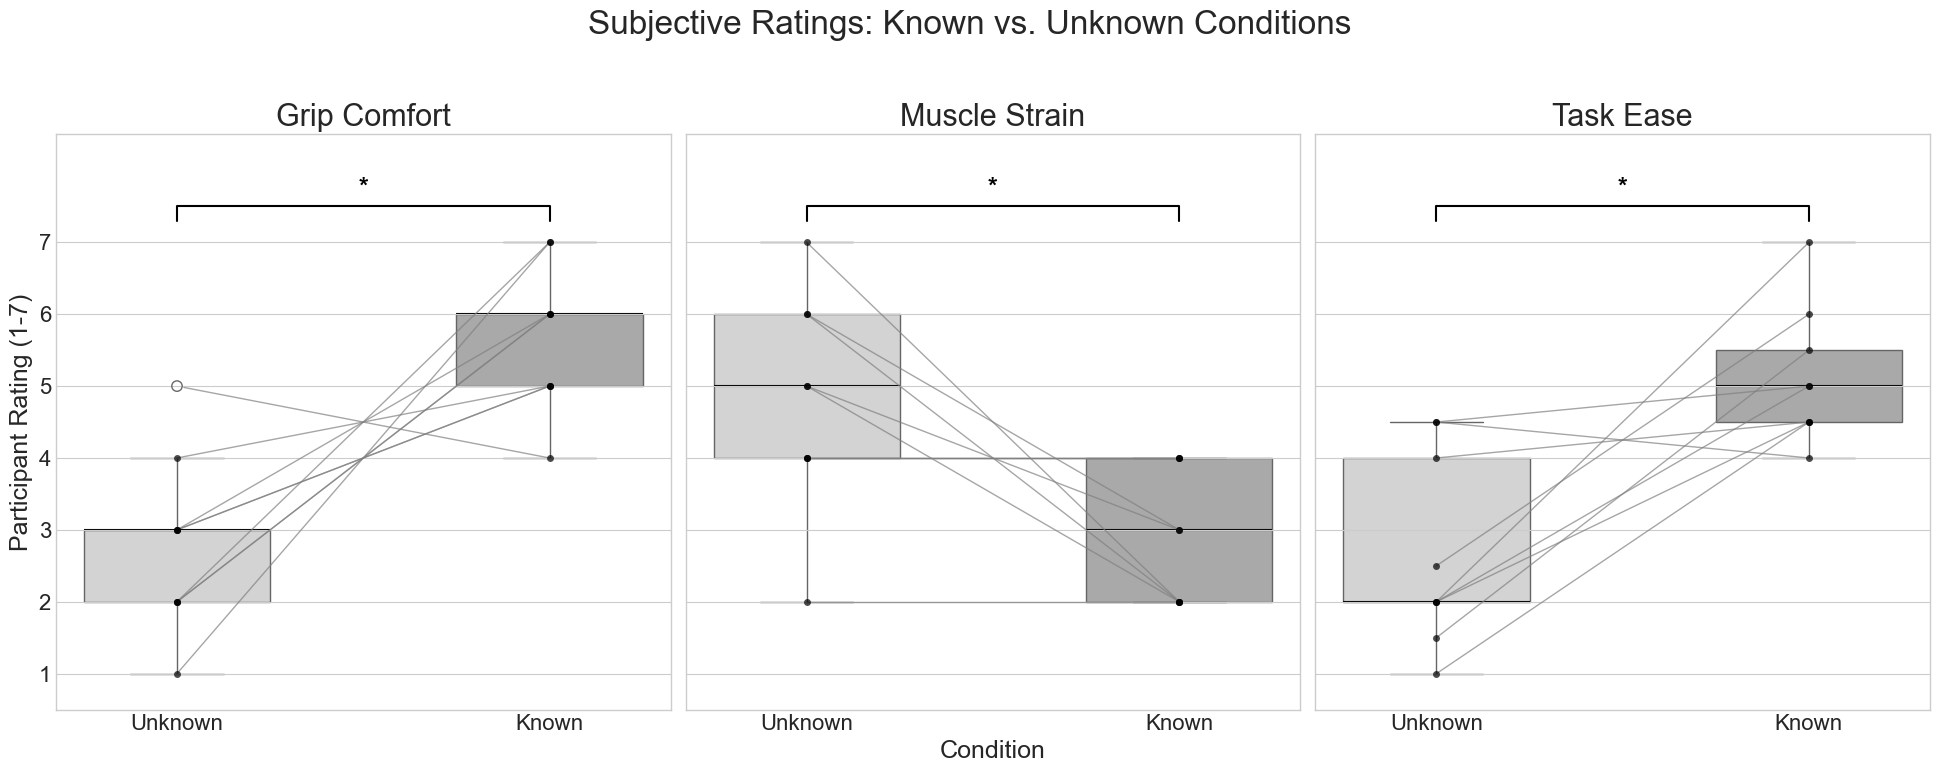


--- Generating Figure 2: Preference Rating Distributions ---


c:\Users\schmi\Documents\Studium\TUM\Masterthesis\Scripts\.venv\lib\site-packages\scipy\stats\_wilcoxon.py:199: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)


Preference ratings distributions plot saved to C:\Users\schmi\Documents\Studium\TUM\Masterthesis\Adapted Results for Paper\Q4_Survey_Results\Preference_Ratings_Distributions_with_Significance.png


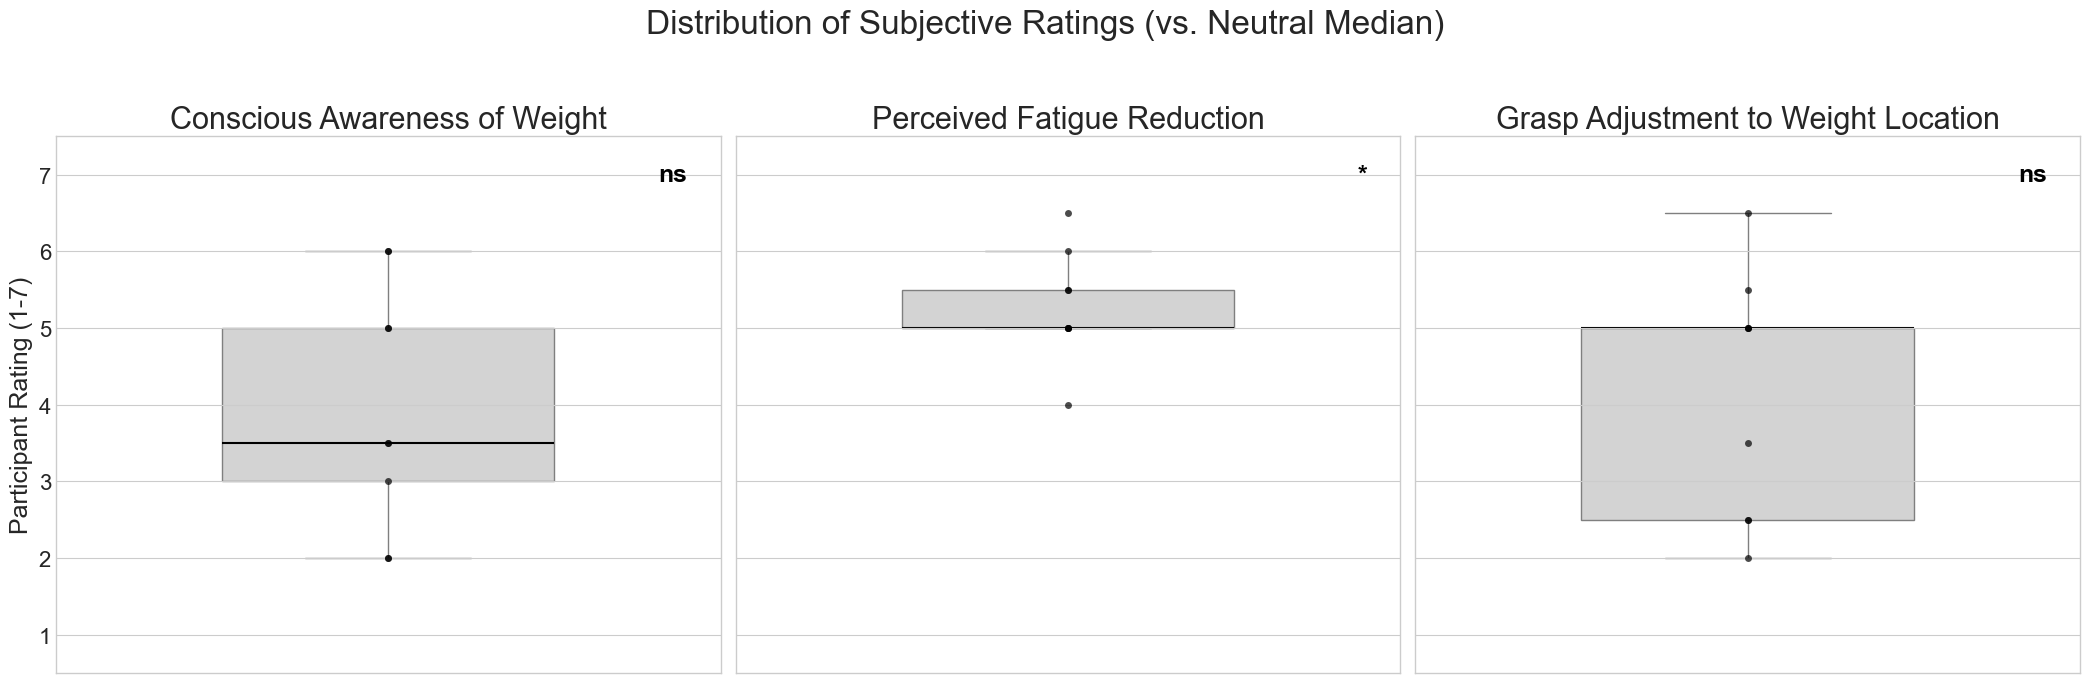


--- One-Sample Wilcoxon Tests (vs. Neutral=4) for Preference Ratings ---
One-sample test for Awareness: Statistic=22.00, p-value=1.000 (ns)
One-sample test for Fatigue: Statistic=0.00, p-value=0.011 (*)
One-sample test for Adjust Grasp: Statistic=21.00, p-value=0.910 (ns)


c:\Users\schmi\Documents\Studium\TUM\Masterthesis\Scripts\.venv\lib\site-packages\scipy\stats\_wilcoxon.py:199: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)


In [56]:
import os
import numpy as np
import pandas as pd
import warnings
from scipy.stats import wilcoxon
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg # For Cronbach's Alpha
from matplotlib.table import Table

# --- Define new, larger font sizes ---
TITLE_FONTSIZE_LARGE = 22
LABEL_FONTSIZE_LARGE = 18
TICK_FONTSIZE_LARGE = 16
ANNOT_FONTSIZE_LARGE = 18
SUPTITLE_FONTSIZE_LARGE = 24
OUTLIER_SIZE = 6

def load_participant_data(base_path):
    """Load survey responses from all participant files."""
    data = []
    participant_dirs = [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]
    for participant_dir in participant_dirs:
        participant_path = os.path.join(base_path, participant_dir)
        files = [f for f in os.listdir(participant_path) if f.endswith('_responses.npy')]
        for file in files:
            file_path = os.path.join(participant_path, file)
            try:
                participant_data = np.load(file_path, allow_pickle=True).item()
                details = participant_data['details']
                responses = participant_data['responses']
                data.append({
                    'participant_id': details['participant_id'],
                    'responses': responses
                })
            except Exception as e:
                print(f"Error loading file {file_path}: {e}")
    return data

def process_data(data):
    """Process the raw data into DataFrames for original and processed (reverse-coded) responses."""
    Statements = {
        1: "I consciously think about the location of the weight before grasping.",
        2: "I feel more muscle strain when I do not know the weight location.",
        3: "I feel more comfortable with my grip when I know the weight location.",
        4: "I do not adjust my grasp on the handle based on the weight location.",  # Reverse-coded
        5: "I find it easy to lift the object without tilting when I do not know the weight location.",
        6: "I feel less muscle strain when I know the weight location.",  # Reverse-coded
        7: "I find it difficult to lift the object without tilting when I know the weight location.",  # Reverse-coded
        8: "I feel uncomfortable with my grip on the object when I know the weight location.",  # Reverse-coded
        9: "I do not consciously think about the location of the weight before grasping.",  # Reverse-coded
        10: "My muscles feel more fatigued when I know the weight location.",  # Reverse-coded
        11: "My grip feels just as secure when I do not know the weight location.",
        12: "I find it easier to lift the object parallel to the table when I know the weight location.",
        13: "I adjust my grasp on the handle based on the weight location.",
        14: "My muscles feel less fatigued when I know the weight location.",
        15: "I find it difficult to lift the object without tilting when I do not know the weight location.",  # Reverse-coded
        16: "My grip feels safer when I know the weight location.",
        17: "I regularly engage in strength training exercises for my arm muscles."
    }
    data_rows = []
    for participant in data:
        participant_id = participant['participant_id']
        responses = participant['responses']
        if len(responses) != 17:
            print(f"Participant {participant_id} has {len(responses)} responses instead of 17.")
            continue
        row = {'participant_id': participant_id}
        for i, resp in enumerate(responses):
            row[f'Q{i+1}'] = resp
        data_rows.append(row)
    df_original = pd.DataFrame(data_rows)
    df_constructs = df_original.copy()
    df_consistency = df_original.copy() # Retained for potential consistency score calculation
    df_Statements = pd.DataFrame.from_dict(Statements, orient='index', columns=['Statement_Text'])
    df_Statements.index = [f'Q{i}' for i in df_Statements.index]
    reversed_items_constructs = [4, 6, 7, 8, 9, 10, 15]
    for item in reversed_items_constructs:
        df_constructs[f'Q{item}'] = 8 - df_constructs[f'Q{item}']
    
    # This was for consistency checks, keep if consistency score is calculated later
    reversed_items_consistency = [4, 6, 7, 8, 9, 10, 11, 15]
    for item in reversed_items_consistency:
        if f'Q{item}' in df_consistency.columns: # Check if column exists
             df_consistency[f'Q{item}'] = 8 - df_consistency[f'Q{item}']

    return df_constructs, df_consistency, df_original, df_Statements

def compute_constructs(df_constructs_input):
    """Compute constructs from survey Statements."""
    constructs_map = { # This is the map of construct names to question numbers
        'Awareness': [1, 9], 'Muscle Strain': [2, 6], 'Fatigue': [10, 14],
        'Grip Comfort': [3, 8, 11, 16], 'Adjust Grasp': [4, 13], 'Task Ease': [5, 7, 12, 15],
        'Strength Training': [17] # Single item construct
    }
    # Create a new DataFrame for aggregated scores to avoid modifying the input df_items_processed directly
    df_aggregated_scores = pd.DataFrame(index=df_constructs_input.index)
    df_aggregated_scores['participant_id'] = df_constructs_input['participant_id']


    for construct_name, item_q_numbers in constructs_map.items():
        q_cols = [f'Q{i}' for i in item_q_numbers]
        # Ensure all q_cols are actually in the df_constructs_input dataframe
        valid_q_cols = [col for col in q_cols if col in df_constructs_input.columns]
        if valid_q_cols:
             df_aggregated_scores[construct_name] = df_constructs_input[valid_q_cols].mean(axis=1)
        else:
            print(f"Warning: No valid question columns found for construct {construct_name}. It will be NaN in aggregated scores.")
            df_aggregated_scores[construct_name] = np.nan
            
    return df_aggregated_scores, constructs_map

def analyze_data(df_items_processed, df_constructs_aggregated, constructs_map_dict, output_dir):
    """
    Performs statistical analysis and generates two final figures:
    1. Paired tests for Known vs. Unknown conditions with advanced boxplot styling.
    2. Distribution plots for preference constructs with individual data points.
    """

    # --- Define Marker Sizes (in points) ---
    REGULAR_MARKER_DIAMETER = 5
    OUTLIER_MARKER_DIAMETER = 7.5

    # --- FIGURE 1: Paired Wilcoxon Tests & Boxplots (Known vs. Unknown) ---
    print("\n--- Generating Figure 1: Known vs. Unknown Conditions ---")
    plot_order_paired = ['Grip Comfort', 'Muscle Strain', 'Task Ease']
    paired_test_item_definitions = {
        'Grip Comfort': {'Known_Items': [f'Q{i}' for i in [16]], 'Unknown_Items': [f'Q{i}' for i in [11]]},
        'Muscle Strain': {'Known_Items': [f'Q{i}' for i in [6]], 'Unknown_Items': [f'Q{i}' for i in [2]]},
        'Task Ease': {'Known_Items': [f'Q{i}' for i in [7, 12]], 'Unknown_Items': [f'Q{i}' for i in [5, 15]]}
    }
    num_paired_constructs = len(plot_order_paired)

    fig_paired, axes_paired = plt.subplots(1, num_paired_constructs, figsize=(6.5 * num_paired_constructs, 8), sharey=True)
    if num_paired_constructs == 1: axes_paired = [axes_paired]

    plot_order_conditions = ['Unknown', 'Known']
    palette_colors = {'Unknown': 'lightgrey', 'Known': 'darkgrey'}

    for i, construct_name in enumerate(plot_order_paired):
        ax = axes_paired[i]
        items_dict = paired_test_item_definitions[construct_name]
        known_cols, unknown_cols = items_dict['Known_Items'], items_dict['Unknown_Items']

        if not (all(col in df_items_processed.columns for col in known_cols) and all(col in df_items_processed.columns for col in unknown_cols)):
            ax.text(0.5, 0.5, "Data N/A", ha='center', va='center'); ax.set_title(construct_name)
            continue

        current_known_scores = df_items_processed[known_cols].mean(axis=1)
        current_unknown_scores = df_items_processed[unknown_cols].mean(axis=1)
        common_indices = current_known_scores.dropna().index.intersection(current_unknown_scores.dropna().index)
        aligned_known_scores = current_known_scores.loc[common_indices]
        aligned_unknown_scores = current_unknown_scores.loc[common_indices]

        stat, p_value = (np.nan, np.nan)
        if len(aligned_known_scores) >= 2:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", UserWarning)
                stat, p_value = wilcoxon(aligned_known_scores, aligned_unknown_scores)
        
        print(f"\nWilcoxon Test: {construct_name} (Known vs. Unknown)")
        print(f"  Statistic: {stat:.2f}, p-value: {p_value:.3f}")

        plot_data_wide = pd.DataFrame({'Known': aligned_known_scores, 'Unknown': aligned_unknown_scores})
        
        q1_k, q3_k = plot_data_wide['Known'].quantile(0.25), plot_data_wide['Known'].quantile(0.75)
        iqr_k = q3_k - q1_k
        plot_data_wide['Known_is_outlier'] = ((plot_data_wide['Known'] < (q1_k - 1.5 * iqr_k)) | (plot_data_wide['Known'] > (q3_k + 1.5 * iqr_k)))

        q1_u, q3_u = plot_data_wide['Unknown'].quantile(0.25), plot_data_wide['Unknown'].quantile(0.75)
        iqr_u = q3_u - q1_u
        plot_data_wide['Unknown_is_outlier'] = ((plot_data_wide['Unknown'] < (q1_u - 1.5 * iqr_u)) | (plot_data_wide['Unknown'] > (q3_u + 1.5 * iqr_u)))
        
        plot_data_melted = plot_data_wide.drop(columns=['Known_is_outlier', 'Unknown_is_outlier']).reset_index().melt(id_vars='index', var_name='Condition', value_name='Score')
        is_outlier_melted = plot_data_wide[['Known_is_outlier', 'Unknown_is_outlier']].rename(columns={'Known_is_outlier': 'Known', 'Unknown_is_outlier': 'Unknown'}).reset_index().melt(id_vars='index', var_name='Condition', value_name='is_outlier')
        
        plot_data_melted = pd.merge(plot_data_melted, is_outlier_melted, on=['index', 'Condition'])
        non_outliers_melted = plot_data_melted[~plot_data_melted['is_outlier']]
        outliers_melted = plot_data_melted[plot_data_melted['is_outlier']]

        sns.boxplot(x='Condition', y='Score', data=plot_data_melted, ax=ax, order=plot_order_conditions, palette=palette_colors, width=0.5, showfliers=False, medianprops=dict(color='black', linewidth=1.5), zorder=0)

        lines_to_adjust = []
        for participant_index, row in plot_data_wide.iterrows():
            line, = ax.plot([0, 1], [row['Unknown'], row['Known']], color='gray', lw=1, alpha=0.7, zorder=1)
            lines_to_adjust.append({'line': line, 'row': row})

        if not non_outliers_melted.empty:
            sns.stripplot(x='Condition', y='Score', data=non_outliers_melted, ax=ax, order=plot_order_conditions, jitter=False, color='black', alpha=0.7, zorder=2, size=REGULAR_MARKER_DIAMETER)

        if not outliers_melted.empty:
            sns.stripplot(x='Condition', y='Score', data=outliers_melted, ax=ax, order=plot_order_conditions, jitter=False, marker='o', edgecolor='dimgray', facecolors='none', linewidth=1, zorder=3, size=OUTLIER_MARKER_DIAMETER)
            
        ax.set_title(construct_name, fontsize=TITLE_FONTSIZE_LARGE)
        
        # --- MODIFIED: Set xlabel only for the middle plot ---
        if i == (num_paired_constructs - 1) // 2:
            ax.set_xlabel('Condition', fontsize=LABEL_FONTSIZE_LARGE)
        else:
            ax.set_xlabel('')
            
        if i == 0:
            ax.set_ylabel('Participant Rating (1-7)', fontsize=LABEL_FONTSIZE_LARGE)
        else:
            ax.set_ylabel('')
        
        ax.tick_params(axis='both', labelsize=TICK_FONTSIZE_LARGE)
        ax.set_yticks(np.arange(1, 8, 1))
        ax.set_ylim(0.5, 8.5)

        asterisk_text = "n/a" if pd.isna(p_value) else ("***" if p_value < 0.001 else ("**" if p_value < 0.01 else ("*" if p_value < 0.05 else "ns")))
        if not pd.isna(p_value) and not plot_data_melted.empty:
            y_max_data = plot_data_melted['Score'].max()
            bracket_y_start = y_max_data + 0.3
            bracket_height = bracket_y_start + 0.2
            text_y = bracket_height + 0.1
            ax.plot([0, 0, 1, 1], [bracket_y_start, bracket_height, bracket_height, bracket_y_start], c='black', lw=1.5)
            ax.text(0.5, text_y, asterisk_text, ha='center', va='bottom', fontsize=ANNOT_FONTSIZE_LARGE, color='black', weight='bold')

        dpi = fig_paired.get_dpi()
        ax_bbox_pix = ax.get_window_extent()
        if ax_bbox_pix.width == 0 or ax_bbox_pix.height == 0: continue

        x_scale = (ax.get_xlim()[1] - ax.get_xlim()[0]) / ax_bbox_pix.width
        y_scale = (ax.get_ylim()[1] - ax.get_ylim()[0]) / ax_bbox_pix.height
        
        for item in lines_to_adjust:
            line, row_data = item['line'], item['row']
            
            d1_pts = OUTLIER_MARKER_DIAMETER if row_data['Unknown_is_outlier'] else 0
            d2_pts = OUTLIER_MARKER_DIAMETER if row_data['Known_is_outlier'] else 0

            if d1_pts == 0 and d2_pts == 0: continue

            r1_pix = (d1_pts / 2.0) * (dpi / 72.0)
            r2_pix = (d2_pts / 2.0) * (dpi / 72.0)
            
            x1, y1 = 0, row_data['Unknown']
            x2, y2 = 1, row_data['Known']
            
            vx_pix = (x2 - x1) / x_scale
            vy_pix = (y2 - y1) / y_scale
            len_v_pix = np.sqrt(vx_pix**2 + vy_pix**2)

            if len_v_pix == 0: continue
            
            shorten_frac1 = r1_pix / len_v_pix
            shorten_frac2 = r2_pix / len_v_pix

            if shorten_frac1 + shorten_frac2 >= 1.0:
                line.set_visible(False)
                continue
                
            new_x1 = x1 + (x2 - x1) * shorten_frac1
            new_y1 = y1 + (y2 - y1) * shorten_frac1
            new_x2 = x2 - (x2 - x1) * shorten_frac2
            new_y2 = y2 - (y2 - y1) * shorten_frac2
            
            line.set_data([new_x1, new_x2], [new_y1, new_y2])

    fig_paired.suptitle("Subjective Ratings: Known vs. Unknown Conditions", fontsize=SUPTITLE_FONTSIZE_LARGE, y=0.99)
    fig_paired.tight_layout(rect=[0, 0.03, 1, 0.95])
    plot_filename_paired = os.path.join(output_dir, "Constructs_Known_vs_Unknown_Boxplots.png")
    plt.savefig(plot_filename_paired, bbox_inches='tight', dpi=300)
    print(f"\nCombined 'Known vs. Unknown' plot saved to {plot_filename_paired}")
    plt.show()


    # --- FIGURE 2: Distribution Plots for Preference Ratings with Significance ---
    # This section remains the same.
    print("\n--- Generating Figure 2: Preference Rating Distributions ---")
    preference_constructs = ['Awareness', 'Fatigue', 'Adjust Grasp']
    preference_plot_titles = {
        'Awareness': 'Conscious Awareness of Weight',
        'Fatigue': 'Perceived Fatigue Reduction',
        'Adjust Grasp': 'Grasp Adjustment to Weight Location'
    }
    num_pref_constructs = len(preference_constructs)

    fig_pref, axes_pref = plt.subplots(1, num_pref_constructs, figsize=(7 * num_pref_constructs, 7), sharey=True)
    if num_pref_constructs == 1: axes_pref = [axes_pref]

    for i, construct_name in enumerate(preference_constructs):
        ax = axes_pref[i]
        
        if construct_name not in df_constructs_aggregated.columns or df_constructs_aggregated[construct_name].isnull().all():
            ax.text(0.5, 0.5, "Data N/A", ha='center', va='center'); ax.set_title(preference_plot_titles.get(construct_name, construct_name))
            continue

        data_series = df_constructs_aggregated[construct_name].dropna()
        
        sns.boxplot(y=data_series, ax=ax, color="lightgrey", width=0.5, 
                    showfliers=False,
                    medianprops=dict(color='black', linewidth=1.5),
                    zorder=0)
        
        sns.stripplot(y=data_series, ax=ax, 
                      jitter=False,
                      color='black', alpha=0.7, 
                      zorder=1,
                      size=REGULAR_MARKER_DIAMETER)

        stat, p_value = (np.nan, np.nan)
        if len(data_series) >= 2:
            stat, p_value = wilcoxon(data_series - 4)
        
        asterisk_text = "n/a" if pd.isna(p_value) else ("***" if p_value < 0.001 else ("**" if p_value < 0.01 else ("*" if p_value < 0.05 else "ns")))
        ax.text(0.95, 0.95, asterisk_text, transform=ax.transAxes, ha='right', va='top', fontsize=ANNOT_FONTSIZE_LARGE, color='black', weight='bold')

        ax.set_title(preference_plot_titles.get(construct_name, construct_name), fontsize=TITLE_FONTSIZE_LARGE)
        
        if i == 0:
            ax.set_ylabel('Participant Rating (1-7)', fontsize=LABEL_FONTSIZE_LARGE)
        else:
            ax.set_ylabel('')
            
        ax.set_xlabel('')
        ax.tick_params(axis='y', labelsize=TICK_FONTSIZE_LARGE)
        ax.set_xticks([])
        ax.set_yticks(np.arange(1, 8, 1))
        ax.set_ylim(0.5, 7.5)

    fig_pref.suptitle('Distribution of Subjective Ratings (vs. Neutral Median)', fontsize=SUPTITLE_FONTSIZE_LARGE, y=1.0)
    fig_pref.tight_layout(rect=[0, 0.03, 1, 0.95])
    plot_filename_pref = os.path.join(output_dir, "Preference_Ratings_Distributions_with_Significance.png")
    plt.savefig(plot_filename_pref, bbox_inches='tight', dpi=300)
    print(f"Preference ratings distributions plot saved to {plot_filename_pref}")
    plt.show()

    # Console output for the Wilcoxon tests
    print("\n--- One-Sample Wilcoxon Tests (vs. Neutral=4) for Preference Ratings ---")
    for construct_name in preference_constructs:
        if construct_name in df_constructs_aggregated.columns and not df_constructs_aggregated[construct_name].isnull().all():
            data_series = df_constructs_aggregated[construct_name].dropna()
            if len(data_series) >= 2:
                stat, p_value = wilcoxon(data_series - 4)
                asterisk_text = "n/a" if pd.isna(p_value) else ("***" if p_value < 0.001 else ("**" if p_value < 0.01 else ("*" if p_value < 0.05 else "ns")))
                print(f"One-sample test for {construct_name}: Statistic={stat:.2f}, p-value={p_value:.3f} ({asterisk_text})")

def main():
    """Main function to run the analysis workflow."""
    base_path = r"C:\Users\schmi\Documents\Studium\TUM\Masterthesis\Experimental Data"
    output_dir = r"C:\Users\schmi\Documents\Studium\TUM\Masterthesis\Adapted Results for Paper\Q4_Survey_Results"
    os.makedirs(output_dir, exist_ok=True)
    print(f"Plots and results will be saved to: {output_dir}")

    try:
        data = load_participant_data(base_path)
        if not data:
            raise ValueError("No participant data found.")

        df_items_processed, _, _, _ = process_data(data) # df_consistency, df_original, df_Statements also returned

        # df_constructs_aggregated contains mean scores for each construct per participant
        # constructs_map links construct names to lists of Q numbers (used for reliability)
        df_constructs_aggregated, constructs_map = compute_constructs(df_items_processed.copy())

        print("\n--- Reliability Measures (Cronbach's Alpha) ---")
        for construct_name_key, question_items_nums in constructs_map.items():
            if construct_name_key == 'Strength Training': # Skip single item constructs for reliability
                print(f"{construct_name_key}: Single item, reliability metrics not applicable.")
                continue
            if len(question_items_nums) > 1:
                item_q_cols = [f'Q{i}' for i in question_items_nums]
                valid_item_q_cols = [col for col in item_q_cols if col in df_items_processed.columns]

                if not valid_item_q_cols or len(valid_item_q_cols) < 2 :
                    print(f"{construct_name_key}: Not enough valid items ({len(valid_item_q_cols)}) for reliability.")
                    continue

                item_scores_df = df_items_processed[valid_item_q_cols].copy().dropna()
                
                if item_scores_df.shape[0] < 2 or item_scores_df.shape[1] < 2:
                    print(f"{construct_name_key}: Not enough data after NaN removal for reliability (rows: {item_scores_df.shape[0]}, items: {item_scores_df.shape[1]})")
                    continue
                
                try:
                    alpha_pg, _ = pg.cronbach_alpha(data=item_scores_df) # type: ignore
                    print(f"{construct_name_key}: Cronbach's Alpha (Pingouin) = {alpha_pg:.2f}")
                except Exception as e:
                    print(f"Could not compute Cronbach's Alpha for {construct_name_key}: {e}")
            # No else needed as single item case is handled by the 'Strength Training' check or len(q_items_nums) <=1 implicitly

        # Pass both item-level processed data and aggregated construct data to analyze_data
        analyze_data(df_items_processed.copy(), df_constructs_aggregated.copy(), constructs_map, output_dir)
        
        # Other analyses like correlation, response heatmaps, consistency scores
        # can be called here if their respective functions are defined and needed.
        # Example:
        # correlation_analysis(df_constructs_aggregated, constructs_map, output_dir)
        # visualize_responses(df_original, df_Statements_map, False, output_dir)
        # ... etc.

    except Exception as e:
        print(f"\nAn error occurred in main execution: {e}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()

### Question 5: Mapping of Channels to Muscle and Kinematic Groups

### Question 6: Task Efficiency and overall Muscle Activation between Known and Unknown Conditions


--- Pass 1: Finding Peak Activation Values for Normalization ---
--- Peak values determined for all participants. ---

--- Pass 2: Calculating Raw and Normalized Activation ---
--- Processing P(1) ---
--- Processing P(2) ---
--- Processing P(3) ---
--- Processing P(4) ---
--- Processing P(5) ---
--- Processing P(6) ---
--- Processing P(7) ---
--- Processing P(8) ---

--- Paired T-Test Results for Average Activation (a.u.) ---
t-statistic: 4.309, p-value: 0.004


C:\Users\schmi\AppData\Local\Temp\ipykernel_29892\2668149703.py:143: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='condition', y=y_column, data=aggregated_df, order=plot_order, palette=palette_colors,
C:\Users\schmi\AppData\Local\Temp\ipykernel_29892\2668149703.py:166: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(plot_order)


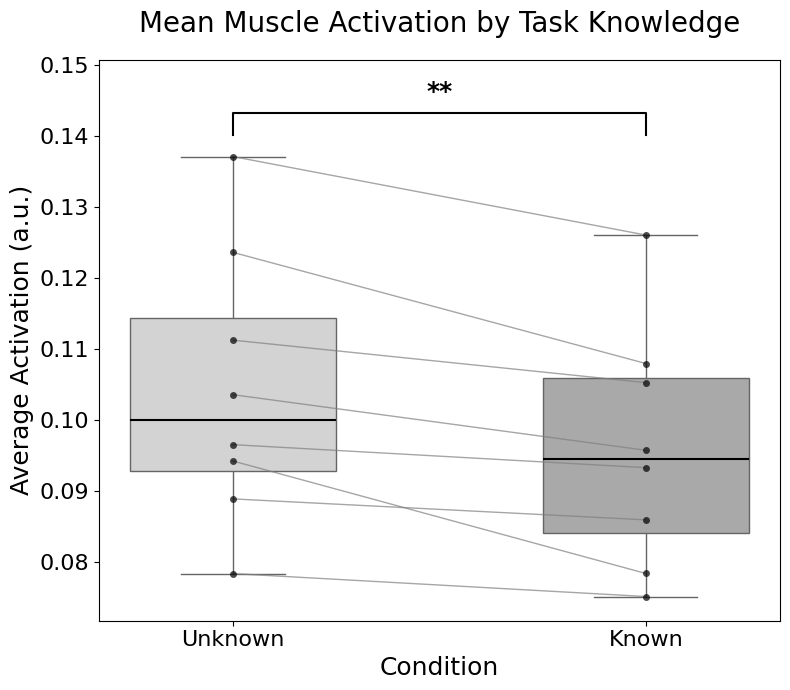

[INFO] Saved styled box plot to C:\Users\schmi\Documents\Studium\TUM\Masterthesis\Adapted Results for Paper\Q6_Muscle_Activity\activation_boxplot_raw.png

--- Paired T-Test Results for Normalized Activation (% Peak) ---
t-statistic: 4.529, p-value: 0.003


C:\Users\schmi\AppData\Local\Temp\ipykernel_29892\2668149703.py:143: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='condition', y=y_column, data=aggregated_df, order=plot_order, palette=palette_colors,
C:\Users\schmi\AppData\Local\Temp\ipykernel_29892\2668149703.py:166: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(plot_order)


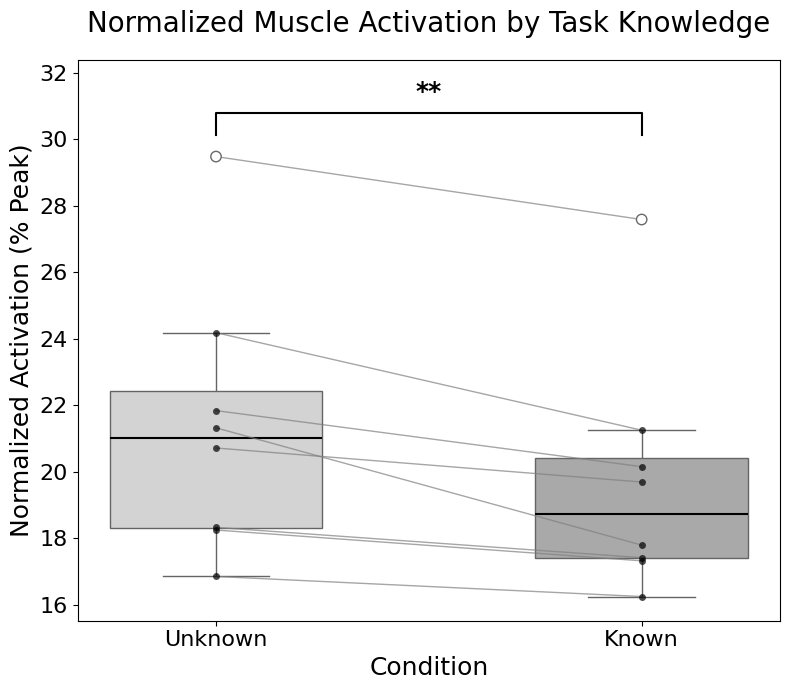

[INFO] Saved styled box plot to C:\Users\schmi\Documents\Studium\TUM\Masterthesis\Adapted Results for Paper\Q6_Muscle_Activity\activation_boxplot_normalized.png


In [39]:
# -------------------------------------------------------------------
# Analysis of Phase 2 EMG and OTB Data: Comparing Muscle Activation Between
# "Known" and "Unknown" Task Knowledge Conditions
# -------------------------------------------------------------------

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_rel
import warnings

# -------------------------------------------------------------------
# 0) Global Configuration
# -------------------------------------------------------------------
BASE_DIR = r"C:\Users\schmi\Documents\Studium\TUM\Masterthesis\Experimental Data"
PARTICIPANTS = [1, 2, 3, 4, 5, 6, 7, 8]
TRIALS = range(1, 25)  # Trials 1 to 24
PHASE = "phase2"

# Updated Output directory
OUTPUT_DIR = r"C:\Users\schmi\Documents\Studium\TUM\Masterthesis\Adapted Results for Paper\Q6_Muscle_Activity"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Font size definitions for consistent, readable plots
TITLE_FONTSIZE_LARGE = 20
LABEL_FONTSIZE_LARGE = 18
TICK_FONTSIZE_LARGE = 16
ANNOT_FONTSIZE_LARGE = 18
OUTLIER_SIZE = 6

# -------------------------------------------------------------------
# 1) Helper Functions (Data Loading & Metadata)
# -------------------------------------------------------------------
def trial_info(trial_number):
    """Returns metadata about each trial."""
    protocol = {
        1: ("Precision Grasp (Four Fingers and Thumb)", "Precision Handle", 0.25, "Left Lever", "No"),
        2: ("Precision Grasp (Four Fingers and Thumb)", "Precision Handle", 0.25, "Left Lever", "Yes"),
        3: ("Lateral Pinch Grasp", "Lateral Pinch Handle", 0.25, "Right Lever", "No"),
        4: ("Lateral Pinch Grasp", "Lateral Pinch Handle", 0.25, "Right Lever", "Yes"),
        5: ("Ball Grasp", "Ball Handle", 0.50, "Left Lever", "No"),
        6: ("Ball Grasp", "Ball Handle", 0.50, "Left Lever", "Yes"),
        7: ("Precision Grasp (Thumb and Index)", "Precision Handle", 0.25, "Front Lever", "No"),
        8: ("Precision Grasp (Thumb and Index)", "Precision Handle", 0.25, "Front Lever", "Yes"),
        9: ("Disc Grip", "Disc Handle", 0.50, "Back Lever", "No"),
        10: ("Disc Grip", "Disc Handle", 0.50, "Back Lever", "Yes"),
        11: ("Power Bar Grasp", "Power Bar Handle", 0.50, "Front Lever", "No"),
        12: ("Power Bar Grasp", "Power Bar Handle", 0.50, "Front Lever", "Yes"),
        13: ("Precision Grasp (Four Fingers and Thumb)", "Precision Handle", 0.25, "Front Lever", "No"),
        14: ("Precision Grasp (Four Fingers and Thumb)", "Precision Handle", 0.25, "Front Lever", "Yes"),
        15: ("Lateral Pinch Grasp", "Lateral Pinch Handle", 0.25, "Back Lever", "No"),
        16: ("Lateral Pinch Grasp", "Lateral Pinch Handle", 0.25, "Back Lever", "Yes"),
        17: ("Ball Grasp", "Ball Handle", 0.50, "Front Lever", "No"),
        18: ("Ball Grasp", "Ball Handle", 0.50, "Front Lever", "Yes"),
        19: ("Precision Grasp (Thumb and Index)", "Precision Handle", 0.25, "Back Lever", "No"),
        20: ("Precision Grasp (Thumb and Index)", "Precision Handle", 0.25, "Back Lever", "Yes"),
        21: ("Disc Grip", "Disc Handle", 0.50, "Left Lever", "No"),
        22: ("Disc Grip", "Disc Handle", 0.50, "Left Lever", "Yes"),
        23: ("Power Bar Grasp", "Power Bar Handle", 0.50, "Right Lever", "No"),
        24: ("Power Bar Grasp", "Power Bar Handle", 0.50, "Right Lever", "Yes"),
    }
    if trial_number not in protocol: return None
    tup = protocol[trial_number]
    return {'grasp_type': tup[0], 'handle_type': tup[1], 'weight_kg': tup[2], 'lever_side': tup[3], 'knowledge': tup[4]}

def load_emg_data(participant_dir, trial_idx):
    """Loads the EMG data for a given participant and trial."""
    sync_dir = os.path.join(participant_dir, "Synchronized Data split in Phases")
    emg_file = os.path.join(sync_dir, f"match_{trial_idx:02d}_phase2_myo.npy")
    return np.load(emg_file) if os.path.exists(emg_file) else None

def load_otb_data(participant_dir, trial_idx):
    """Loads the OTB data for a given participant and trial."""
    sync_dir = os.path.join(participant_dir, "Synchronized Data split in Phases")
    otb_file = os.path.join(sync_dir, f"match_{trial_idx:02d}_phase2_otb.npy")
    return np.load(otb_file) if os.path.exists(otb_file) else None

# -------------------------------------------------------------------
# 2) Plotting Helper Function
# -------------------------------------------------------------------

def create_activation_boxplot(aggregated_df, y_column, y_label, title, output_filename):
    """
    Creates a boxplot where connection lines stop at the edge of outlier markers only.
    """
    # --- Define Marker Sizes (in points) ---
    REGULAR_MARKER_DIAMETER = 5
    OUTLIER_MARKER_DIAMETER = 7.5

    # --- Data Preparation ---
    pivot = aggregated_df.pivot(index='participant', columns='condition', values=y_column).dropna()
    if len(pivot) < 2:
        print(f"\n[ERROR] Not enough paired data for '{y_column}' to perform a t-test.")
        return

    # --- Upfront Outlier Detection (Corrected Logic) ---
    all_outlier_indices = []
    pivot['Unknown_is_outlier'] = False
    pivot['Known_is_outlier'] = False

    for condition in ['Unknown', 'Known']:
        # Isolate data for the condition
        condition_df = aggregated_df[aggregated_df['condition'] == condition]
        y_values = condition_df[y_column]

        # Calculate IQR bounds
        q1 = y_values.quantile(0.25)
        q3 = y_values.quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        
        # Find outliers for this condition
        is_outlier_mask = (y_values < lower_bound) | (y_values > upper_bound)
        
        # Store the dataframe indices of the outliers for later plotting
        outlier_indices_for_condition = condition_df[is_outlier_mask].index
        all_outlier_indices.extend(outlier_indices_for_condition)
        
        # Update the pivot table for the line shortening logic
        outlier_participants = condition_df[is_outlier_mask]['participant'].unique()
        pivot.loc[pivot.index.isin(outlier_participants), f'{condition}_is_outlier'] = True

    # Create clean DataFrames for plotting outliers vs. non-outliers
    outliers_df = aggregated_df.loc[all_outlier_indices]
    non_outliers_df = aggregated_df.drop(all_outlier_indices)
    
    # --- Paired T-Test ---
    t_stat, p_val = ttest_rel(pivot['Unknown'], pivot['Known'])
    print(f"\n--- Paired T-Test Results for {y_label} ---")
    print(f"t-statistic: {t_stat:.3f}, p-value: {p_val:.3f}")

    # --- Plotting ---
    fig = plt.figure(figsize=(8, 7))
    ax = plt.gca()

    plot_order = ['Unknown', 'Known']
    palette_colors = {"Unknown": "lightgrey", "Known": "darkgrey"}

    # 1. Boxplot
    sns.boxplot(x='condition', y=y_column, data=aggregated_df, order=plot_order, palette=palette_colors, 
                width=0.5, ax=ax, showfliers=False, medianprops=dict(color='black', linewidth=1.5), zorder=0)

    # 2. Pairwise connection lines (initial full-length draw)
    lines_to_adjust = []
    for participant_index, row in pivot.iterrows():
        line, = ax.plot([0, 1], [row['Unknown'], row['Known']], color='gray', lw=1, alpha=0.7, zorder=1)
        lines_to_adjust.append({'line': line, 'row': row})

    # 3 & 4. Plot data points (non-outliers as solid dots, outliers as hollow circles)
    if not non_outliers_df.empty:
        sns.stripplot(x='condition', y=y_column, data=non_outliers_df, order=plot_order, jitter=False, ax=ax,
                      color='black', alpha=0.7, zorder=2, size=REGULAR_MARKER_DIAMETER)
    
    if not outliers_df.empty:
        sns.stripplot(x='condition', y=y_column, data=outliers_df, order=plot_order, jitter=False, ax=ax,
                      marker='o', edgecolor='dimgray', facecolors='none', linewidth=1, zorder=3, size=OUTLIER_MARKER_DIAMETER)

    # --- Formatting (run this before line adjustment to fix axis scales) ---
    ax.set_title(title, fontsize=TITLE_FONTSIZE_LARGE, pad=20)
    ax.set_xlabel('Condition', fontsize=LABEL_FONTSIZE_LARGE)
    ax.set_ylabel(y_label, fontsize=LABEL_FONTSIZE_LARGE)
    ax.tick_params(axis='both', labelsize=TICK_FONTSIZE_LARGE)
    ax.set_xticklabels(plot_order)
    # (Significance bracket code remains the same...)
    asterisk_text = "***" if p_val < 0.001 else ("**" if p_val < 0.01 else ("*" if p_val < 0.05 else "ns"))
    y_max = aggregated_df[y_column].max()
    y_range = aggregated_df[y_column].max() - aggregated_df[y_column].min()
    if y_range == 0: y_range = y_max if y_max > 0 else 1
    bracket_y_start = y_max + (y_range * 0.05)
    bracket_height = bracket_y_start + (y_range * 0.05)
    text_y = bracket_height + (y_range * 0.02)
    ax.plot([0, 0, 1, 1], [bracket_y_start, bracket_height, bracket_height, bracket_y_start], c='black', lw=1.5)
    ax.text(0.5, text_y, asterisk_text, ha='center', va='bottom', fontsize=ANNOT_FONTSIZE_LARGE, color='black', weight='bold')
    ax.set_ylim(top=text_y + (y_range * 0.1))

    # --- Final Line Adjustment (Corrected Logic) ---
    dpi = fig.get_dpi()
    ax_bbox_pix = ax.get_window_extent()
    x_scale = (ax.get_xlim()[1] - ax.get_xlim()[0]) / ax_bbox_pix.width
    y_scale = (ax.get_ylim()[1] - ax.get_ylim()[0]) / ax_bbox_pix.height

    for item in lines_to_adjust:
        line, row_data = item['line'], item['row']
        
        # --- MODIFIED: Set shortening radius to 0 for non-outliers ---
        d1_pts = OUTLIER_MARKER_DIAMETER if row_data['Unknown_is_outlier'] else 0
        d2_pts = OUTLIER_MARKER_DIAMETER if row_data['Known_is_outlier'] else 0
        
        # If both ends are regular points, the radii are 0 and we can skip to the next line
        if d1_pts == 0 and d2_pts == 0:
            continue

        r1_pix = (d1_pts / 2.0) * (dpi / 72.0)
        r2_pix = (d2_pts / 2.0) * (dpi / 72.0)
        
        # (The rest of the calculation logic remains the same)
        x1, y1 = 0, row_data['Unknown']
        x2, y2 = 1, row_data['Known']
        
        vx_pix = (x2 - x1) / x_scale
        vy_pix = (y2 - y1) / y_scale
        len_v_pix = np.sqrt(vx_pix**2 + vy_pix**2)

        if len_v_pix == 0: continue
        
        shorten_frac1 = r1_pix / len_v_pix
        shorten_frac2 = r2_pix / len_v_pix

        if shorten_frac1 + shorten_frac2 >= 1.0:
            line.set_visible(False)
            continue
            
        new_x1 = x1 + (x2 - x1) * shorten_frac1
        new_y1 = y1 + (y2 - y1) * shorten_frac1
        new_x2 = x2 - (x2 - x1) * shorten_frac2
        new_y2 = y2 - (y2 - y1) * shorten_frac2
        
        line.set_data([new_x1, new_x2], [new_y1, new_y2])

    # --- Save and Show ---
    plt.tight_layout()
    plot_path = os.path.join(OUTPUT_DIR, output_filename)
    plt.savefig(plot_path, dpi=300)
    plt.show()
    print(f"[INFO] Saved styled box plot to {plot_path}")

# -------------------------------------------------------------------
# 3) Main Analysis Function
# -------------------------------------------------------------------
def main_analysis():
    """
    Performs the full analysis pipeline:
    1. Finds peak activation for each channel per participant for normalization.
    2. Calculates raw average and normalized average activation for each trial.
    3. Generates and saves plots for both metrics.
    """
    # --- Step 1: First pass to find peak values for normalization ---
    print("--- Pass 1: Finding Peak Activation Values for Normalization ---")
    participant_peaks = {}
    for pid in PARTICIPANTS:
        participant_str = f"P({pid})"
        participant_dir = os.path.join(BASE_DIR, participant_str)
        if not os.path.isdir(participant_dir): continue

        # Initialize with zeros. Shape is 117 (5 EMG + 112 OTB).
        peak_vector = np.zeros(117)
        for trial_idx in TRIALS:
            if not trial_info(trial_idx): continue
            emg_data = load_emg_data(participant_dir, trial_idx)
            otb_data = load_otb_data(participant_dir, trial_idx)
            if emg_data is None or otb_data is None or emg_data.shape[0] != otb_data.shape[0]:
                continue
            
            combined_data = np.concatenate((emg_data, otb_data), axis=1)
            # Find the maximum value for each channel in the current trial
            trial_peaks = np.max(combined_data, axis=0)
            # Update the overall peak vector for the participant
            peak_vector = np.maximum(peak_vector, trial_peaks)

        # Replace zeros with 1 to avoid division-by-zero errors later
        peak_vector[peak_vector == 0] = 1
        participant_peaks[pid] = peak_vector
    print("--- Peak values determined for all participants. ---")


    # --- Step 2: Main pass to calculate metrics ---
    print("\n--- Pass 2: Calculating Raw and Normalized Activation ---")
    activation_rows = []
    for pid in PARTICIPANTS:
        participant_str = f"P({pid})"
        participant_dir = os.path.join(BASE_DIR, participant_str)
        if not os.path.isdir(participant_dir) or pid not in participant_peaks:
            continue

        print(f"--- Processing {participant_str} ---")
        peak_vector = participant_peaks[pid]

        for trial_idx in TRIALS:
            meta = trial_info(trial_idx)
            if not meta: continue

            emg_data = load_emg_data(participant_dir, trial_idx)
            otb_data = load_otb_data(participant_dir, trial_idx)
            if emg_data is None or otb_data is None or emg_data.shape[0] != otb_data.shape[0]:
                continue

            combined_data = np.concatenate((emg_data, otb_data), axis=1)

            # Metric 1: Raw Average Activation (original method)
            avg_activation_raw = combined_data.mean()

            # Metric 2: Normalized Average Activation (% Peak)
            normalized_data = (combined_data / peak_vector) * 100
            avg_activation_norm = normalized_data.mean()

            activation_rows.append({
                'participant': pid,
                'condition': "Known" if meta['knowledge'] == "Yes" else "Unknown",
                'avg_activation_raw': avg_activation_raw,
                'avg_activation_norm': avg_activation_norm
            })

    # --- Step 3: Aggregation and Plotting ---
    if not activation_rows:
        print("[ERROR] No data was processed. Exiting analysis.")
        return

    full_df = pd.DataFrame(activation_rows)

    # --- Analysis for RAW (non-normalized) data ---
    agg_raw = full_df.groupby(['participant', 'condition'])['avg_activation_raw'].mean().reset_index()
    create_activation_boxplot(
        aggregated_df=agg_raw,
        y_column='avg_activation_raw',
        y_label='Average Activation (a.u.)',
        title='Mean Muscle Activation by Task Knowledge',
        output_filename='activation_boxplot_raw.png'
    )

    # --- Analysis for NORMALIZED data ---
    agg_norm = full_df.groupby(['participant', 'condition'])['avg_activation_norm'].mean().reset_index()
    create_activation_boxplot(
        aggregated_df=agg_norm,
        y_column='avg_activation_norm',
        y_label='Normalized Activation (% Peak)',
        title='Normalized Muscle Activation by Task Knowledge',
        output_filename='activation_boxplot_normalized.png'
    )

# -------------------------------------------------------------------
# 4) Main Execution
# -------------------------------------------------------------------
if __name__ == "__main__":
    main_analysis()